# Определение стоимости автомобилей

**ПОСТАНОВКА ЗАДАЧИ**

**Заказчик исследования** — Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов, в котором пользователи смогут узнать рыночную стоимость своего автомобиля.». Компания оразрабатывает приложение, чтобы привлечь новых клиентов. Цель данной разработки заключается в том, чтобы  пользователи смогли узнать рыночную стоимость своего автомобиля.

**Исходные данные:** Компания предоставила данные о технических характеристиках, комплектации и ценах автомобилей.

**Цель исследования:** Построить модель машинного обучения для предсказания рыночной стоимости автомобиля на основе предоставленных данных.

Основываясь на результатах моделирования, пользователи смогут узнать о рыночной стоимости своего автомобиля не привлекая оценщиков.

**Задачи исследования:**
- Построить модель для предсказания стоимости автомобиля на основе предоставленных данных.
- Проанализировать и сравнить характеристики моделей: время обучения, время предсказания, точность результата.
- Рекомендовать лучшую модель, опираясь на критерии заказчика.

**Ход исследования:** Исследование будет включать в себя следующие этапы:


1. **Обзор данных:**
   - Загрузка данных из файла `/datasets/autos.csv`.
   - Первичный анализ данных для оценки их качества и выявления потенциальных проблем.


2. **Предобработка данных:**
   - Заполнение пропущенных значений и обработка аномалий в данных.
   - Преобразование типов данных для последующего анализа.
   - Удаление неинформативных признаков.


3. **Исследовательский анализ данных (EDA):**
   - Анализ распределений и взаимосвязей ключевых переменных.
   - Выявление факторов, влияющих на стоимость автомобиля.


4. **Подготовка данных для моделирования:**
   - Кодирование категориальных признаков.
   - Масштабирование числовых данных.
   - Разделение данных на тренировочную и тестовую выборки.


5. **Построение и оценка моделей машинного обучения:**
   - Разработка и обучение различных моделей машинного обучения, включая LightGBM и как минимум одну модель без градиентного бустинга.
   - Проведение гиперпараметрического тюнинга моделей.
   - Оценка качества моделей с использованием метрики RMSE.
   - Анализ времени обучения и времени предсказания моделей.


6. **Анализ результатов и выработка рекомендаций:**
   - Интерпретация результатов моделей.
   - Выбор наилучшей модели, соответствующей критериям заказчика.


7. **Визуализация результатов:**
   - Графическое представление важнейших находок и результатов моделирования.


8. **Итоговые выводы и рекомендации:**
   - Формулирование ключевых выводов исследования.
   - Предложение стратегий для улучшения управления персоналом в компании.

Исследование предоставит комплексный анализ рыночной стоимости автомобилей на основе предоставленных данных и позволит разработать приложение, способное точно оценивать стоимость автомобилей, что поможет привлечь новых клиентов для сервиса «Не бит, не крашен».

## Загрузка и первичны обзор данных

### Импорт библиотек и настройка графиков

1. Импортируем библиотеки pandas, numpy, matplotlib, seaborn, stats, sklearn, shap и другие. 

2. Для решения задачи cчитаем данные из csv-файла и сохраним в переменные `df`

4. В качестве разделителя в файлt используется знак `запятая`. В качестве разделителя десятичной части укажем `точку` методом `decimal='.'`

In [1]:
!pip install -q phik
!pip install -q sweetviz
!pip install -q optuna
!pip install -q optuna-integration
!pip install -q scikit-learn==1.0

In [2]:
# Импорт стандартной библиотеки
import os
import re
import time
import pickle
import random
import warnings
from IPython.display import IFrame
from datetime import datetime


# Импорт библиотек для научных вычислений
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Импорт библиотек для анализа данных
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import sweetviz as sv

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler, 
    MinMaxScaler
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv 
from catboost import CatBoostRegressor, Pool, cv 
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.trial import Trial
from optuna.samplers import TPESampler
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation


# Импорт расчета статистик и моделей машинного обучения
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    HalvingRandomSearchCV,
    HalvingGridSearchCV,
    RandomizedSearchCV, 
    GridSearchCV,
    KFold,
    train_test_split
)

# Установка опции для отображения всех столбцов
pd.options.display.max_columns = None

sns.set(font_scale=1.2)

# Константы
LINE_1 = '-'*125
RANDOM_STATE = 45
TEST_SIZE = 0.25
N_FOLDS = 5

# Фильтрация предупреждений
warnings.filterwarnings('ignore', category=FutureWarning)

### Используемые функции

Функция для загрузки данных

In [3]:
# Функция для загрузки данных
def load_data(local_file_path, remote_url, sep=',', decimal='.', date_columns=None):
    try:
        if os.path.exists(local_file_path):
            print(f'Загрузка данных из локального файла: {local_file_path}')
            return pd.read_csv(local_file_path, sep=sep, decimal=decimal, parse_dates=date_columns)
        else:
            print(f'Загрузка данных из удаленного источника: {remote_url}')
            return pd.read_csv(remote_url, sep=sep, decimal=decimal, parse_dates=date_columns)
    except Exception as e:
        # Если возникла ошибка, выводим сообщение об ошибке
        print('Загрузка произошла с ошибкой')
        print(f'Ошибка: {str(e)}')
        return None

Функция для преобразования из camelCase в snake_case

In [4]:
# Функция для преобразования из camelCase в snake_case
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

Построение boxplot для указанного столбца DataFrame с добавлением количества наблюдений

In [5]:
def plot_boxplot_with_nobs(df, column_name):
    """
    Построение boxplot для указанного столбца DataFrame с добавлением подписей к усам в виде легенды.

    Входные данные:
    df (pd.DataFrame): DataFrame с данными.
    column_name (str): Название столбца для построения boxplot.
    """
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(y=df[column_name])

    # Рассчитаем количество наблюдений (nobs) и медиану для размещения меток
    medians = df[column_name].median()
    nobs = df[column_name].value_counts().reset_index(name='counts')
    
    # Получаем статистику boxplot
    descriptive_stats = df[column_name].describe()
    q1 = descriptive_stats['25%']
    q3 = descriptive_stats['75%']
    whisker_low = df[column_name][df[column_name] >= (q1 - 1.5 * (q3 - q1))].min()
    whisker_high = df[column_name][df[column_name] <= (q3 + 1.5 * (q3 - q1))].max()

    # Добавление линий для легенды
    plt.plot([], [], ' ', label=f'Q1 (25%): {q1:.2f}')
    plt.plot([], [], ' ', label=f'Median: {medians:.2f}')
    plt.plot([], [], ' ', label=f'Q3 (75%): {q3:.2f}')
    plt.plot([], [], ' ', label=f'Нижний ус: {whisker_low:.2f}')
    plt.plot([], [], ' ', label=f'Верхний ус: {whisker_high:.2f}')

    # Добавляем заголовок
    plt.title(f"Boxplot для '{column_name}'", loc="left")

    # Показываем легенду
    plt.legend(loc='upper right')

    # Покажем график
    plt.show()

Функция я построения гистограмм

In [6]:
def plot_histograms(df):
    # Выбираем количественные столбцы, исключая 'id'
    numeric_columns = df.columns
    
    n_cols = 2  # Количество колонок подграфиков
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Количество строк подграфиков
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.ravel()  # Преобразование в 1D массив для удобного индексирования
    
    for i, column in enumerate(numeric_columns):
        sns.histplot(data=df, x=column, bins=24, kde=True, ax=axes[i])
        axes[i].set_title(f'{column}')
        
        median_value = df[column].median()
        mean_value = df[column].mean()
        axes[i].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
        axes[i].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
        axes[i].legend()
    
    # Удаляем лишние подграфики, если они есть
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    

Линейный график цен

In [7]:
def price_plot(feature, title):
    # Рассчитываем среднюю цену и стандартное отклонение
    stats = df[[feature, 'price']].groupby(feature).agg(['mean', 'std']).reset_index()
    stats.columns = [feature, 'mean_price', 'std_dev']
    
    # Создаем график
    plt.figure(figsize=(14, 8))
    
    # Строим линейный график со значениями точек и полосами погрешностей
    sns.lineplot(x=feature, y='mean_price', data=stats, marker='o', linestyle='-', linewidth=2, color='b', err_style="band", ci='sd')
    
    # Добавляем полосы погрешностей (стандартное отклонение)
    plt.fill_between(stats[feature], stats['mean_price'] - stats['std_dev'], stats['mean_price'] + stats['std_dev'], color='b', alpha=0.2)
    
    # Настраиваем сетку и фон
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    
    # Добавляем подписи осей и заголовок
    plt.xlabel(feature, size=14)
    plt.ylabel('Средняя цена в евро', size=14)
    plt.title(title, size=16, y=1.02)
    
    # Настраиваем легенду и фон графика
    sns.despine(left=True, bottom=True)
    
    # Показать график
    plt.show()

Функция для вывода коэффицентов корреляции по шкале Чеддока

In [8]:
def chaddock_scale(df, method=None, phik=False):
    # Вычисляем и выводим коэффициент корреляции
    if phik == True:
        correlation_matrix = df.phik_matrix()
    else:
        correlation_matrix = df.corr(method=method)
    
    # Создаем список для хранения информации о каждой паре столбцов
    correlations = []
    
    # Получаем размерность матрицы корреляции
    n_rows, n_cols = correlation_matrix.shape

    # Определение тесноты связи и интерпретации для каждой пары столбцов
    for i in range(n_cols):
        for j in range(i + 1, n_cols):
            correlation_coefficient = correlation_matrix.iloc[i, j]

            # Определение тесноты связи
            abs_corr = abs(correlation_coefficient)
            strength_categories = ["Слабая", "Умеренная", "Заметная", "Высокая", "Весьма высокая", "Совершенная"]
            thresholds = [0.3, 0.5, 0.7, 0.9, 1, 1]  
            strength = next(
                category for category, threshold in zip(strength_categories, thresholds)
                if abs_corr <= threshold 
            )


            # Интерпретация
            interpretation = "Прямая" if correlation_coefficient > 0 else "Обратная"
            interpretation += " связь"
            
            # Добавляем информацию о каждой паре столбцов в список, если корреляция высокая или очень высокая
            if strength in ["Заметная", "Высокая", "Весьма высокая"]:
                correlations.append((
                    correlation_coefficient, 
                    strength, 
                    interpretation, 
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j]
                                    ))

    # Сортируем список по убыванию коэффициента корреляции
    correlations.sort(reverse=True)
    
    # Выводим информацию о каждой паре столбцов
    for corr_info in correlations:
        correlation_coefficient, strength, interpretation, col1, col2 = corr_info
        print()
        print(f"Для столбцов '{col1}' и '{col2}':")
        print("Коэффициент корреляции:", correlation_coefficient.round(3))
        print("Теснота связи:", strength)
        print("Тип связи:", interpretation)

In [9]:
# Функция для вычисления срока службы в годах
def calculate_age(registration_year, registration_month):
    registration_date = datetime(int(registration_year), int(registration_month), 1)
    age_in_days = (current_date - registration_date).days
    age_in_years = age_in_days / 365.25
    return round(age_in_years, 2)

Функция подсчета времени

In [10]:
def create_result_dataframe(best_score, model_time, predict_time, best_params, name_model=None):
    # Функция для преобразования времени в формате секунд в формат чч:мм:сс
    def seconds_to_hh_mm_ss(seconds):
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = seconds % 60
        return f"{hours:02}:{minutes:02}:{seconds:04.1f}"

    # Преобразование времени в формат чч:мм:сс
    model_time_formatted = seconds_to_hh_mm_ss(model_time)
    predict_time_formatted = seconds_to_hh_mm_ss(predict_time)

    # Создание словаря с результатами
    data = {
        'название_модели': [name_model],
        'качество_предсказания': [best_score],
        'время_обучения_модели': [model_time_formatted],
        'время_предсказания_модели': [predict_time_formatted],
        'параметры_модели': [best_params],
    }

    # Создание DataFrame
    result = pd.DataFrame(data)
    return result

In [11]:
def time_report(best_model, verbose=None, plot=None):

    # Запись времени начала
    start_time = time.time()
    
    # Определяем время обучения лучшей модели
    if plot != None:
        # catboost
        best_model.fit(X_train, y_train, verbose=verbose, plot=plot)
    else:
        best_model.fit(X_train, y_train)
    
    # Запись времени окончания
    end_time = time.time()

    # Вычисление затраченного времени
    model_time = end_time - start_time

    # Запись времени начала
    start_time_predict = time.time()

    best_model.predict(X_train)

    # Запись времени окончания
    end_time_predict = time.time()

    # Вычисление затраченного времени
    predict_time = end_time_predict - start_time_predict
    
    return model_time, predict_time

### Загрузка данных

In [12]:
# Путь к локальному файлу и URL удаленного файла
local_file_path = 'datasets/autos.csv'
remote_url = 'https://code.s3.yandex.net/datasets/autos.csv'

# Загрузка данных
date_columns = ['DateCrawled', 'RegistrationYear', 'DateCreated', 'LastSeen']
df = load_data(local_file_path, remote_url, date_columns=date_columns)

Загрузка данных из удаленного источника: https://code.s3.yandex.net/datasets/autos.csv


Выведем первые 10 строчек DataFrame и общую информацию о них

In [13]:
display(df.head(10))
df.info()

DateCrawled  Price  VehicleType RegistrationYear Gearbox  Power  \
0 2016-03-24 11:52:17    480          NaN             1993  manual      0   
1 2016-03-24 10:58:45  18300        coupe             2011  manual    190   
2 2016-03-14 12:52:21   9800          suv             2004    auto    163   
3 2016-03-17 16:54:04   1500        small             2001  manual     75   
4 2016-03-31 17:25:20   3600        small             2008  manual     69   
5 2016-04-04 17:36:23    650        sedan             1995  manual    102   
6 2016-04-01 20:48:51   2200  convertible             2004  manual    109   
7 2016-03-21 18:54:38      0        sedan             1980  manual     50   
8 2016-04-04 23:42:13  14500          bus             2014  manual    125   
9 2016-03-17 10:53:50    999        small             1998  manual    101   

     Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0     golf     150000                  0    petrol  volkswagen      NaN   
1      NaN     125000                  5  gasoline        audi      yes   
2    grand     125000                  8  gasoline        jeep      NaN   
3     golf     150000                  6    petrol  volkswagen       no   
4    fabia      90000                  7  gasoline       skoda       no   
5      3er     150000                 10    petrol         bmw      yes   
6  2_reihe     150000                  8    petrol     peugeot       no   
7    other      40000                  7    petrol  volkswagen       no   
8    c_max      30000                  8    petrol        ford      NaN   
9     golf     150000                  0       NaN  volkswagen      NaN   

  DateCreated  NumberOfPictures  PostalCode            LastSeen  
0  2016-03-24                 0       70435 2016-04-07 03:16:57  
1  2016-03-24                 0       66954 2016-04-07 01:46:50  
2  2016-03-14                 0       90480 2016-04-05 12:47:46  
3  2016-03-17                 0       91074 2016-03-17 17:40:17  
4  2016-03-31                 0       60437 2016-04-06 10:17:21  
5  2016-04-04                 0       33775 2016-04-06 19:17:07  
6  2016-04-01                 0       67112 2016-04-05 18:18:39  
7  2016-03-21                 0       19348 2016-03-25 16:47:58  
8  2016-04-04                 0       94505 2016-04-04 23:42:13  
9  2016-03-17                 0       27472 2016-03-31 17:17:06

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  object        
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

**Согласно полученной информации в данных `df` мы имеем 16 столбцов (признаков):**
- *`DateCrawled      `* — дата скачивания анкеты из базы.
- *`VehicleType      `* — тип автомобильного кузова.
- *`RegistrationYear `* — год регистрации автомобиля.
- *`Gearbox          `* — тип коробки передач
- *`Power            `* — мощность (л.с.).
- *`Model            `* — модель автомобиля.
- *`Kilometer        `* — пробег (км).
- *`RegistrationMonth`* — месяц регистрации автомобиля.
- *`FuelType         `* — тип топлива.
- *`Brand            `* — марка автомобиля.
- *`Repaired         `* — была машина в ремонте или нет.
- *`DateCreated      `* — дата создания анкеты.
- *`NumberOfPictures `* — количество фотографий автомобиля.
- *`PostalCode       `* — почтовый индекс владельца анкеты (пользователя).
- *`LastSeen         `* — дата последней активности пользователя.
- *`Price            `* — цена (евро) (целевой признак).

Итак, мы имее следующие тип данных:
- `int` - 6 переменных;
- `datetime64` - 3 переменную;
- `object` - 7 переменных.

Количество значений в столбцах различается, значит, в данных есть пропущенных значений, а именно в столбцах `VehicleType, Gearbox, Model, FuelType и Repaired`.
Ряд названий столбцов имеют коректный формат, также столбец `RegistrationYear` не изменил тип в `datetime64`, вероятная причина, наличия в данных неверного формата.

Бегло взгянем на данные

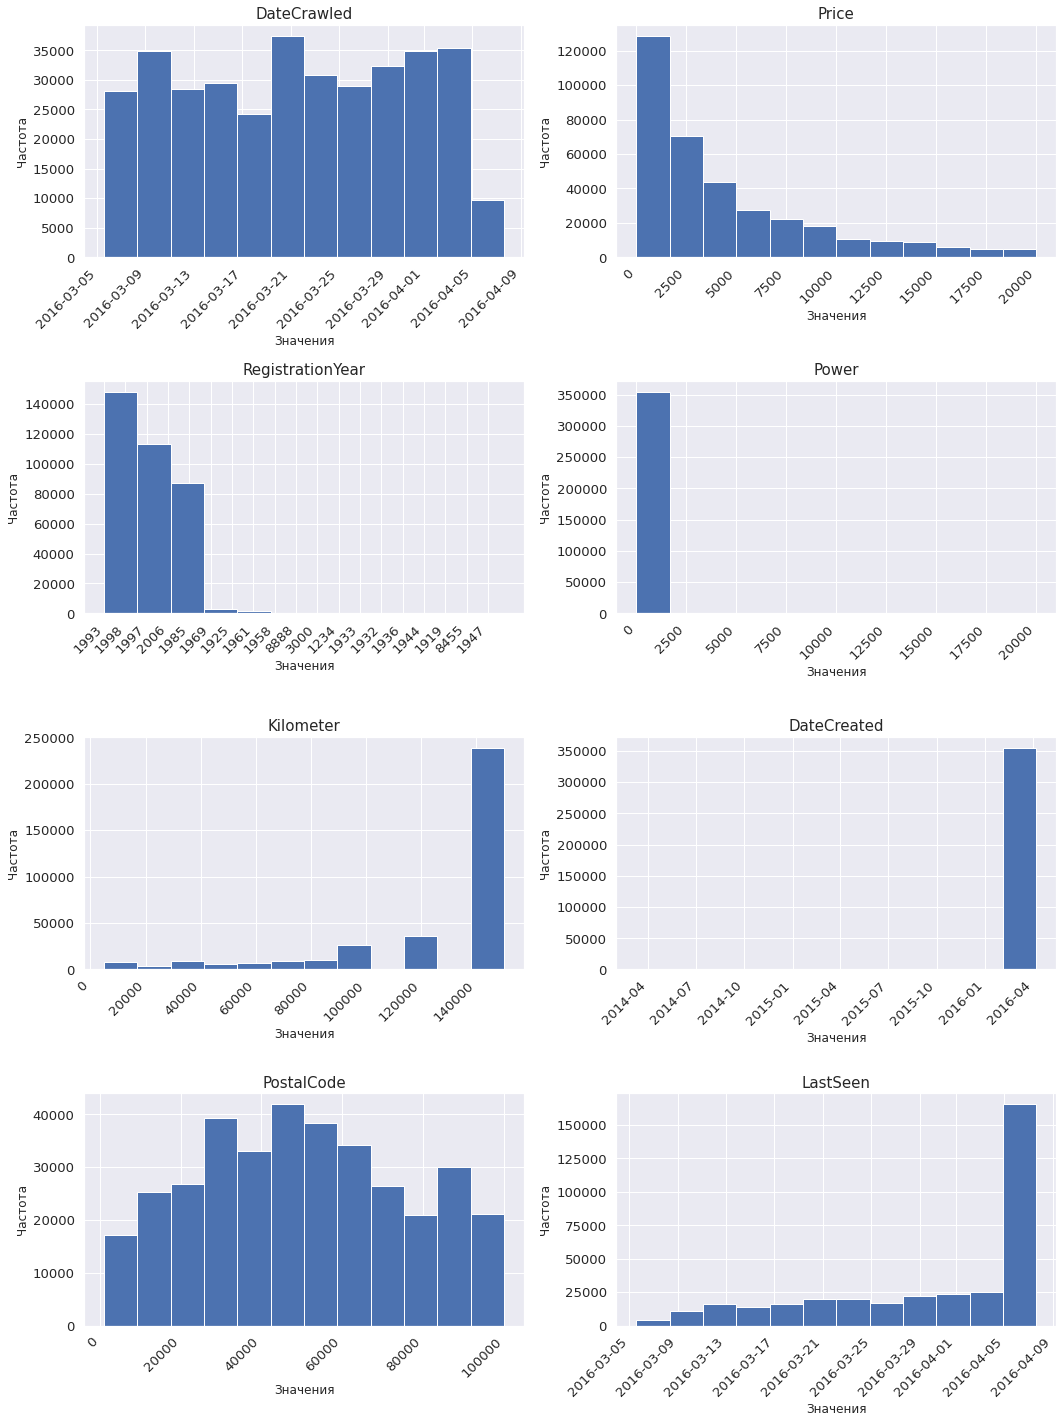

In [14]:
cat_columns = [
    'VehicleType', 
    'Gearbox', 
    'RegistrationMonth', 
    'FuelType', 
    'Repaired', 
    'NumberOfPictures', 
    'Model', 
    'Brand'
]

# Определяем количество столбцов и строк для субплотов
n_cols = 2
n_rows = (len(df.drop(cat_columns, axis=1).columns) + n_cols - 1) // n_cols

# Создаем фигуру и оси
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

# Преобразуем массив осей в плоский список для удобства итерации
axes = axes.flatten()

# Строим гистограммы для каждого столбца
for i, col in enumerate(df.drop(cat_columns, axis=1).columns):
    ax = axes[i]
    df[col].hist(ax=ax, bins=12)
    ax.set_title(col, fontsize = 15)
    ax.set_xlabel('Значения', fontsize = 12)
    ax.set_ylabel('Частота', fontsize = 12)
    # Поворачиваем метки на оси X и прореживаем их для столбцов 'RegistrationYear' и 'model'
    if col  == 'RegistrationYear':
        ticks = ax.get_xticks()
        ax.set_xticks(ticks[::8])
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# Удаляем пустые графики, если столбцов меньше, чем подграфиков
for i in range(len(df.drop(cat_columns, axis=1).columns), len(axes)):
    fig.delaxes(axes[i])

# Добавляем пространство между графиками
plt.tight_layout()
plt.show()

Как видим в данных присутсвуют категориальные парметры, отобразим их отдельно 

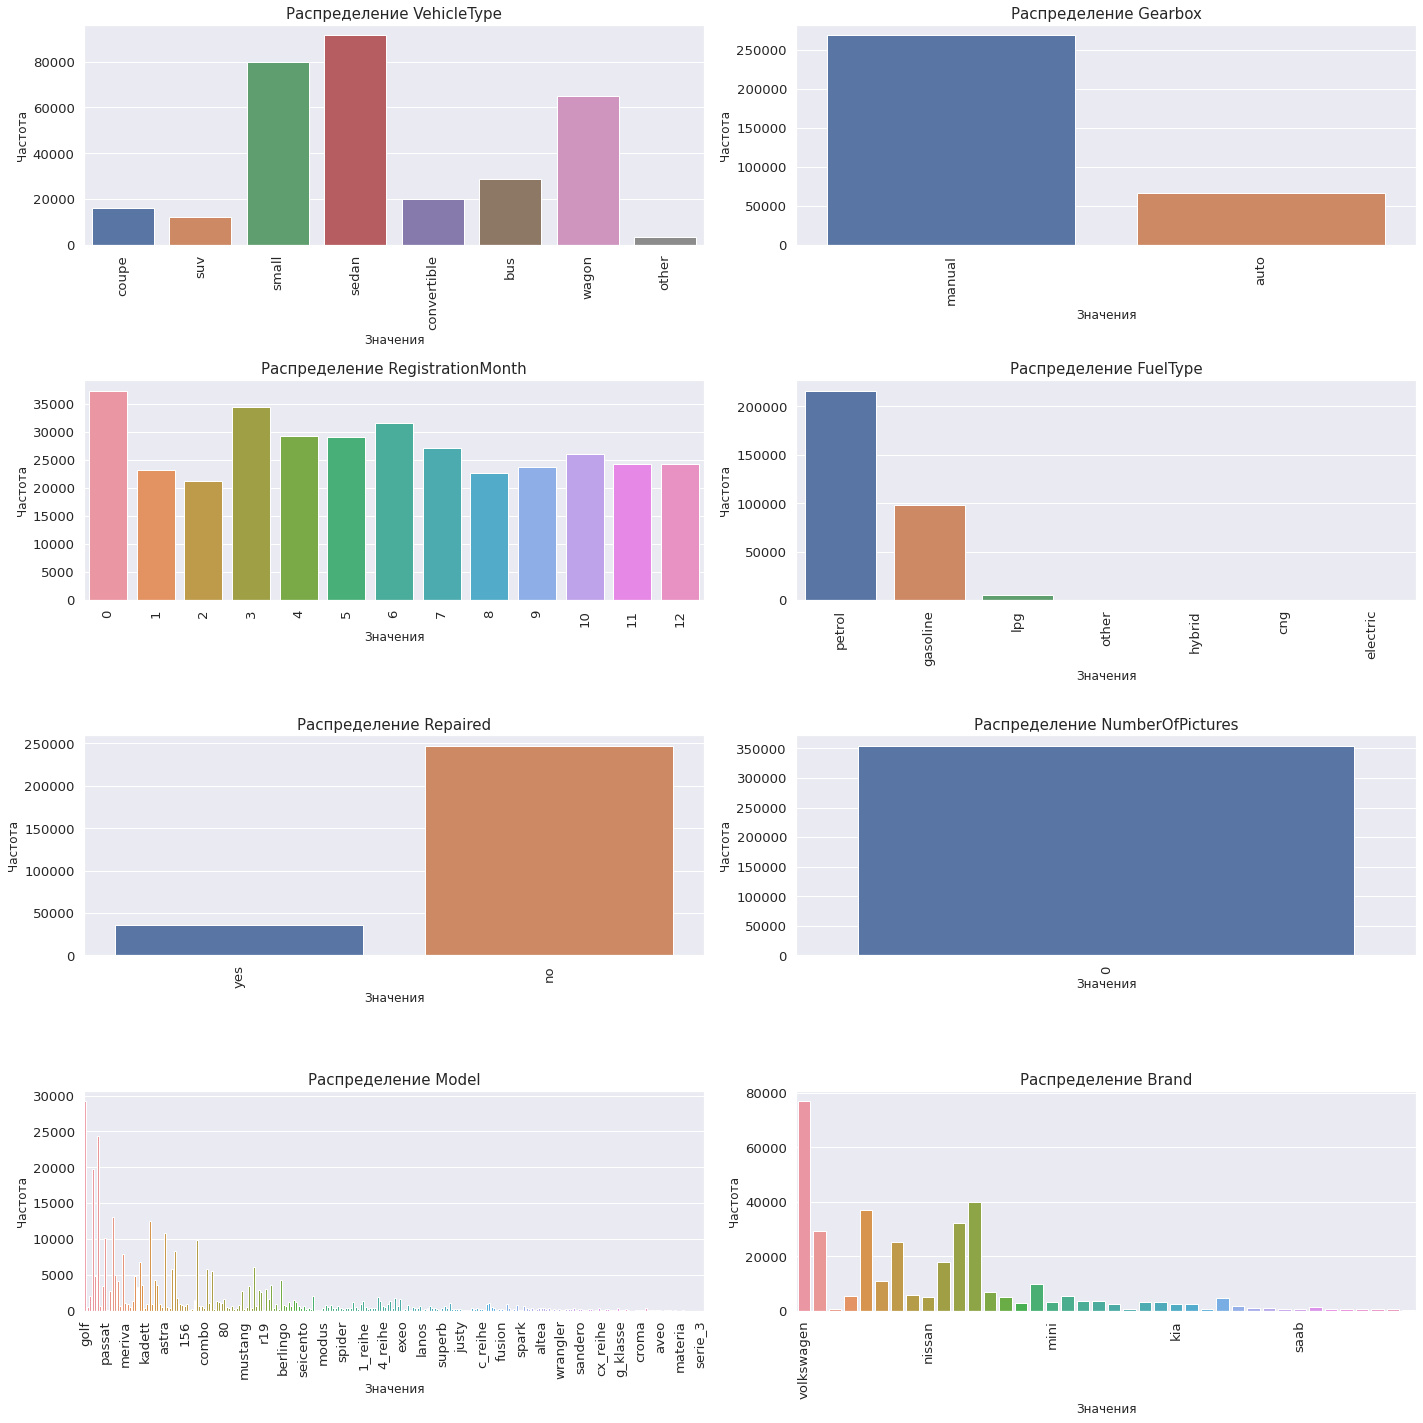

In [15]:
n_rows = (len(cat_columns) + n_cols - 1) // n_cols

# Создаем фигуру и оси
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# Преобразуем массив осей в плоский список для удобства итерации
axes = axes.flatten()

# Строим гистограммы для каждого столбца
for i, column in enumerate(cat_columns):
    ax = axes[i]
    sns.countplot(x=column, data=df, ax=ax)
    ax.set_title(f'Распределение {column}', fontsize = 15)
    ax.set_xlabel('Значения', fontsize = 12)
    ax.set_ylabel('Частота', fontsize = 12)
    if column in ['Model', 'Brand']:
        ticks = ax.get_xticks()
        ax.set_xticks(ticks[::8])
    plt.setp(ax.get_xticklabels(), rotation=90)

# Удаляем пустые графики, если столбцов меньше, чем подграфиков
for i in range(len(cat_columns), len(axes)):
    fig.delaxes(axes[i])

# Добавляем пространство между графиками
plt.tight_layout()
plt.show()

**ВЫВОД:**

В первой главе проекта мы провели следующие действия.

1. **Импорт библиотек и настройка графиков**: Были успешно импортированы все необходимые библиотеки для выполнения анализа данных, включая `pandas`, `numpy`, `matplotlib`, `seaborn`, и дополнительные библиотеки для анализа корреляций и визуализации данных. Установлены параметры для подавления предупреждений, что позволяет избежать ненужного вывода предупреждений во время работы.

2. **Загрузка данных**: Данные успешно загружены из локальных файлов. Файлы содержат информацию об продажи автомобилей с различными атрибутами. 

3. **Первичный анализ данных**: Проведён предварительный анализ структуры данных, включая проверку типов данных и наличие пропущенных значений. Обнаружено, что в данных есть пропущенные значения в нескольких столбцах, что потребует дальнейшей обработки.

4. **Гистограммы признаков**: Гистограммы были созданы для визуализации распределений различных численных признаков. Это позволяет быстро оценить форму распределений и наличие возможных выбросов.

5. **Визуализация дискретных данных**: Построены графики распределения для дискретных переменных. Эти визуализации помогают понять, какие категории наиболее часто встречаются в данных, что важно для понимания контекста данных и подготовки к моделированию. Для остальных столбцов не было построены гистограммы.

**Описание графиков:**
На предоставленных графиках показаны распределения различных характеристик автомобилей. Рассмотрим каждый из них:


1. **VehicleType** - Распределение типов автомобильных кузовов:
   - Наибольшее количество автомобилей относится к типу "sedan".
   - Также много автомобилей с типами "small"  и "wagon".
   - Наименьшее количество автомобилей представлено в типах "suv" и "other".


2. **DateCrawled, Price, RegistrationYear, Power, Kilometer, DateCreated, PostalCode, LastSeen** - Гистограммы для непрерывных переменных:
   - **DateCrawled** и **DateCreated** показывают равномерное распределение дат в пределах определенного периода времени.
   - **Price** имеет скошенное распределение, где большинство автомобилей стоят меньше 20,000 евро.
   - **RegistrationYear** показывает, что большинство автомобилей зарегистрированы после 1990 года.
   - **Power** имеет сильное скошенное распределение с большинством автомобилей мощностью до 200 л.с.
   - **Kilometer** показывает, что многие автомобили имеют пробег около 150,000 км при этом это является крайним значением, то есть можно рассматривать как 150 000 +.
   - **PostalCode** имеет равномерное распределение по всем почтовым индексам.
   - **LastSeen** имеет распределение, похожее на "DateCrawled", с пиком в конце периода.


3. **Brand** - Распределение марок автомобилей:
   - Наибольшее количество автомобилей марки "volkswagen".
   - Другие популярные марки включают "bmw", "mercedes-benz", "audi", "ford", "opel".
   
   
4. **Model** - Распределение моделей автомобилей:
   - Наиболее популярные модели включают "golf", "3er", "astra", "passat".
   - Меньшее количество моделей представлены реже, что указывает на долгий хвост распределения.


5. **NumberOfPictures** - Все записи имеют одинаковое количество фотографий (0), что указывает на неинформативность этого признака.


6. **Repaired** - Распределение статуса ремонта:
   - Большинство автомобилей не были в ремонте.


7. **FuelType** - Распределение типов топлива:
   - Большинство автомобилей работают на бензине ("petrol").
   - Значительное количество автомобилей на дизельном топливе ("gasoline").


8. **RegistrationMonth** - Распределение месяцев регистрации:
   - Распределение месяцев регистрации относительно равномерное, с небольшим увеличением в январе и снижением в феврале, при этом присутсвует 0 месяц, при этом количесвто месяцев равно 13.


9. **Gearbox** - Распределение типов коробки передач:
   - Большинство автомобилей имеют механическую коробку передач ("manual").

**Замечания:**


1. **Пропуски и аномалии**:
   - Некоторые признаки имеют пропущенные значения, такие как `VehicleType`, `Gearbox`, `Model`, `FuelType`, и `Repaired`. Необходимо будет определить стратегию для обработки этих пропусков (например, заполнение наиболее частыми значениями или удаление записей).
   - Признак `NumberOfPictures` не информативен и может быть удален из анализа.
   - Признак `RegistrationYear` имеет аномвльные даты регистрации.
   - Признак `Power` имеет аномвльные даты регистрации.


2. **Категориальные признаки**:
   - Категориальные признаки, такие как `VehicleType`, `Gearbox`, `FuelType`, и `Brand`, имеют разное количество уникальных значений, что следует учесть при кодировании.


3. **Непрерывные признаки**:
   - Непрерывные признаки имеют различные распределения, и некоторые из них (например, `Power`, `Price`) сильно скошены, что может потребовать логарифмического преобразования для нормализации распределения.


4. **Временные признаки**:
   - Признаки, связанные с датами (`DateCrawled`, `DateCreated`), показывают равномерное распределение по времени, что может указывать на постоянный поток данных за определенный период.
   
   
5. **Нарушение стиля**:
   - Названия столбцов имеют "верблюжий" стиль, необходимо его привести к "змеиному" стилю


**Дальнейшие шаги**: На следующих этапах необходимо провести детальный анализ пропущенных значений и определить стратегии их обработки. Также важно будет рассмотреть возможности создания новых признаков, основанных на имеющихся данных, и провести детальный анализ мультиколлинеарности признаков, что поможет в оптимизации выбора модели и улучшении качества предсказаний.

## Раздел. Предобработка данных

### Стиль заголовков

Переведем стиль заголоков в "змеиный" стиль

In [16]:
# Преобразование названий столбцов
df.columns = [camel_to_snake(col) for col in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Удалим неинформативные данные

Удалим столбец `number_of_pictures` и `postal_code`, но перед этим сохраним копию в новый датафрейм.
Так как нам доподлино неизвесто откуда были изъяты данные, поэтому по `postal_code` мы не сможем определить местоположение, хотя, можно предположить, что данные являются из Европейского Союза, так как данные представлены в ценовой категории `евро`. При этом основным кандидатом Является Германия, так как у нее `postal_code` имеет формат из 5 цифр.

In [17]:
df_copy = df.copy()
num_lines_start = df.shape[0]

# Удалим стобцец `number_of_pictures` и `postal_code`
df = df.drop(['number_of_pictures', 'postal_code'], axis=1)
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'last_seen'],
      dtype='object')

### Проверка на наличие явных дубликатов в данных

Посчитаем количество явных дубликатов

In [18]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 5


В данных 5 явных дубликатов, удалим их, оставив только первое его вхождение, но перед этим посмотрим на эти дубликаты

In [19]:
df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist())

date_crawled  price vehicle_type registration_year gearbox  \
18311  2016-03-07 12:00:46  10000        wagon              2013  manual   
149164 2016-03-07 12:00:46  10000        wagon              2013  manual   
88087  2016-03-08 18:42:48   1799        coupe              1999    auto   
171088 2016-03-08 18:42:48   1799        coupe              1999    auto   
41529  2016-03-18 18:46:15   1999        wagon              2001  manual   
325651 2016-03-18 18:46:15   1999        wagon              2001  manual   
90964  2016-03-28 00:56:10   1000        small              2002  manual   
231258 2016-03-28 00:56:10   1000        small              2002  manual   
187735 2016-04-03 09:01:15   4699        coupe              2003    auto   
258109 2016-04-03 09:01:15   4699        coupe              2003    auto   

        power   model  kilometer  registration_month fuel_type          brand  \
18311     184    golf      60000                   7  gasoline     volkswagen   
149164    184    golf      60000                   7  gasoline     volkswagen   
88087     193     clk      20000                   7    petrol  mercedes_benz   
171088    193     clk      20000                   7    petrol  mercedes_benz   
41529     131  passat     150000                   7  gasoline     volkswagen   
325651    131  passat     150000                   7  gasoline     volkswagen   
90964      83   other     150000                   1    petrol         suzuki   
231258     83   other     150000                   1    petrol         suzuki   
187735    218     clk     125000                   6    petrol  mercedes_benz   
258109    218     clk     125000                   6    petrol  mercedes_benz   

       repaired date_created           last_seen  
18311        no   2016-03-07 2016-03-20 12:49:27  
149164       no   2016-03-07 2016-03-20 12:49:27  
88087        no   2016-03-08 2016-03-09 09:46:57  
171088       no   2016-03-08 2016-03-09 09:46:57  
41529        no   2016-03-18 2016-03-18 18:46:15  
325651       no   2016-03-18 2016-03-18 18:46:15  
90964        no   2016-03-28 2016-03-28 08:46:21  
231258       no   2016-03-28 2016-03-28 08:46:21  
187735      yes   2016-04-03 2016-04-07 09:44:54  
258109      yes   2016-04-03 2016-04-07 09:44:54

In [20]:
df = df.drop_duplicates()
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


### Проверка на наличие ошибок в таргете "price"

Выведем данные где цена отрицательная, либо равна 0

In [21]:
print('Количество строк с нулевой ценой', df.query('price == 0').shape[0])
print('Количество строк с отричательной ценой',df.query('price < 0').shape[0])
df.query('price == 0').head()

Количество строк с нулевой ценой 10772
Количество строк с отричательной ценой 0


date_crawled  price vehicle_type registration_year gearbox  power  \
7   2016-03-21 18:54:38      0        sedan              1980  manual     50   
40  2016-03-26 22:06:17      0          NaN              1990     NaN      0   
111 2016-03-19 18:40:12      0          NaN              2017  manual      0   
115 2016-03-20 18:53:27      0        small              1999     NaN      0   
152 2016-03-11 18:55:53      0          bus              2004  manual    101   

      model  kilometer  registration_month fuel_type       brand repaired  \
7     other      40000                   7    petrol  volkswagen       no   
40    corsa     150000                   1    petrol        opel      NaN   
111    golf       5000                  12    petrol  volkswagen      NaN   
115     NaN       5000                   0    petrol  volkswagen      NaN   
152  meriva     150000                  10       lpg        opel      yes   

    date_created           last_seen  
7     2016-03-21 2016-03-25 16:47:58  
40    2016-03-26 2016-03-27 17:43:34  
111   2016-03-19 2016-04-01 08:47:05  
115   2016-03-20 2016-04-07 02:45:22  
152   2016-03-11 2016-03-12 23:47:10

Так как `price` является таргетом, заполнение нулевых данных иными данными не является целесообразным, так как вносит синтетическую составляющую, что может негативно повлиять на качество модели. Поэтому удалим эти данные.

In [22]:
print('Процентное отношение удаленных данных', round(((df.query('price == 0').shape[0] * 100) / df.shape[0]), 2))
df = df[df['price'] != 0]
print('Количество строк с нулевой ценой', df.query('price == 0').shape[0])
print('Количество строк в датафрейме', df.shape[0])

Процентное отношение удаленных данных 3.04
Количество строк с нулевой ценой 0
Количество строк в датафрейме 343592


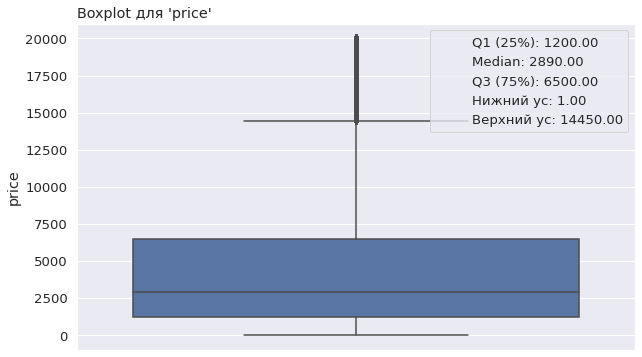

In [23]:
# Построение графика для столбца 'price'
plot_boxplot_with_nobs(df, 'price')

Мы наблюдаем выбросы начиная от 14.500 евро. 

In [24]:
df['price'].describe()

count    343592.000000
mean       4555.131516
std        4515.073215
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Также мы видим, что есть цена, которая достаточно низкая

In [25]:
df['price'].quantile([0.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

Удалим из датасета данные которые не попадаеют в 95% quantile, тем самым избавимся от выбросов в данных.

In [26]:
df = df.query('350 < price < 14800')
print('Количество оставшихся наблюдений:', df.shape[0])

Количество оставшихся наблюдений: 308165


**Вывод:**
В ходе анализа данных были выявлены строки с нулевым значением целевой переменной `price`:

- Количество строк с нулевой ценой: 10772.
- Отрицательных значений цены обнаружено не было.
- Были удалены выбросы в данных.

Поскольку `price` является целевым признаком, строки с нулевым значением были удалены, чтобы избежать негативного влияния на качество модели. 

### Определение и замена пропущенных значений

#### Определение общего количества пропущенных значений

Выведим количество пропущенных значений для каждого столбца.

In [27]:
# подсчёт пропусков
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          28096
registration_year         0
gearbox               13855
power                     0
model                 14816
kilometer                 0
registration_month        0
fuel_type             24231
brand                     0
repaired              56391
date_created              0
last_seen                 0
dtype: int64

**Вывод:**
В 5 из 14 столбцов имеются пропущенные значения.
Необходимо просмотреть все столбцы и найти по возможности оптимальные значения для заполнения пропусков или удалить такие строки.

#### Удалим те строки в которых везде есть пропуски

Посчитаем количество строк с пропусками одновременно во всех столбцах

In [28]:
# Посчитать количество строк с пропусками одновременно во всех столбцах
missing_all_three = df[['vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']].isnull().all(axis=1).sum()

# Вывод результата
print(f"Количество строк с пропусками одновременно во всех толбцах где есть пропуски: {missing_all_three}")

Количество строк с пропусками одновременно во всех толбцах где есть пропуски: 969


Удалим эти строки, так как не имеет смысл заполнять эти данные, так как большинство переменных, по которым будет расчитываться модель пустые.

In [29]:
# Удаление строк, в которых одновременно имеются пропуски в vehicle_type, gearbox, fuel_type, model и repaired
df = df.dropna(subset=['vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired'], how='all')

# Посчитать количество строк с пропусками одновременно во всех столбцах
missing_all_three = df[['vehicle_type', 'gearbox', 'fuel_type', 'model', 'repaired']].isnull().all(axis=1).sum()

# Вывод результата
print(f"Количество строк с пропусками одновременно во всех толбцах где есть пропуски: {missing_all_three}")

Количество строк с пропусками одновременно во всех толбцах где есть пропуски: 0


#### Замена пропущенных значений в столбцe `repaired`

Заменим значения в `repaired` на `unknown`, так как не неизвестно причина по которой не было указано, была ли машина в ремонте или нет. Это могло произойти по причине, того чтобы скрыть факт дтп, либо по причине банального не знания, так как владелец может быть не первым для этого авто.

In [30]:
# Замена значений в столбце repaired на 'unknown' для отсутствующих данных
df['repaired'] = df['repaired'].fillna('unknown')
print('Количество пропущенных значений в столбце "repaired":', df['repaired'].isna().sum())

Количество пропущенных значений в столбце "repaired": 0


#### Замена пропущенных значений в столбцe `model`

Проверим уникальные значения в столбце `model`

In [31]:
# Сортируем DataFrame по 'model' для каждой 'brand'
df_sorted = df.sort_values(by=['brand', 'model'])

# Группировка по brand и получение уникальных моделей для каждого бренда
unique_models_per_brand = df_sorted.groupby('brand')['model'].apply(lambda x: x.dropna().unique())

# Вывод результата
for brand, models in unique_models_per_brand.items():
    # Преобразуем все элементы в строки
    models_str = [str(model) for model in models]
    # Делаем бренд жирным шрифтом
    bold_brand = f"\033[1m{brand}\033[0m"
    print(f"{bold_brand}: {', '.join(models_str)}")

alfa_romeo: 145, 147, 156, 159, other, spider
audi: 100, 200, 80, 90, a1, a2, a3, a4, a5, a6, a8, other, q3, q5, q7, tt
bmw: 1er, 3er, 5er, 6er, 7er, i3, m_reihe, other, x_reihe, z_reihe
chevrolet: aveo, captiva, matiz, other, spark
chrysler: 300c, crossfire, grand, other, ptcruiser, voyager
citroen: berlingo, c1, c2, c3, c4, c5, other
dacia: duster, lodgy, logan, other, sandero
daewoo: kalos, lanos, matiz, nubira, other
daihatsu: charade, cuore, materia, move, other, sirion, terios
fiat: 500, bravo, croma, doblo, ducato, other, panda, punto, seicento, stilo
ford: b_max, c_max, escort, fiesta, focus, fusion, galaxy, ka, kuga, mondeo, mustang, other, s_max, transit
honda: accord, civic, cr_reihe, jazz, other
hyundai: getz, i_reihe, other, santa, tucson
jaguar: other, s_type, x_type
jeep: cherokee, grand, other, wrangler
kia: carnival, ceed, other, picanto, rio, sorento, sportage
lada: kalina, niva, other, samara
lancia: delta, elefantino, kappa, lybra, musa, other, ypsilon
land_rover: d

Заменим пропущенные значения в `model` на `other`, так как такая категория уже присутствует в данных. При этом в данных присутсвуют дубликаты, а именно: `rover` и `land_rover`, заменим `rover` на `land_rover`. Также необходимо детальнее посмотреть на данные с брендом `sonstige_autos`

In [32]:
print('Кол-во строк с неизвестным бренодом и моделью:', df.query('brand == "sonstige_autos"').shape[0])

Кол-во строк с неизвестным бренодом и моделью: 2062


Оставим их без изменения, при плохих метриках целесообразно удалить эти данные.

In [33]:
df['brand'] = df['brand'].replace('rover', 'land_rover')

Проверим на наличие дубликатов с одинаковыми моделями но разными брендами

In [34]:
print('Кол-во дубликатов:', (df[df.duplicated('model', keep=False) & ~df.duplicated(['model', 'brand'], keep=False)]).shape[0])

Кол-во дубликатов: 0


In [35]:
# Замена значений в столбце model на 'other' для отсутствующих данных
df['model'] = df['model'].fillna('other')
print('Количество пропущенных значений в столбце "model":', df['model'].isna().sum())

Количество пропущенных значений в столбце "model": 0


#### Замена пропущенных значений в столбцe `vehicle_type`

In [36]:
# Сохранение исходных значений для сравнения
df['original_vehicle_type'] = df['vehicle_type']

# Удаление строк с пропусками в критических столбцах для создания справочника
df_clean = df.dropna(subset=['vehicle_type', 'brand', 'model', 'kilometer', 'registration_year', 'fuel_type', 'power'])

# Создание справочника уникальных комбинаций и их vehicle_type
unique_combinations = df_clean[['brand', 'model', 'registration_year', 'fuel_type', 'power', 'vehicle_type']].drop_duplicates()

# Объединение с оригинальным DataFrame для заполнения пропусков
df_filled = df.merge(
    unique_combinations, 
    on=['brand', 'model', 'registration_year', 'fuel_type', 'power'], 
    how='left', 
    suffixes=('', '_filled')
)

# Заполнение пропусков в vehicle_type
df['vehicle_type'] = df['vehicle_type'].combine_first(df_filled['vehicle_type_filled'])

# Вывод данных, где произошла замена
replaced_data = df[df['original_vehicle_type'].isna() | (df['original_vehicle_type'] != df['vehicle_type'])]

# Вывод результата
replaced_data.head(10)

date_crawled  price vehicle_type registration_year gearbox  power  \
0  2016-03-24 11:52:17    480        sedan              1993  manual      0   
22 2016-03-23 14:52:51   2900        wagon              2018  manual     90   
26 2016-03-10 19:38:18   5555        sedan              2017  manual    125   
31 2016-03-29 16:57:02    899          bus              2016  manual     60   
37 2016-03-28 17:50:15   1500        sedan              2016     NaN      0   
48 2016-03-25 14:40:12   7750          bus              2017  manual     80   
51 2016-03-07 18:57:08   2000        coupe              2017  manual     90   
52 2016-04-04 10:57:36   1400        sedan              2016  manual     55   
57 2016-03-10 20:53:19   2399          NaN              2018  manual     64   
65 2016-03-28 17:41:27  10900        coupe              2017  manual    101   

     model  kilometer  registration_month fuel_type       brand repaired  \
0     golf     150000                   0    petrol  volkswagen  unknown   
22  meriva     150000                   5    petrol        opel       no   
26      c4     125000                   4       NaN     citroen       no   
31    clio     150000                   6    petrol     renault  unknown   
37  kangoo     150000                   1  gasoline     renault       no   
48    golf     100000                   1    petrol  volkswagen  unknown   
51   punto     150000                  11  gasoline        fiat      yes   
52   other       5000                   1       NaN     hyundai  unknown   
57   other     125000                   3       NaN        seat       no   
65   astra      50000                   3       NaN        opel       no   

   date_created           last_seen original_vehicle_type  
0    2016-03-24 2016-04-07 03:16:57                   NaN  
22   2016-03-23 2016-03-31 01:16:33                   NaN  
26   2016-03-10 2016-03-16 09:16:46                   NaN  
31   2016-03-29 2016-03-29 17:43:07                   NaN  
37   2016-03-28 2016-03-30 09:18:02                   NaN  
48   2016-03-25 2016-03-31 21:47:44                   NaN  
51   2016-03-07 2016-03-07 18:57:08                   NaN  
52   2016-04-04 2016-04-06 12:45:43                   NaN  
57   2016-03-10 2016-03-25 10:17:37                   NaN  
65   2016-03-28 2016-04-06 23:15:52                   NaN

In [37]:
print('Количество пропущенных значений в столбце "vehicle_type":', df['vehicle_type'].isna().sum())

Количество пропущенных значений в столбце "vehicle_type": 1520


#### Замена пропущенных значений в столбцe `gearbox`

Аналогично поступим и с `gearbox`

In [38]:
# Сохранение исходных значений для сравнения
df['original_gearbox'] = df['gearbox']

# Удаление строк с пропусками в критических столбцах для создания справочника
df_clean = df.dropna(
    subset=['gearbox', 'brand', 'model', 'kilometer', 'registration_year', 'fuel_type', 'power', 'vehicle_type']
)

# Создание справочника уникальных комбинаций и их gearbox
unique_combinations = df_clean[
    ['brand', 'model', 'registration_year', 'fuel_type', 'power', 'gearbox', 'vehicle_type']
].drop_duplicates()

# Объединение с оригинальным DataFrame для заполнения пропусков
df_filled = df.merge(
    unique_combinations, 
    on=['brand', 'model', 'registration_year', 'fuel_type', 'power'], 
    how='left', 
    suffixes=('', '_filled')
)

# Заполнение пропусков в vehicle_type
df['gearbox'] = df['gearbox'].combine_first(df_filled['gearbox_filled'])

# Вывод данных, где произошла замена
replaced_data = df[df['original_gearbox'].isna() | (df['original_gearbox'] != df['gearbox'])]

# Вывод результата
replaced_data.head(10)

date_crawled  price vehicle_type registration_year gearbox  power  \
15  2016-03-11 21:39:15    450        small              1910  manual      0   
37  2016-03-28 17:50:15   1500        sedan              2016  manual      0   
69  2016-04-01 11:56:40   1200        coupe              2001     NaN      0   
94  2016-03-28 16:37:43   8390        small              2009  manual      0   
130 2016-03-20 18:47:31   3390        coupe              2000    auto      0   
151 2016-03-27 20:47:22   6799        small              2009     NaN     60   
161 2016-03-28 10:50:04   1495        wagon              2001  manual     64   
186 2016-03-16 15:51:08  14000        sedan              2008  manual    235   
197 2016-03-08 09:56:53   3200        wagon              2006  manual      0   
208 2016-03-13 00:56:50   2250        small              2001    auto     41   

        model  kilometer  registration_month fuel_type       brand repaired  \
15         ka       5000                   0    petrol        ford  unknown   
37     kangoo     150000                   1  gasoline     renault       no   
69      astra     150000                   0       NaN        opel  unknown   
94   insignia     150000                   0       NaN        opel  unknown   
130       3er     150000                   2       NaN         bmw  unknown   
151     other      20000                   5    petrol  volkswagen       no   
161     other     150000                   9  gasoline  volkswagen  unknown   
186     other     150000                   0       NaN         bmw       no   
197        a3     150000                  11  gasoline        audi       no   
208    fortwo     150000                  10  gasoline       smart       no   

    date_created           last_seen original_vehicle_type original_gearbox  
15    2016-03-11 2016-03-19 08:46:47                 small              NaN  
37    2016-03-28 2016-03-30 09:18:02                   NaN              NaN  
69    2016-04-01 2016-04-07 08:46:07                 coupe              NaN  
94    2016-03-28 2016-03-30 07:44:59                   NaN              NaN  
130   2016-03-20 2016-03-28 19:48:42                   NaN              NaN  
151   2016-03-27 2016-03-27 20:47:22                 small              NaN  
161   2016-03-28 2016-04-04 11:45:46                 wagon              NaN  
186   2016-02-12 2016-04-07 14:56:12                 sedan              NaN  
197   2016-03-08 2016-03-08 09:56:53                 wagon              NaN  
208   2016-03-13 2016-03-30 01:47:18                 small              NaN

In [39]:
print('Количество пропущенных значений в столбце "gearbox":', df['gearbox'].isna().sum())

Количество пропущенных значений в столбце "gearbox": 321


#### Замена пропущенных значений в столбцe `fuel_type`

Аналогично поступим и с `fuel_type`

In [40]:
# Сохранение исходных значений для сравнения
df['original_fuel_type'] = df['fuel_type']

# Удаление строк с пропусками в критических столбцах для создания справочника
df_clean = df.dropna(
    subset=['gearbox', 'brand', 'model', 'kilometer', 'registration_year', 'fuel_type', 'power', 'vehicle_type']
)

# Создание справочника уникальных комбинаций и их gearbox
unique_combinations = df_clean[
    ['brand', 'model', 'registration_year', 'fuel_type', 'power', 'gearbox', 'vehicle_type']
].drop_duplicates()

# Объединение с оригинальным DataFrame для заполнения пропусков
df_filled = df.merge(
    unique_combinations, 
    on=['brand', 'model', 'registration_year', 'vehicle_type', 'power'], 
    how='left', 
    suffixes=('', '_filled')
)

# Заполнение пропусков в vehicle_type
df['fuel_type'] = df['fuel_type'].combine_first(df_filled['fuel_type_filled'])

# Вывод данных, где произошла замена
replaced_data = df[df['original_fuel_type'].isna() | (df['original_fuel_type'] != df['fuel_type'])]

# Вывод результата
replaced_data.head(10)

date_crawled  price vehicle_type registration_year gearbox  power  \
9  2016-03-17 10:53:50    999        small              1998  manual    101   
13 2016-03-21 21:37:40   2500        wagon              2004  manual    131   
26 2016-03-10 19:38:18   5555        sedan              2017  manual    125   
36 2016-03-11 11:50:37   1600        other              1991  manual     75   
41 2016-03-30 20:38:20   7500        sedan              2002    auto    306   
52 2016-04-04 10:57:36   1400        sedan              2016  manual     55   
54 2016-03-17 07:56:40   4700        wagon              2005  manual      0   
57 2016-03-10 20:53:19   2399          NaN              2018  manual     64   
65 2016-03-28 17:41:27  10900        coupe              2017  manual    101   
69 2016-04-01 11:56:40   1200        coupe              2001     NaN      0   

       model  kilometer  registration_month fuel_type          brand repaired  \
9       golf     150000                   0       lpg     volkswagen  unknown   
13    passat     150000                   2    petrol     volkswagen       no   
26        c4     125000                   4    petrol        citroen       no   
36    kadett      70000                   0    petrol           opel  unknown   
41  e_klasse     150000                   4    petrol  mercedes_benz  unknown   
52     other       5000                   1  gasoline        hyundai  unknown   
54    signum     150000                   0    petrol           opel       no   
57     other     125000                   3    petrol           seat       no   
65     astra      50000                   3       lpg           opel       no   
69     astra     150000                   0    petrol           opel  unknown   

   date_created           last_seen original_vehicle_type original_gearbox  \
9    2016-03-17 2016-03-31 17:17:06                 small           manual   
13   2016-03-21 2016-03-23 02:50:54                 wagon           manual   
26   2016-03-10 2016-03-16 09:16:46                   NaN           manual   
36   2016-03-11 2016-04-07 03:46:09                 other           manual   
41   2016-03-30 2016-04-03 11:44:49                 sedan             auto   
52   2016-04-04 2016-04-06 12:45:43                   NaN           manual   
54   2016-03-17 2016-04-04 04:17:32                 wagon           manual   
57   2016-03-10 2016-03-25 10:17:37                   NaN           manual   
65   2016-03-28 2016-04-06 23:15:52                   NaN           manual   
69   2016-04-01 2016-04-07 08:46:07                 coupe              NaN   

   original_fuel_type  
9                 NaN  
13                NaN  
26                NaN  
36                NaN  
41                NaN  
52                NaN  
54                NaN  
57                NaN  
65                NaN  
69                NaN

In [41]:
print('Количество пропущенных значений в столбце "fuel_type":', df['fuel_type'].isna().sum())

Количество пропущенных значений в столбце "fuel_type": 376


Проверим количество пропущенных значений

In [42]:
# подсчёт пропусков
df.isna().sum()

date_crawled                 0
price                        0
vehicle_type              1520
registration_year            0
gearbox                    321
power                        0
model                        0
kilometer                    0
registration_month           0
fuel_type                  376
brand                        0
repaired                     0
date_created                 0
last_seen                    0
original_vehicle_type    27127
original_gearbox         12886
original_fuel_type       23262
dtype: int64

Так как данных с пропусками осталось мало, удалим эти строки

In [43]:
df = df.drop(['original_vehicle_type', 'original_gearbox', 'original_fuel_type'], axis=1)
df = df.dropna()

# подсчёт пропусков
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
last_seen             0
dtype: int64

In [44]:
df.duplicated().sum()

0

In [45]:
round(100 - (df.shape[0] * 100 / num_lines_start), 2)

13.93

**Вывод:** После очитки данных от пропусков, датафрейм "похудел" чуть меньше чем на 14%

### Проверка на наличие ошибок в "registration_year"

В столбце `registration_year` как и ранее было указано, наблюдаются аномальные значения в годах. Выведем эти данные

In [46]:
df['registration_year'].sort_values().unique()

array(['1000', '1001', '1039', '1234', '1400', '1500', '1600', '1602',
       '1800', '1910', '1923', '1925', '1928', '1929', '1930', '1931',
       '1932', '1934', '1935', '1936', '1937', '1938', '1940', '1941',
       '1942', '1943', '1944', '1945', '1946', '1948', '1949', '1950',
       '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958',
       '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982',
       '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
       '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2066', '2290', '2500',
       '2800', '2900', '3000', '3700', '4000', '4500', '4800', '5000',
      

Определим крайнюю дату скачивания данных.

In [47]:
max_data = df['date_crawled'].max()
max_data

Timestamp('2016-04-07 14:36:58')

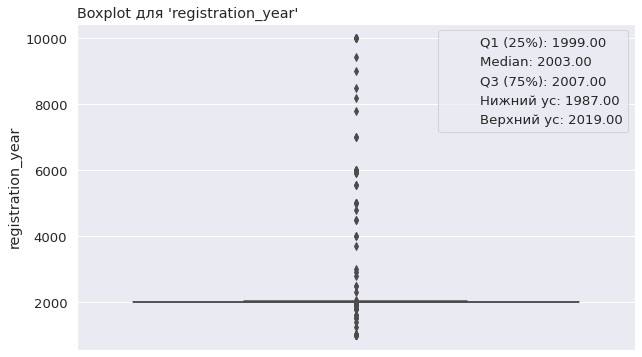

count    305001.000000
mean       2003.491143
std          51.464372
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: registration_year, dtype: float64

In [48]:
# Преобразование значений в числовой тип
df['registration_year'] = pd.to_numeric(df['registration_year'], errors='coerce')

# Построение графика для столбца 'price'
plot_boxplot_with_nobs(df, 'registration_year')

df['registration_year'].describe()

In [49]:
print('Количество машин младше 1987 года:', df.query('registration_year < 1987').shape[0])
print('Количество машин старше 2016 года:', df.query('registration_year > 2016').shape[0])

Количество машин младше 1987 года: 5088
Количество машин старше 2016 года: 12119


Для корректировки значений в столбце RegistrationYear на основе других признаков (пробег, марка, модель, мощность, тип топлива, типкоробки передач).

In [50]:
# Сохранение исходных значений для сравнения
df['original_registration_year'] = df['registration_year']

# Заменяем нереалистичные значения на NaN
df.loc[(df['registration_year'] < 1987) | (df['registration_year'] > 2016), 'registration_year'] = np.nan

# Удаление строк с пропусками в критических столбцах для создания справочника
df_clean = df.dropna(
    subset=['gearbox', 'brand', 'model', 'kilometer', 'registration_year', 'fuel_type', 'power', 'vehicle_type']
)

# Создание справочника уникальных комбинаций и их registration_year
unique_combinations = df_clean[
    ['brand', 'model', 'registration_year', 'fuel_type', 'power', 'gearbox', 'vehicle_type']
].drop_duplicates()

# Объединение с оригинальным DataFrame для заполнения пропусков
df_filled = df.merge(
    unique_combinations, 
    on=['brand', 'model', 'fuel_type', 'vehicle_type', 'power'], 
    how='left', 
    suffixes=('', '_filled')
)

# Заполнение пропусков в vehicle_type
df['registration_year'] = df['registration_year'].combine_first(df_filled['registration_year_filled'])

# Вывод данных, где произошла замена
replaced_data = df[df['original_registration_year'].isna() | (df['original_registration_year'] != df['registration_year'])]

# Вывод результата
replaced_data.head(10)

date_crawled  price vehicle_type  registration_year gearbox  power  \
15  2016-03-11 21:39:15    450        small             1994.0  manual      0   
22  2016-03-23 14:52:51   2900        wagon             1999.0  manual     90   
26  2016-03-10 19:38:18   5555        sedan             2004.0  manual    125   
28  2016-03-09 11:56:38   1990          bus             2013.0  manual     50   
39  2016-03-25 15:50:30   1500          bus             1997.0  manual     70   
48  2016-03-25 14:40:12   7750          bus             2007.0  manual     80   
51  2016-03-07 18:57:08   2000        coupe             2005.0  manual     90   
65  2016-03-28 17:41:27  10900        coupe             1995.0  manual    101   
91  2016-04-02 23:25:25   1222        sedan             2007.0    auto    180   
155 2016-03-09 12:53:53  14500        sedan             2010.0  manual    136   

           model  kilometer  registration_month fuel_type          brand  \
15            ka       5000                   0    petrol           ford   
22        meriva     150000                   5    petrol           opel   
26            c4     125000                   4    petrol        citroen   
28   transporter       5000                   1    petrol     volkswagen   
39         other     150000                   8  gasoline  mercedes_benz   
48          golf     100000                   1    petrol     volkswagen   
51         punto     150000                  11  gasoline           fiat   
65         astra      50000                   3       lpg           opel   
91         other     150000                   3    petrol           opel   
155     sportage     125000                   5  gasoline            kia   

    repaired date_created           last_seen  original_registration_year  
15   unknown   2016-03-11 2016-03-19 08:46:47                        1910  
22        no   2016-03-23 2016-03-31 01:16:33                        2018  
26        no   2016-03-10 2016-03-16 09:16:46                        2017  
28        no   2016-03-09 2016-03-10 07:44:33                        1981  
39        no   2016-03-25 2016-03-27 03:17:02                        1984  
48   unknown   2016-03-25 2016-03-31 21:47:44                        2017  
51       yes   2016-03-07 2016-03-07 18:57:08                        2017  
65        no   2016-03-28 2016-04-06 23:15:52                        2017  
91   unknown   2016-04-02 2016-04-06 14:44:57                        1984  
155       no   2016-03-09 2016-04-05 23:45:15                        2017

In [51]:
print('Количество пропущенных значений в столбце "registration_year":', df['registration_year'].isna().sum())

Количество пропущенных значений в столбце "registration_year": 28


Удалим оставшиеся строки с пропусками

In [52]:
df = df.drop('original_registration_year', axis=1)
df = df.dropna()

df['registration_year'] = round(df['registration_year'], 0).astype(int)

# подсчёт пропусков
print('Количество пропущенных значений в столбце "registration_year":', df['registration_year'].isna().sum())

Количество пропущенных значений в столбце "registration_year": 0


**Вывод:**

1. **Обнаруженные проблемы**:
   - Аномальные значения годов регистрации, такие как 1000, 9999 и другие.
   - Даты регистрации вне разумного диапазона (до 1987 года и после 2016 года).
   
   
2. **Выполненные действия**:
   - Преобразованы значения в числовой тип для дальнейшего анализа.
   - Нереалистичные значения (меньше 1987 года и больше 2016 года) заменены на NaN.
   - Созданы справочники уникальных комбинаций параметров автомобилей для заполнения пропусков.
   - Заполнены пропуски на основе справочников и удалены строки с критическими пропусками.

### Проверка на наличие ошибок в "power"

Проверим данные с помощью гистограммы

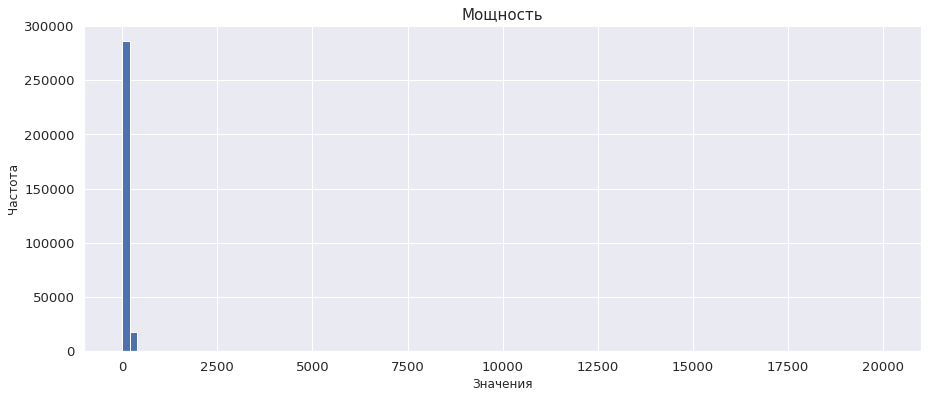

In [53]:
# Создание подграфика
fig, ax = plt.subplots(figsize=(15, 6))

# Построение гистограммы
df['power'].hist(ax=ax, bins=100)

# Установка заголовка и меток осей
ax.set_title('Мощность', fontsize=15)
ax.set_xlabel('Значения', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)

# Отображение графика
plt.show()

Есть достаточно большой хвост справа, посмотри на него по ближе

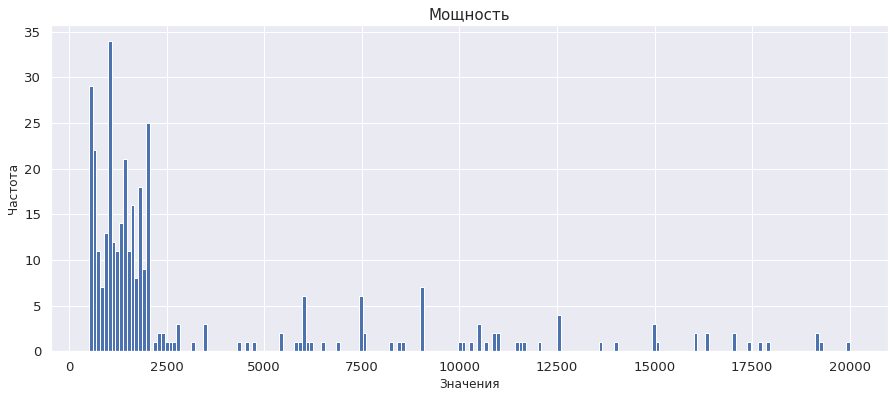

In [54]:
# Создание подграфика
fig, ax = plt.subplots(figsize=(15, 6))

# Построение гистограммы
df['power'][df['power'] > 500].hist(ax=ax, bins=200)

# Установка заголовка и меток осей
ax.set_title('Мощность', fontsize=15)
ax.set_xlabel('Значения', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)

# Отображение графика
plt.show()

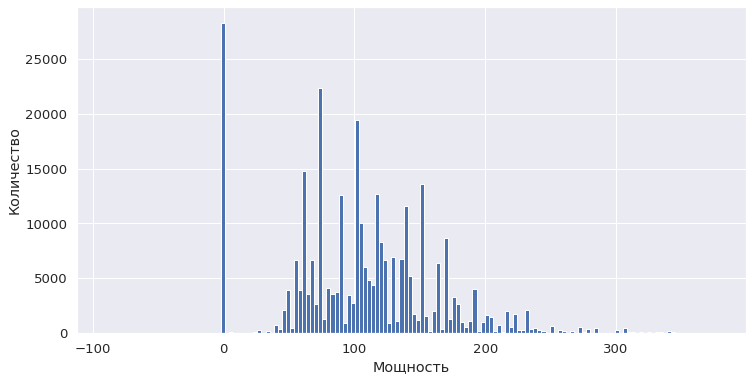

In [55]:
Q1 = df['power'].quantile(0.10)
Q3 = df['power'].quantile(0.90)
IQR = Q3 - Q1

df['power'].plot(kind = 'hist', bins = 150, grid=True, range=(Q1 - IQR, Q3 + 1.5 * IQR), figsize=(12, 6))
plt.xlabel('Мощность')
plt.ylabel('Количество')
plt.show()

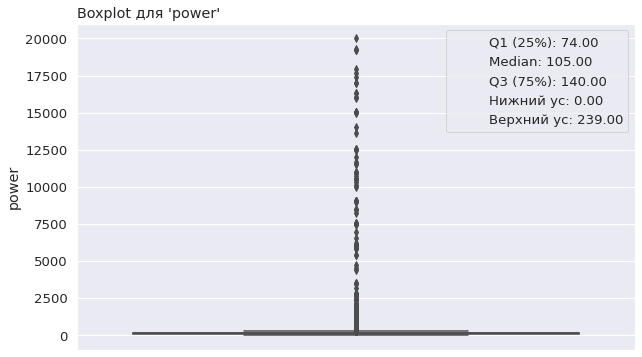

count    304973.000000
mean        110.744181
std         189.507273
min           0.000000
25%          74.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

In [56]:
# Построение графика для столбца 'price'
plot_boxplot_with_nobs(df, 'power')

df['power'].describe()

In [57]:
print('Количество данных в которых мощность авто больше 350 л.с:', df.query('power > 400').shape[0])

Количество данных в которых мощность авто больше 350 л.с: 465


In [58]:
print('Количество данных в которых мощность равна 0 л.с:', df.query('power == 0').shape[0])

Количество данных в которых мощность равна 0 л.с: 28289


Аналогично как и для `registration_year` исправим эти ошибки

In [59]:
# Сохранение исходных значений для сравнения
df['original_power'] = df['power']

# Заменяем нереалистичные значения на NaN
df.loc[(df['power'] == 0) | (df['power'] > 400), 'power'] = np.nan

# Удаление строк с пропусками в критических столбцах для создания справочника
df_clean = df.dropna(
    subset=['gearbox', 'brand', 'model', 'kilometer', 'registration_year', 'fuel_type', 'power', 'vehicle_type']
)

# Создание справочника уникальных комбинаций и их power
unique_combinations = df_clean[
    ['brand', 'model', 'registration_year', 'fuel_type', 'power', 'gearbox', 'vehicle_type']
].drop_duplicates()

# Объединение с оригинальным DataFrame для заполнения пропусков
df_filled = df.merge(
    unique_combinations, 
    on=['brand', 'model', 'fuel_type', 'vehicle_type', 'registration_year'], 
    how='left', 
    suffixes=('', '_filled')
)

# Заполнение пропусков в vehicle_type
df['power'] = df['power'].combine_first(df_filled['power_filled'])

# Вывод данных, где произошла замена
replaced_data = df[df['original_power'].isna() | (df['original_power'] != df['power'])]

# Вывод результата
replaced_data.head(10)

date_crawled  price vehicle_type  registration_year gearbox  power  \
0   2016-03-24 11:52:17    480        sedan               1993  manual   75.0   
15  2016-03-11 21:39:15    450        small               1994  manual  211.0   
37  2016-03-28 17:50:15   1500        sedan               2016  manual  102.0   
54  2016-03-17 07:56:40   4700        wagon               2005  manual  193.0   
55  2016-03-26 10:39:35    550        wagon               1999  manual  170.0   
70  2016-03-08 01:36:42    800        small               1993  manual   75.0   
90  2016-03-23 11:53:21   2400        sedan               2003  manual  150.0   
94  2016-03-28 16:37:43   8390        small               2009  manual   84.0   
98  2016-03-11 19:00:25   4290          bus               2008  manual  140.0   
126 2016-03-20 10:54:17   8000  convertible               2009  manual   85.0   

        model  kilometer  registration_month fuel_type       brand repaired  \
0        golf     150000                   0    petrol  volkswagen  unknown   
15         ka       5000                   0    petrol        ford  unknown   
37     kangoo     150000                   1  gasoline     renault       no   
54     signum     150000                   0    petrol        opel       no   
55      astra     150000                   8  gasoline        opel      yes   
70       polo     150000                   3    petrol  volkswagen       no   
90         a4     150000                   9  gasoline        audi  unknown   
94   insignia     150000                   0    petrol        opel  unknown   
98      combo     150000                   2  gasoline        opel       no   
126      golf     100000                  10    petrol  volkswagen       no   

    date_created           last_seen  original_power  
0     2016-03-24 2016-04-07 03:16:57               0  
15    2016-03-11 2016-03-19 08:46:47               0  
37    2016-03-28 2016-03-30 09:18:02               0  
54    2016-03-17 2016-04-04 04:17:32               0  
55    2016-03-26 2016-04-01 23:17:27               0  
70    2016-03-08 2016-04-05 23:46:00               0  
90    2016-03-23 2016-03-23 11:53:21               0  
94    2016-03-28 2016-03-30 07:44:59               0  
98    2016-03-11 2016-04-05 22:45:32               0  
126   2016-03-20 2016-04-06 07:45:51               0

In [60]:
print('Количество пропущенных значений в столбце "power":', df['power'].isna().sum())

Количество пропущенных значений в столбце "power": 23


Удалим оставшиеся строки с пропусками

In [61]:
df = df.drop('original_power', axis=1)
df = df.dropna()

# подсчёт пропусков
print('Количество пропущенных значений в столбце "power":', df['power'].isna().sum())

Количество пропущенных значений в столбце "power": 0


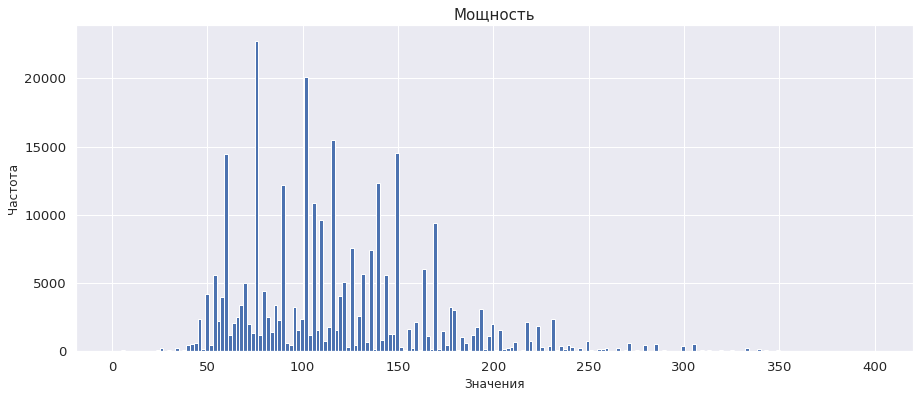

In [62]:
# Создание подграфика
fig, ax = plt.subplots(figsize=(15, 6))

# Построение гистограммы
df['power'].hist(ax=ax, bins=200)

# Установка заголовка и меток осей
ax.set_title('Мощность', fontsize=15)
ax.set_xlabel('Значения', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)

# Отображение графика
plt.show()

Проверим данные с малой мощностью, беря во внимание, что заместо мощность могли указать объем двигателя в литрах.

In [63]:
display(df.query('power <= 12').head())
print('Количество строк, где мощность крайне мала для автомобиля (меньше 40):', df.query('power <= 40').shape[0])

date_crawled  price vehicle_type  registration_year gearbox  \
431   2016-03-20 20:45:27   3950        small               2004    auto   
3349  2016-03-29 17:37:58   1990        small               2004  manual   
5376  2016-03-22 11:48:57  14500        coupe               2011    auto   
9561  2016-04-04 07:58:34   9000        sedan               2009  manual   
11852 2016-03-18 08:36:43   1999        coupe               1998  manual   

       power   model  kilometer  registration_month fuel_type           brand  \
431      5.0   other      70000                   5  gasoline  sonstige_autos   
3349     7.0    polo     150000                   5  gasoline      volkswagen   
5376    10.0  sharan     150000                   0  gasoline      volkswagen   
9561     2.0      a4       5000                  12  gasoline            audi   
11852   10.0   other     150000                   6    petrol  sonstige_autos   

      repaired date_created           last_seen  
431         no   2016-03-20 2016-04-03 04:17:08  
3349        no   2016-03-29 2016-04-02 05:16:40  
5376   unknown   2016-03-22 2016-03-23 19:18:20  
9561   unknown   2016-04-04 2016-04-06 10:17:01  
11852  unknown   2016-03-18 2016-03-21 06:47:31

Количество строк, где мощность крайне мала для автомобиля (меньше 40): 1703


В данных явно присутсвует данная ошибка. Вот например строка с индексом `9561` audi a4 с мощностью в 2.0 (это указан объем двигателя). Так как данных мало, удалим эти значения.

In [64]:
df['power'] = df['power'].astype(int)
df = df[df['power'] > 40]
print('Количество строк, где мощность крайне мала для автомобиля (меньше 40):', df.query('power <= 40').shape[0])

Количество строк, где мощность крайне мала для автомобиля (меньше 40): 0


**Вывод:**

1. **Обнаруженные проблемы**:
   - Много записей с нулевой мощностью (28289).
   - Аномально высокие значения мощности (>400 л.с.).
   - Низкие значения мощности (<40 л.с.), вероятно, указаны ошибочно как объем двигателя.


2. **Выполненные действия**:
   - Значения мощности 0 и > 400 заменены на аналогичные данные из других строк.
   - Строки с мощностью < 40 удалены.


Эти шаги улучшили качество данных, подготовив их для дальнейшего моделирования.

### Проверка на наличие ошибок в "kilometer"

Прверим данные в столбце `kilometer`

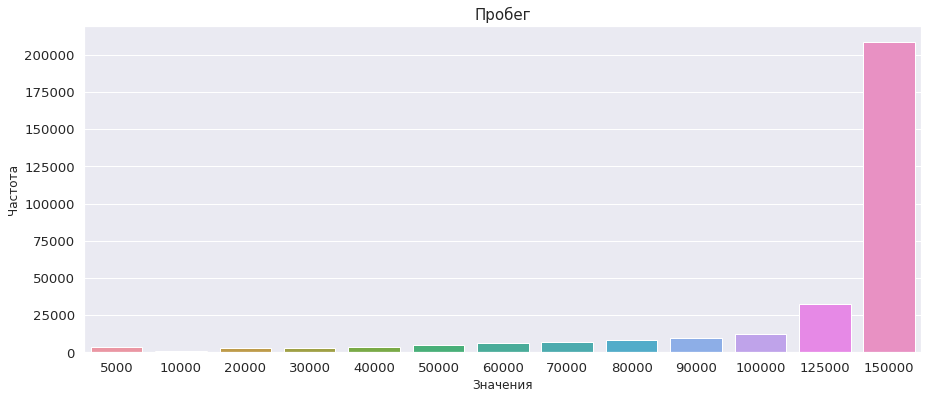

In [65]:
# Создание подграфика
fig, ax = plt.subplots(figsize=(15, 6))

# Построение гистограммы
sns.countplot(x='kilometer', data=df, ax=ax)

# Установка заголовка и меток осей
ax.set_title('Пробег', fontsize=15)
ax.set_xlabel('Значения', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)

# Отображение графика
plt.show()

Данные явно представлены в виде категорий

In [66]:
print(df['kilometer'].sort_values().unique())
print('Количество уникальных категорий в пробеге:', df['kilometer'].nunique())

[  5000  10000  20000  30000  40000  50000  60000  70000  80000  90000
 100000 125000 150000]
Количество уникальных категорий в пробеге: 13


In [67]:
df['kilometer'] = df['kilometer'].astype('category')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303247 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        303247 non-null  datetime64[ns]
 1   price               303247 non-null  int64         
 2   vehicle_type        303247 non-null  object        
 3   registration_year   303247 non-null  int64         
 4   gearbox             303247 non-null  object        
 5   power               303247 non-null  int64         
 6   model               303247 non-null  object        
 7   kilometer           303247 non-null  category      
 8   registration_month  303247 non-null  int64         
 9   fuel_type           303247 non-null  object        
 10  brand               303247 non-null  object        
 11  repaired            303247 non-null  object        
 12  date_created        303247 non-null  datetime64[ns]
 13  last_seen           303247 no

**Вывод:** Данные пробега были переведены в тип категорию. Также целесообразно уменьшить количество категорий до трех, так как в данных явно присутсвует дисбаланс в категориях.

### Проверка на наличие ошибок в "registration_month"

Как ранее было выявлено в данных присутсвует 0 месяц вновь посмотрим на эти данные

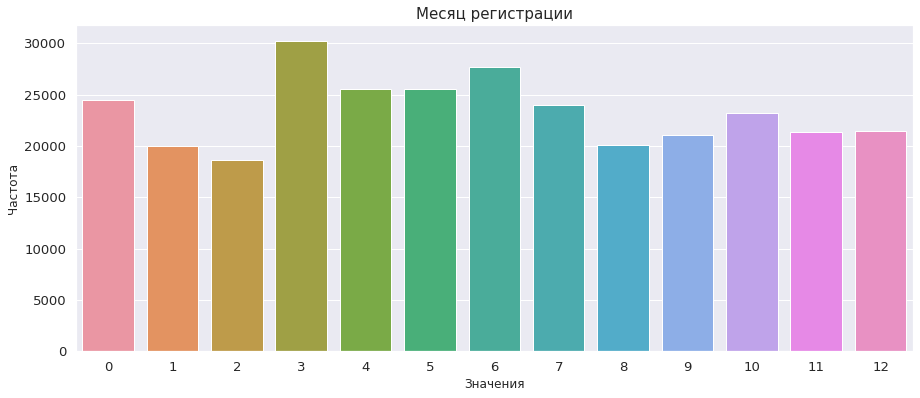

In [69]:
# Создание подграфика
fig, ax = plt.subplots(figsize=(15, 6))

# Построение гистограммы
sns.countplot(x='registration_month', data=df, ax=ax)

# Установка заголовка и меток осей
ax.set_title('Месяц регистрации', fontsize=15)
ax.set_xlabel('Значения', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)

# Отображение графика
plt.show()

Скорее всего это не свидетельствует о том, что это месяц январь, так как данные равномерно распределены, скорее всего это свидетельсвует о том, что 0 появлися в виду отсутствия месяца регистрации. Распределим этот столбец равномерно по остальным столбцам.

In [70]:
# Определение строк, где registration_month == 0
zero_months_idx = df[df['registration_month'] == 0].index
non_zero_months = df[df['registration_month'] != 0]

# Количество месяцев (без учета нулевого месяца)
months = np.arange(1, 13)

# Равномерное распределение строк с registration_month == 0 по остальным месяцам
random_months = np.random.choice(months, size=len(zero_months_idx))

# Обновление столбца registration_month в строках с нулевым месяцем
df.loc[zero_months_idx, 'registration_month'] = random_months

# Вывод результата
df.head()

date_crawled  price vehicle_type  registration_year gearbox  power  \
0 2016-03-24 11:52:17    480        sedan               1993  manual     75   
2 2016-03-14 12:52:21   9800          suv               2004    auto    163   
3 2016-03-17 16:54:04   1500        small               2001  manual     75   
4 2016-03-31 17:25:20   3600        small               2008  manual     69   
5 2016-04-04 17:36:23    650        sedan               1995  manual    102   

   model kilometer  registration_month fuel_type       brand repaired  \
0   golf    150000                   9    petrol  volkswagen  unknown   
2  grand    125000                   8  gasoline        jeep  unknown   
3   golf    150000                   6    petrol  volkswagen       no   
4  fabia     90000                   7  gasoline       skoda       no   
5    3er    150000                  10    petrol         bmw      yes   

  date_created           last_seen  
0   2016-03-24 2016-04-07 03:16:57  
2   2016-03-14 2016-04-05 12:47:46  
3   2016-03-17 2016-03-17 17:40:17  
4   2016-03-31 2016-04-06 10:17:21  
5   2016-04-04 2016-04-06 19:17:07

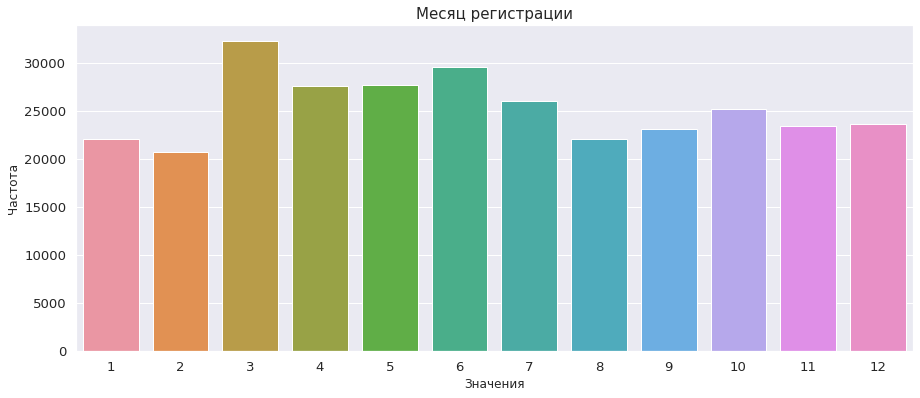

In [71]:
# Создание подграфика
fig, ax = plt.subplots(figsize=(15, 6))

# Построение гистограммы
sns.countplot(x='registration_month', data=df, ax=ax)

# Установка заголовка и меток осей
ax.set_title('Месяц регистрации', fontsize=15)
ax.set_xlabel('Значения', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)

# Отображение графика
plt.show()

**Вывод:** Равномерно распределили данные с 0 месяцем по остальным месяцам

### Повторно удалим неионформативные стобцы и проверим на дубликаты, и оптимизируем типы данных

Такие столбцы как `date_crawled, date_created и last_seen` не несут информативности для определения цены, так как их диапазон занимает пару месяцев, при этом нельзя пердполагать, что цена зависит от даты публикации или ее выгрузки, поэтому такие данные удалим.

In [72]:
# Удалим стобцец `date_crawled`, `date_created` и `last_seen`
df = df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1)
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

Проверим на дубликаты

In [73]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 21260


В столбце `registration_year` как и ранее было указано, наблюдаются аномальные значения в годах. Выведем эти данные

In [74]:
df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head(6)

price vehicle_type  registration_year gearbox  power     model  \
41437     359        other               1998  manual    101     astra   
315793    359        other               1998  manual    101     astra   
100217    369        small               1996  manual     50    fiesta   
158489    369        small               1996  manual     50    fiesta   
156834    370        sedan               1996  manual    101  c_klasse   
179752    370        sedan               1996  manual    101  c_klasse   

       kilometer  registration_month fuel_type          brand repaired  
41437     150000                  12    petrol           opel  unknown  
315793    150000                  12    petrol           opel  unknown  
100217    125000                  10    petrol           ford       no  
158489    125000                  10    petrol           ford       no  
156834    150000                   8    petrol  mercedes_benz  unknown  
179752    150000                   8    petrol  mercedes_benz  unknown

Удалим эти дубликаты.

In [75]:
df = df.drop_duplicates()
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


Оптимизируем используемую память для хранения данных

In [76]:
# Вывод информации о DataFrame до и после оптимизации
print("До оптимизации памяти:")
df.info(memory_usage='deep')

До оптимизации памяти:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 281987 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               281987 non-null  int64   
 1   vehicle_type        281987 non-null  object  
 2   registration_year   281987 non-null  int64   
 3   gearbox             281987 non-null  object  
 4   power               281987 non-null  int64   
 5   model               281987 non-null  object  
 6   kilometer           281987 non-null  category
 7   registration_month  281987 non-null  int64   
 8   fuel_type           281987 non-null  object  
 9   brand               281987 non-null  object  
 10  repaired            281987 non-null  object  
dtypes: category(1), int64(4), object(6)
memory usage: 111.6 MB


In [77]:
# Оптимизация памяти для числовых столбцов
df['registration_year'] = pd.to_numeric(df['registration_year'], downcast='integer')
df['power'] = pd.to_numeric(df['power'], downcast='integer')
df['registration_month'] = pd.to_numeric(df['registration_month'], downcast='integer')

# Оптимизация памяти для категориальных столбцов
df['brand'] = df['brand'].astype('category')
df['model'] = df['model'].astype('category')
df['fuel_type'] = df['fuel_type'].astype('category')
df['vehicle_type'] = df['vehicle_type'].astype('category')
df['gearbox'] = df['gearbox'].astype('category')
df['repaired'] = df['repaired'].astype('category')

In [78]:
# Вывод результата
print("\nДанные DataFrame после оптимизации:")
df = df.reset_index(drop=True)
df.info(memory_usage='deep')


Данные DataFrame после оптимизации:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281987 entries, 0 to 281986
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               281987 non-null  int64   
 1   vehicle_type        281987 non-null  category
 2   registration_year   281987 non-null  int16   
 3   gearbox             281987 non-null  category
 4   power               281987 non-null  int16   
 5   model               281987 non-null  category
 6   kilometer           281987 non-null  category
 7   registration_month  281987 non-null  int8    
 8   fuel_type           281987 non-null  category
 9   brand               281987 non-null  category
 10  repaired            281987 non-null  category
dtypes: category(7), int16(2), int64(1), int8(1)
memory usage: 5.7 MB


Посчитаем количество удаленных данных

In [79]:
print('Процент удаленных данных:', round(100 - df.shape[0] * 100 / num_lines_start, 2))

Процент удаленных данных: 20.43


**Вывод:**
- Столбцы `date_crawled`, `date_created` и `last_seen` удалены, так как они не влияют на цену автомобиля.
- Удалено 21,227 явных дубликатов.
- Числовые столбцы `registration_year`, `power` и `registration_month` преобразованы в более узкие типы данных.
- Категориальные столбцы `brand`, `model`, `fuel_type`, `vehicle_type`, `gearbox` и `repaired` преобразованы в тип `category`.
- **До оптимизации:** использование памяти 111.6 MB.
- **После оптимизации:** использование памяти 5.7 MB.

**Итог:**
- Удаление неинформативных столбцов и дубликатов улучшило качество данных.
- Оптимизация типов данных значительно сократила объем памяти, используемой DataFrame, и повысила эффективность обработки данных.

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 2 "ПРЕДОБРАБОТКА ДАННЫХ":** 

В этом разделе была выполнена всесторонняя предобработка данных для подготовки их к моделированию.

**Стиль заголовков**
- Все названия столбцов преобразованы в "змеиный" стиль для унификации.

**Удаление неинформативных данных**
- Удалены столбцы `number_of_pictures`, `postal_code`, `date_crawled`, `date_created` и `last_seen`, так как они не содержат полезной информации для модели.

**Проверка на наличие явных дубликатов**
- Найдено и удалено 21,232 явных дубликатов.

**Проверка на наличие ошибок в целевой переменной `price`**
- Обнаружено 10772 строки с нулевой ценой, которые были удалены.
- Удалены выбросы, находящиеся за пределами 5-го и 95-го перцентилей.

**Определение и замена пропущенных значений**
- Пропущенные значения в столбце `repaired` заменены на "unknown".
- Пропущенные значения в столбце `model` заменены на "other".
- Пропущенные значения в столбцах `vehicle_type`, `gearbox` и `fuel_type` заполнены с помощью справочников уникальных комбинаций параметров автомобилей.

**Проверка на наличие ошибок в `registration_year`**
- Обнаружены аномальные значения годов регистрации, такие как 1000 и 9999.
- Значения вне диапазона 1987-2016 заменены с помощью справочников или удалены.

**Проверка на наличие ошибок в некатегориальных данных**
- Обнаружены и удалены аномальные значения в столбце `power` (нулевая мощность, значения >400 л.с.).
- Значения мощности ниже 40 л.с. также удалены, так как могли указывать на объем двигателя.
- Столбец `kilometer` переведен в категориальный тип.

**Оптимизация данных**
- Уменьшили объем памяти для хранения данных в 20 раз.
- Процент удаленных данных составил 20,42%.

Эти шаги позволили значительно улучшить качество данных, устранив аномалии и пропуски, и подготовили их для дальнейшего анализа и моделирования.

## Исследовательский анализ данных (EDA)

### Создадим новые категории

Создадим признак, который учитывает средний пробег за год

In [80]:
df['mean_mileage_year'] = round(df['kilometer'].astype('int') / (2017 - df['registration_year']))
df['mean_mileage_year'] = pd.to_numeric(df['mean_mileage_year'], downcast='integer')

In [81]:
df.head()

price vehicle_type  registration_year gearbox  power  model kilometer  \
0    480        sedan               1993  manual     75   golf    150000   
1   9800          suv               2004    auto    163  grand    125000   
2   1500        small               2001  manual     75   golf    150000   
3   3600        small               2008  manual     69  fabia     90000   
4    650        sedan               1995  manual    102    3er    150000   

   registration_month fuel_type       brand repaired  mean_mileage_year  
0                   9    petrol  volkswagen  unknown               6250  
1                   8  gasoline        jeep  unknown               9615  
2                   6    petrol  volkswagen       no               9375  
3                   7  gasoline       skoda       no              10000  
4                  10    petrol         bmw      yes               6818

Создадим признак, который будет учитывать медианный пробег для каждой модели с учетом года выпуска и реальный пробег данного авто (коэффициент отнощения медианного пробега к реальному).

In [82]:
# Преобразование столбца 'kilometer' в числовой формат
df['kilometer'] = pd.to_numeric(df['kilometer'])

agg_df = df.groupby(['brand', 'vehicle_type', 'model', 'registration_year']).agg({'kilometer': 'median'}).reset_index()
agg_df.dropna().sample(10)

brand vehicle_type     model  registration_year  kilometer
2212988        trabant        wagon       601               1995    20000.0
1422044         nissan        small     micra               2001   150000.0
1247305  mercedes_benz          suv       clk               2012    10000.0
2132467         toyota        sedan   corolla               1994   150000.0
1160721          mazda        coupe  rx_reihe               2008    80000.0
98451             audi        small        a6               2008   150000.0
60948             audi          bus        a6               2005   150000.0
2134980         toyota        sedan     other               1987   125000.0
775919         hyundai        wagon      getz               2016   107500.0
552574            fiat  convertible     panda               1991    90000.0

In [83]:
# Создание признака медианного пробега для каждой модели с учетом года выпуска, марки и типа автомобиля
df['median_kilometer'] = df.groupby(['brand', 'vehicle_type', 'model', 'registration_year'])['kilometer'].transform('median')
df['coef_kilometer'] = round(df['kilometer'] / df['median_kilometer'], 2)
df['coef_kilometer'] = pd.to_numeric(df['coef_kilometer'], downcast='float')
df['kilometer'] = df['kilometer'].astype('category')
df = df.drop('median_kilometer', axis=1)

In [84]:
df.head()

price vehicle_type  registration_year gearbox  power  model kilometer  \
0    480        sedan               1993  manual     75   golf    150000   
1   9800          suv               2004    auto    163  grand    125000   
2   1500        small               2001  manual     75   golf    150000   
3   3600        small               2008  manual     69  fabia     90000   
4    650        sedan               1995  manual    102    3er    150000   

   registration_month fuel_type       brand repaired  mean_mileage_year  \
0                   9    petrol  volkswagen  unknown               6250   
1                   8  gasoline        jeep  unknown               9615   
2                   6    petrol  volkswagen       no               9375   
3                   7  gasoline       skoda       no              10000   
4                  10    petrol         bmw      yes               6818   

   coef_kilometer  
0            1.00  
1            0.83  
2            1.00  
3            0.90  
4            1.00

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281987 entries, 0 to 281986
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               281987 non-null  int64   
 1   vehicle_type        281987 non-null  category
 2   registration_year   281987 non-null  int16   
 3   gearbox             281987 non-null  category
 4   power               281987 non-null  int16   
 5   model               281987 non-null  category
 6   kilometer           281987 non-null  category
 7   registration_month  281987 non-null  int8    
 8   fuel_type           281987 non-null  category
 9   brand               281987 non-null  category
 10  repaired            281987 non-null  category
 11  mean_mileage_year   281987 non-null  int32   
 12  coef_kilometer      281987 non-null  float32 
dtypes: category(7), float32(1), int16(2), int32(1), int64(1), int8(1)
memory usage: 7.8 MB


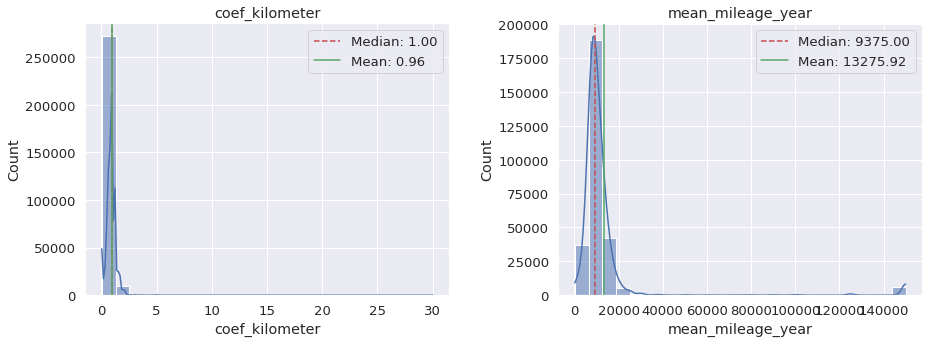

In [86]:
plot_histograms(df[['coef_kilometer', 'mean_mileage_year']])

In [87]:
print('Кол-во строк с "coef_kilometer" > 3:', df.query('coef_kilometer > 3')['coef_kilometer'].count())

Кол-во строк с "coef_kilometer" > 3: 161


In [88]:
print('Кол-во строк с "mean_mileage_year" > 40000:', df.query('mean_mileage_year > 40000')['mean_mileage_year'].count())

Кол-во строк с "mean_mileage_year" > 40000: 7304


В случае плохих метрик, целесообразно удалить эти данные

**Вывод:**
В данном разделе мы создали новые признаки для более глубокого анализа данных о пробеге автомобилей:

**Средний пробег за год**:
- Признак рассчитывался как отношение общего пробега автомобиля к количеству лет с момента его регистрации до 2017 года. Это позволяет оценить интенсивность использования автомобиля.

**Коэффициент пробега**:
- Признак рассчитывался как отношение фактического пробега автомобиля к медианному пробегу для соответствующей группы. Это позволяет выявить автомобили с аномально высоким или низким пробегом.

### Описание количественных параметров

Для описания количественных параметров выведем их гистограммы и их статистики в абсолютных и нормализированных величинах.

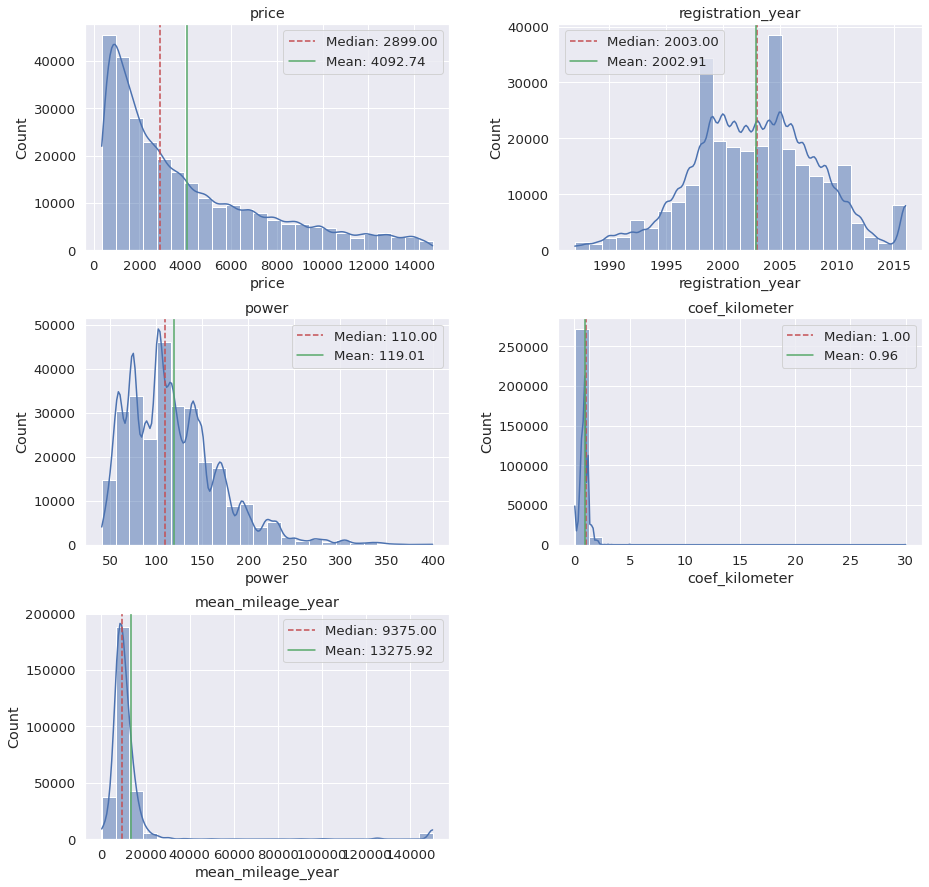

In [89]:
plot_histograms(df[['price', 'registration_year', 'power', 'coef_kilometer', 'mean_mileage_year']])

In [90]:
df[['price', 'registration_year', 'power', 'coef_kilometer', 'mean_mileage_year']].describe()

price  registration_year          power  coef_kilometer  \
count  281987.000000      281987.000000  281987.000000   281987.000000   
mean     4092.737750        2002.911999     119.010515        0.955681   
std      3518.223973           5.563841      50.285948        0.336399   
min       355.000000        1987.000000      41.000000        0.030000   
25%      1300.000000        1999.000000      78.000000        1.000000   
50%      2899.000000        2003.000000     110.000000        1.000000   
75%      5990.000000        2007.000000     145.000000        1.000000   
max     14799.000000        2016.000000     400.000000       30.000000   

       mean_mileage_year  
count      281987.000000  
mean        13275.922660  
std         21133.147161  
min           167.000000  
25%          7500.000000  
50%          9375.000000  
75%         12500.000000  
max        150000.000000

**Выводы:**

**Цена**
- Большинство автомобилей имеют относительно низкие цены, что отражает долгий правый хвост распределения. 
- Средняя цена значительно выше медианы, что указывает на присутствие нескольких автомобилей с очень высокими ценами, которые смещают среднее значение.

**Год регистрации**
- Распределение года регистрации относительно симметрично с двумя явными пиками.
- Большинство автомобилей зарегистрированы в начале 2000-х годов.

**Мощность**
- Большинство автомобилей имеют мощность до 150, при этом средняя мощность немного выше медианного значения.
- Небольшое смещение вправо указывает на присутствие автомобилей с большей мощностью, чем большинство.

###  EDA c помощью библиотеки sweetviz

Также быстро взгялнем на данные в разрезе автоматического EDA c помощью библиотеки `sweetviz`

In [91]:
report = sv.analyze([df, "Profiling Report"], 'price')
report.show_html('Profiling Report.html')
IFrame(src='Profiling Report.html', width=1000, height=500)

                                             |          | [  0%]   00:00 -> (? left)

Report Profiling Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Вывод:**
Согласно полученным данным можно сделать вывод:
- Четкая взаимосвязь между типом топлива и пробегом: автомобили с дизельным двигателем чаще имеют больший пробег.
- Автомобили с ручной коробкой передач чаще встречаются с меньшей мощностью двигателя.

### Описание категориальных параметров

Взглянем на процентное содержание данных

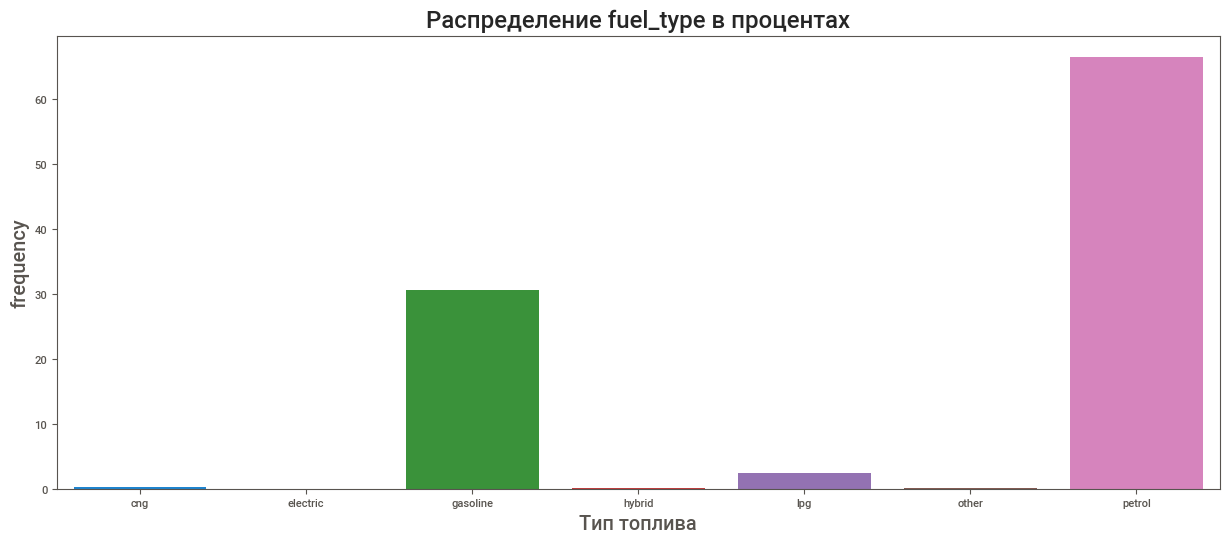

In [92]:
# Рассчитываем частоты в процентах
value_counts_normalized = df['fuel_type'].value_counts(normalize=True).reset_index()
value_counts_normalized.columns = ['fuel_type', 'frequency']

# Умножаем на 100, чтобы преобразовать доли в проценты
value_counts_normalized['frequency'] *= 100

# Сортируем по убыванию частоты
value_counts_normalized = value_counts_normalized.sort_values(by='frequency', ascending=False).reset_index(drop=True)

plt.figure(figsize=(15, 6))
# Построение графика абсолютных величин в процентах
sns.barplot(x='fuel_type', y='frequency', data=value_counts_normalized)
plt.title('Распределение fuel_type в процентах')
plt.xlabel('Тип топлива')
plt.show()

В данных в основном представлены 3 категории, остальные можно объеденить в категорию `other`

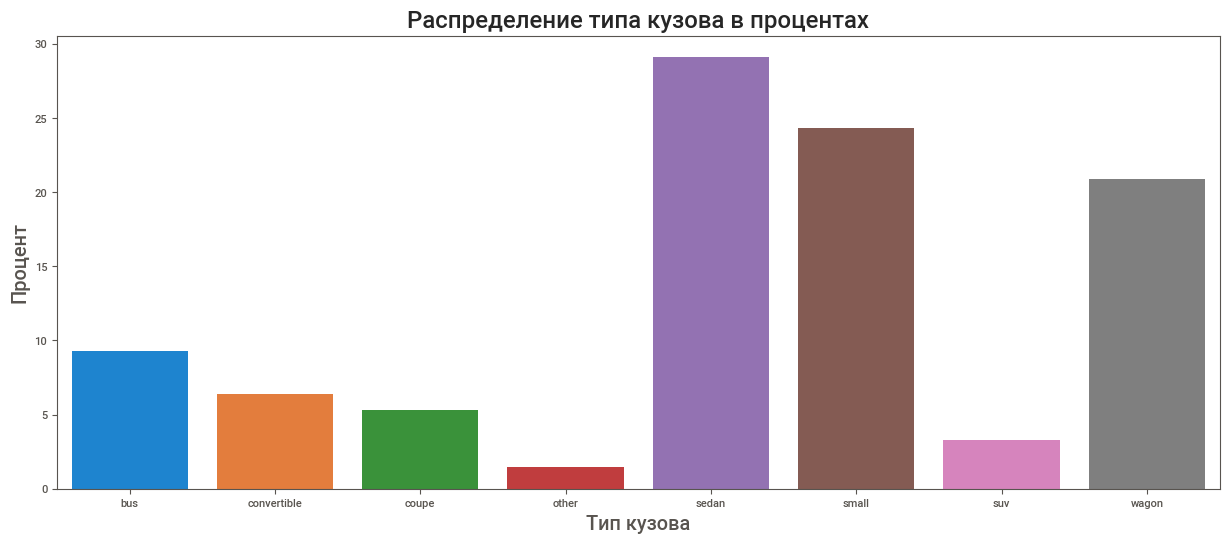

In [93]:
# Рассчитываем частоты в процентах
value_counts_normalized = df['vehicle_type'].value_counts(normalize=True).reset_index()
value_counts_normalized.columns = ['vehicle_type', 'frequency']

# Умножаем на 100, чтобы преобразовать доли в проценты
value_counts_normalized['frequency'] *= 100

# Сортируем по убыванию частоты
value_counts_normalized = value_counts_normalized.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(15, 6))
# Построение графика абсолютных величин в процентах
sns.barplot(x='vehicle_type', y='frequency', data=value_counts_normalized)
plt.title('Распределение типа кузова в процентах')
plt.xlabel('Тип кузова')
plt.ylabel('Процент')
plt.show()

Расспределение данных не сильно изменилось после предобраотки данных

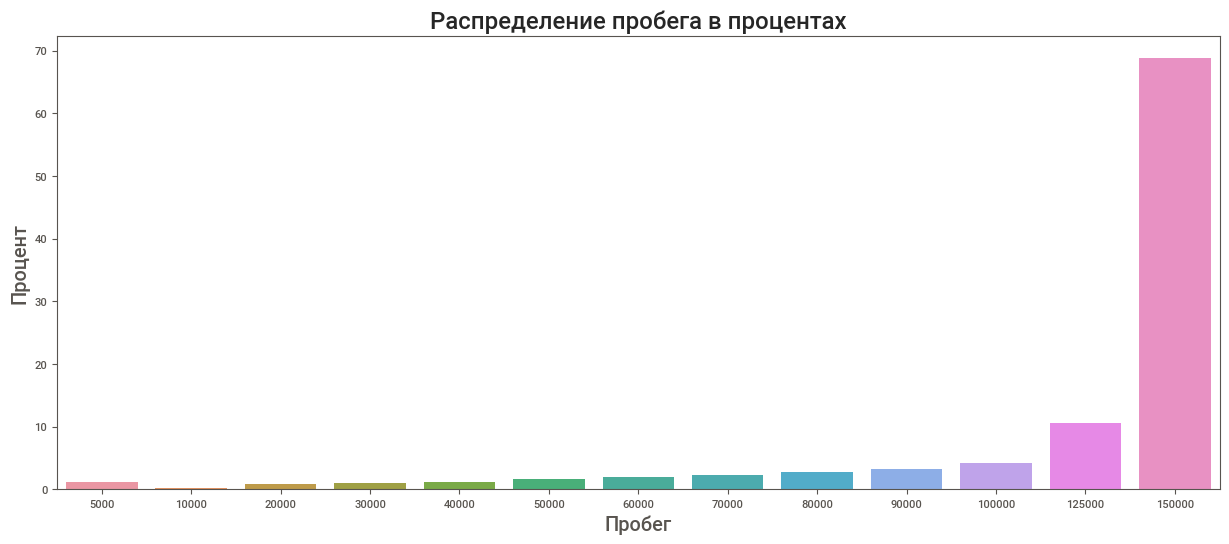

In [94]:
# Рассчитываем частоты в процентах
value_counts_normalized = df['kilometer'].value_counts(normalize=True).reset_index()
value_counts_normalized.columns = ['kilometer', 'frequency']

# Умножаем на 100, чтобы преобразовать доли в проценты
value_counts_normalized['frequency'] *= 100

# Сортируем по убыванию частоты
value_counts_normalized = value_counts_normalized.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(15, 6))
# Построение графика абсолютных величин в процентах
sns.barplot(x='kilometer', y='frequency', data=value_counts_normalized)
plt.title('Распределение пробега в процентах')
plt.xlabel('Пробег')
plt.ylabel('Процент')
plt.show()

В основном в данных представлены машины с значительным пробегом.

### Влияние категориальных признаков на цену

#### Построим боксплоты категориальных признаков и посмотрим как они влияют на цену автомобилей

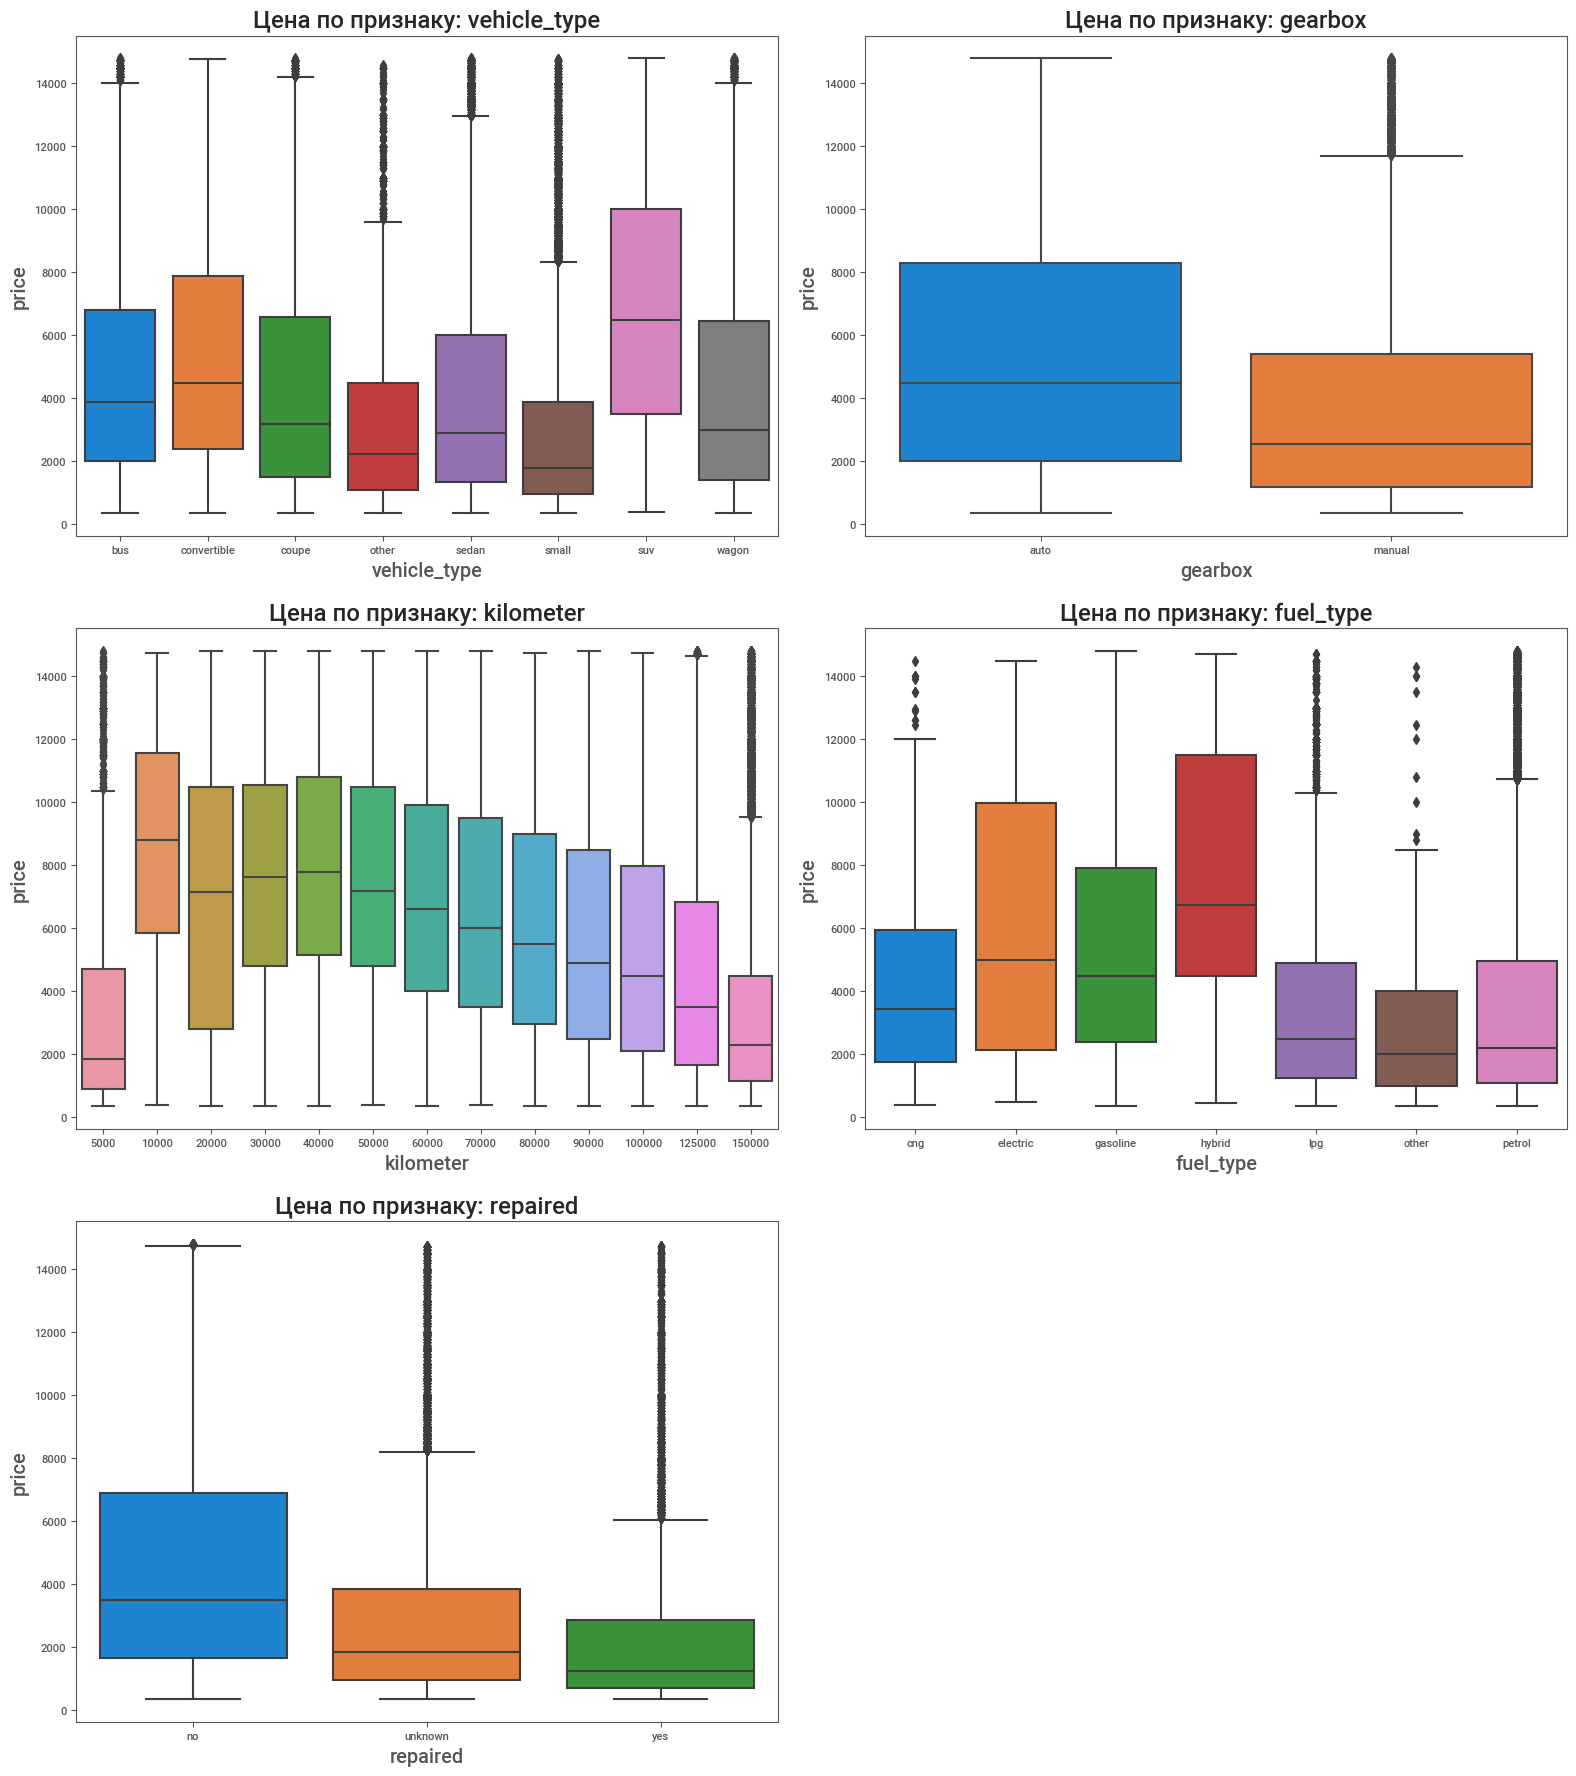

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
axes = axes.flatten()

for i, feature in enumerate(df.drop(['brand', 'model'], axis=1).select_dtypes(include=['category']).columns):
    data = df[df[feature] != ' ']
    sns.boxplot(x=feature, y='price', data=data, ax=axes[i])
    axes[i].set_title(f'Цена по признаку: {feature}')
    
# Удаляем пустые подграфики, если число признаков нечетно
if len(df.drop(['brand', 'model'], axis=1).select_dtypes(include=['category']).columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

**Заключение**
- **Тип транспортного средства**: На цену транспортного средства сильно влияет его тип, с самыми высокими ценами для SUV и Convertible.
- **Коробка передач**: Транспортные средства с автоматической коробкой передач обычно стоят дороже, чем с механической.
- **Пробег**: Чем больше пробег, тем ниже цена транспортного средства, при этом выбивается из тренда машины с пробегом до 5000
- **Тип топлива**: Гибридные транспортные средства имеют тенденцию к более высоким ценам.
- **Состояние ремонта**: Транспортные средства, которые не подвергались ремонту, стоят дороже, чем те, которые были отремонтированы.

Более подробно посмотрим на данные у которых пробег равен до 5000

In [96]:
df.query('(kilometer == 5000) & (price < 2000) & (registration_year > 2014)').head(10)

price vehicle_type  registration_year gearbox  power     model  \
43      1400        sedan               2016  manual     55     other   
1304     650        wagon               2016  manual    116   cordoba   
2516     500        small               2016  manual    200      golf   
3655     850        small               2016  manual    101     astra   
3916     650        small               2016    auto     75     corsa   
6781     500        wagon               2016  manual     60     ibiza   
6867    1350        sedan               2016  manual    116    lancer   
19556    400        small               2015    auto    102     other   
20139    489        sedan               2015    auto    367  c_klasse   
20358    850        coupe               2016  manual    136    scenic   

      kilometer  registration_month fuel_type          brand repaired  \
43         5000                   1  gasoline        hyundai  unknown   
1304       5000                  10    petrol           seat       no   
2516       5000                   5    petrol     volkswagen  unknown   
3655       5000                   5    petrol           opel       no   
3916       5000                  12    petrol           opel  unknown   
6781       5000                  10  gasoline           seat       no   
6867       5000                   2    petrol     mitsubishi  unknown   
19556      5000                   1  gasoline           audi  unknown   
20139      5000                  12    petrol  mercedes_benz       no   
20358      5000                  12    petrol        renault  unknown   

       mean_mileage_year  coef_kilometer  
43                  5000            0.03  
1304                5000            0.03  
2516                5000            0.03  
3655                5000            0.03  
3916                5000            0.03  
6781                5000            0.03  
6867                5000            0.03  
19556               2500            1.00  
20139               2500            0.11  
20358               5000            0.03

***Весьма подозрительно выглядят такие данные, целесообразность их для обучения модели стоит под вопросом.***

#### Построим боксплоты брендов и посмотрим как они влияют на цену автомобилей с учетом типа коробки передач

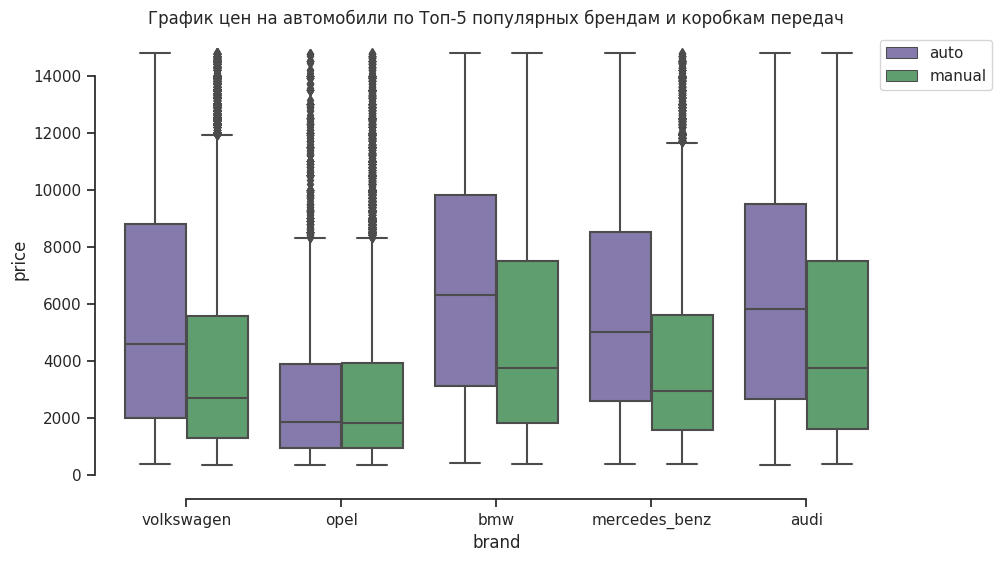

In [97]:
sns.set_theme(style="ticks")

# Определение топ 5 марок по количеству записей
top_brands = df['brand'].value_counts().nlargest(5).index

# Фильтрация данных для топ 5 марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 марок
sns.boxplot(x="brand", y="price", hue="gearbox", palette=["m", "g"], data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('График цен на автомобили по Топ-5 популярных брендам и коробкам передач')

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

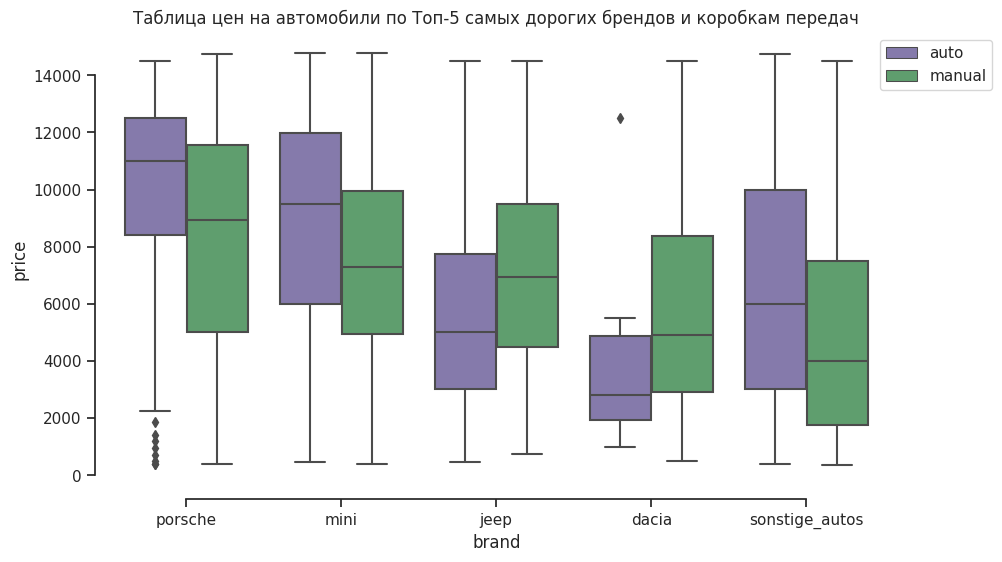

In [98]:
# Определение топ 5 самых дорогих марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nlargest(5).index

# Фильтрация данных для топ 5 самых дорогих марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 самых дорогих марок
sns.boxplot(x="brand", y="price", hue="gearbox", palette=["m", "g"], data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Таблица цен на автомобили по Топ-5 самых дорогих брендов и коробкам передач')

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

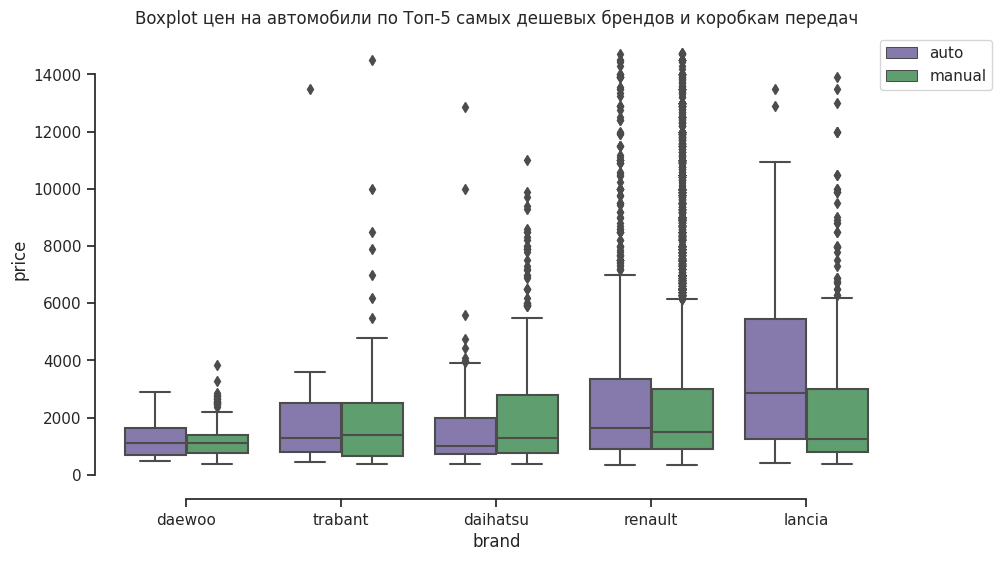

In [99]:
# Определение топ 5 самых дешевых марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nsmallest(5).index

# Фильтрация данных для топ 5 самых дешевых марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 самых дешевых марок
sns.boxplot(x="brand", y="price", hue="gearbox", palette=["m", "g"], data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Boxplot цен на автомобили по Топ-5 самых дешевых брендов и коробкам передач')

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

**Вывод** Не все бренды повержены тренду, что АКП влияют на цены, причем чем дешевле бренд, тем менее выражено отличие влияния типа коробки передач на конечную стоимость авто.

#### Построим боксплоты брендов и посмотрим как они влияют на цену автомобилей с учетом состояния авто

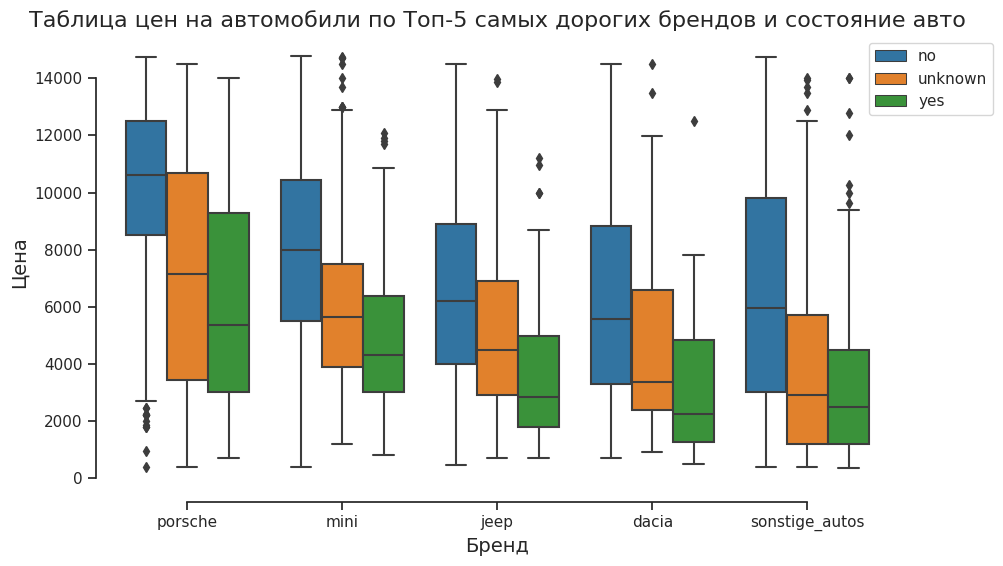

In [100]:
# Определение топ 5 самых дорогих марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nlargest(5).index

# Фильтрация данных для топ 5 самых дорогих марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 марок с явной палитрой для трех категорий
palette_ = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Пример палитры с тремя цветами
sns.boxplot(x="brand", y="price", hue="repaired", palette=palette_, data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Таблица цен на автомобили по Топ-5 самых дорогих брендов и состояние авто', size=16)
plt.xlabel('Бренд', size=14)
plt.ylabel('Цена', size=14)

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

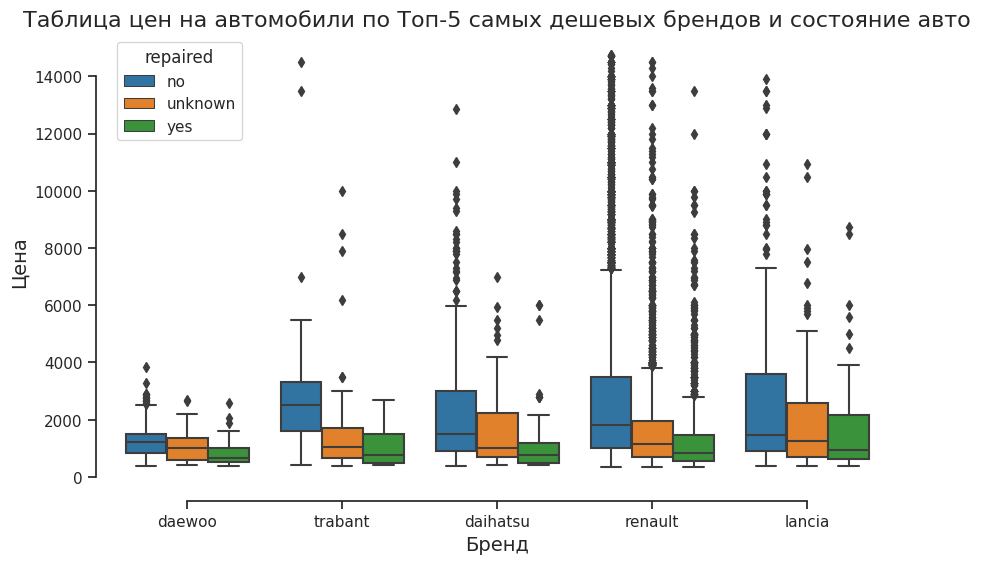

In [101]:
# Определение топ 5 самых дешевых марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nsmallest(5).index

# Фильтрация данных для топ 5 самых дешевых марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 марок с явной палитрой для трех категорий
palette_ = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Пример палитры с тремя цветами
sns.boxplot(x="brand", y="price", hue="repaired", palette=palette_, data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Boxplot цен на автомобили по Топ-5 самых дешевых брендов и коробкам передач')

# Настройка графика
plt.title('Таблица цен на автомобили по Топ-5 самых дешевых брендов и состояние авто', size=16)
plt.xlabel('Бренд', size=14)
plt.ylabel('Цена', size=14)

plt.show()

**Вывод:** Для всех марок сохраняется тенденция, что если у автомобиля был ремон он стоит дешевле, при этом если эта информация не указана, то цена будет в среднем выше, но все же, ниже если указать отсутствия ремонта.

#### Построим боксплоты брендов и посмотрим как они влияют на цену автомобилей с учетом типа кузова

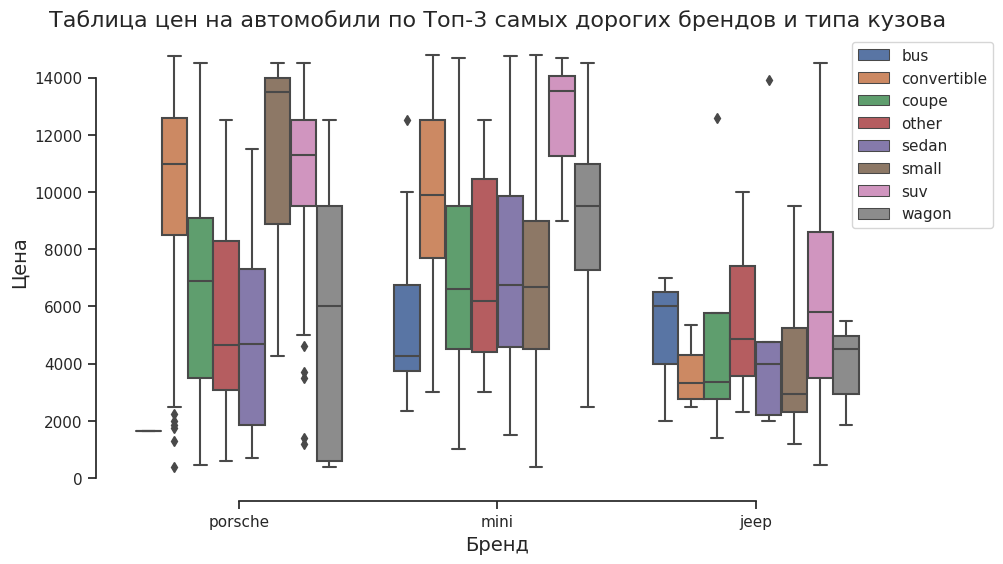

In [102]:
# Определение топ 5 самых дорогих марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nlargest(3).index

# Фильтрация данных для топ 5 самых дорогих марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 марок с явной палитрой для трех категорий
sns.boxplot(x="brand", y="price", hue="vehicle_type", data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Таблица цен на автомобили по Топ-3 самых дорогих брендов и типа кузова', size=16)
plt.xlabel('Бренд', size=14)
plt.ylabel('Цена', size=14)

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

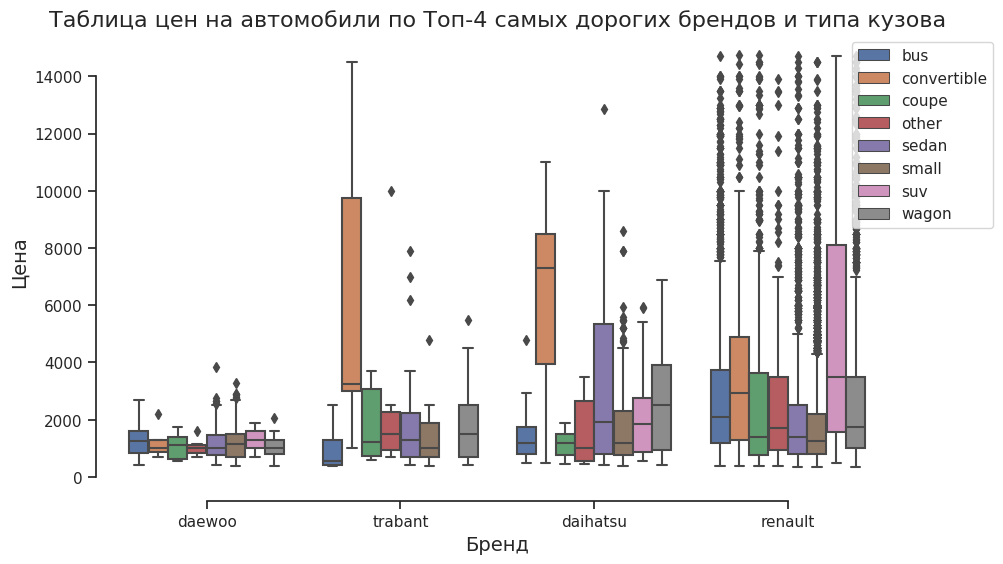

In [103]:
# Определение топ 5 самых дорогих марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nsmallest(4).index

# Фильтрация данных для топ 5 самых дорогих марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 марок с явной палитрой для трех категорий
sns.boxplot(x="brand", y="price", hue="vehicle_type", data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Таблица цен на автомобили по Топ-4 самых дорогих брендов и типа кузова', size=16)
plt.xlabel('Бренд', size=14)
plt.ylabel('Цена', size=14)

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

**Выводы** У разных брендов по разному влияет тип кузова на цену, но при этом у дорогих брендов в лидерах по цене `suv` и `convertible`, а дешевых `convertible`, `wagon` и `sedan`

#### Построим боксплоты брендов и посмотрим как они влияют на цену автомобилей с учетом типа толива

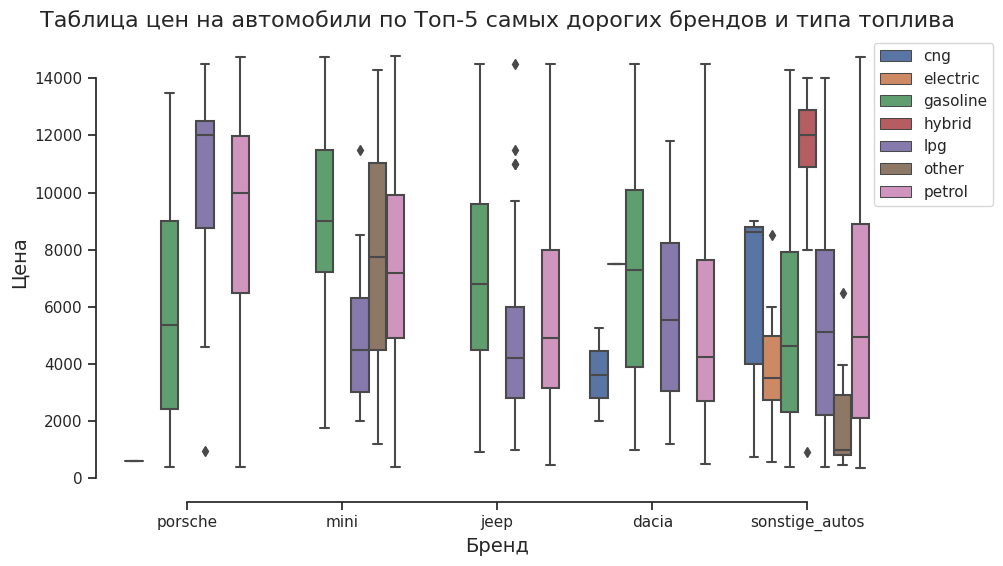

In [104]:
# Определение топ 5 самых дорогих марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nlargest(5).index

# Фильтрация данных для топ 5 самых дорогих марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 марок с явной палитрой для трех категорий
sns.boxplot(x="brand", y="price", hue="fuel_type", data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Таблица цен на автомобили по Топ-5 самых дорогих брендов и типа топлива', size=16)
plt.xlabel('Бренд', size=14)
plt.ylabel('Цена', size=14)

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

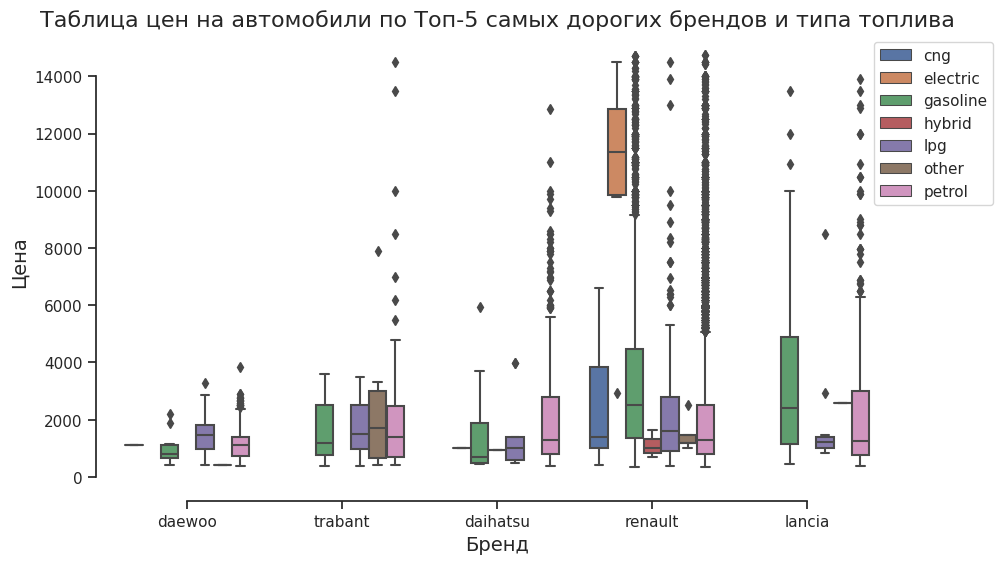

In [105]:
# Определение топ 5 самых дорогих марок по средней цене
top_brands = df.groupby('brand')['price'].mean().nsmallest(5).index

# Фильтрация данных для топ 5 самых дорогих марок
top_df = df[df['brand'].isin(top_brands)]

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение boxplot для топ 5 марок с явной палитрой для трех категорий
sns.boxplot(x="brand", y="price", hue="fuel_type", data=top_df, order=top_brands)
sns.despine(offset=10, trim=True)

# Настройка графика
plt.title('Таблица цен на автомобили по Топ-5 самых дорогих брендов и типа топлива', size=16)
plt.xlabel('Бренд', size=14)
plt.ylabel('Цена', size=14)

# Перенос легенды в верхний правый угол
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

**Выводы** У разных брендов по разному влияет тип топлива на цену, но при этом у дорогих брендов в лидерах по цене `gasoline` и, а дешевых `electric`, при этом практически ни у одно из брендов не представлена вся линейка разновидностей топлива. Для более углубленного анализа, целесообразно рассматривать в разрезе брендов с одинаковыми типами топлива.

**Влияние категориальных признаков на цену автомобилей:**
- На цену транспортного средства сильно влияет его тип. Наиболее высокие цены наблюдаются у SUV и Convertible.
- Транспортные средства с автоматической коробкой передач обычно стоят дороже, чем с механической.
- Чем больше пробег, тем ниже цена транспортного средства, за исключением автомобилей с пробегом до 5000 км.
- Гибридные транспортные средства имеют тенденцию к более высоким ценам.
- Транспортные средства, которые не подвергались ремонту, стоят дороже, чем те, которые были отремонтированы. Автомобили с неизвестным состоянием ремонта находятся в среднем между отремонтированными и не отремонтированными.
- Не все бренды подвержены тренду, что автоматическая коробка передач влияет на цены. Чем дешевле бренд, тем менее выражено влияние типа коробки передач на конечную стоимость авто.
- У дорогих брендов в лидерах по цене SUV и Convertible, у дешевых — Convertible, Wagon и Sedan. Влияние типа кузова на цену различается в зависимости от бренда.
- У дорогих брендов наибольшую цену имеют автомобили на бензине и гибриды, у дешевых — электрические автомобили. Влияние типа топлива на цену различается в зависимости от бренда.

### Распределение цены в зависимости от года выпуска и наличия ремонта

No handles with labels found to put in legend.


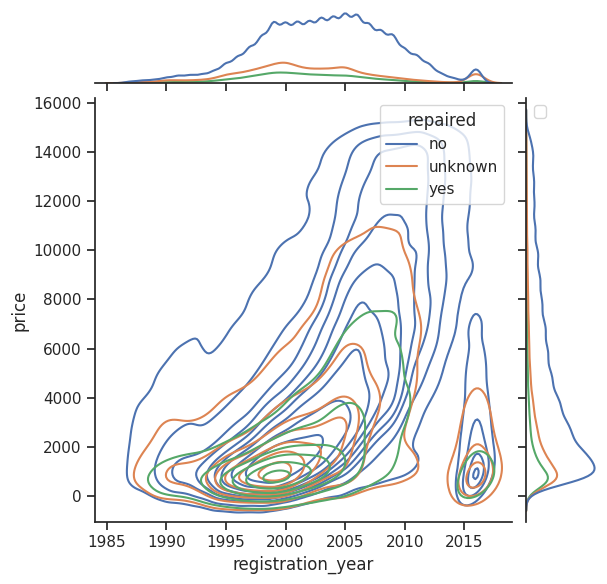

In [106]:
# Создаем график jointplot с KDE
g = sns.jointplot(
    data=df,
    x="registration_year", y="price", hue="repaired",
    kind="kde",
)

# Перемещаем легенду в верхний левый угол
plt.legend(loc='upper left')
plt.show()

На предоставленном графике контуров (контурный график) показана зависимость между ценой автомобилей и годом регистрации с учетом состояния автомобиля (ремонтировался или нет). Цветные контуры представляют различные категории состояния:

- **Синий**: Автомобили, которые не ремонтировались (no).
- **Оранжевый**: Автомобили с неизвестным состоянием ремонта (unknown).
- **Зеленый**: Автомобили, которые ремонтировались (yes).

**Общая тенденция**
- **Цена автомобилей**: Видно, что цена автомобилей уменьшается с увеличением года регистрации. Это связано с тем, что более новые автомобили, как правило, стоят дешевле, чем более старые автомобили, в силу их возраста и износа.

**Состояние автомобиля**
- **Автомобили, которые не ремонтировались**: Эти автомобили имеют наибольший диапазон цен, особенно для автомобилей зарегистрированных после 2000 года. Это может быть связано с тем, что автомобили в хорошем состоянии (не ремонтировались) имеют более высокую стоимость.
- **Автомобили с неизвестным состоянием**: Эти автомобили также демонстрируют широкий диапазон цен, но распределение менее плотное по сравнению с не ремонтированными автомобилями. Скорее всего в данных присутсвуют битые автомобили.
- **Автомобили, которые ремонтировались**: Эти автомобили имеют меньшую стоимость в среднем по сравнению с не ремонтированными автомобилями. Это может быть связано с тем, что автомобили, которые были в ремонте, обычно стоят дешевле из-за возможных скрытых проблем или общего снижения доверия покупателей к таким автомобилям.


**Заключение**
- Автомобили, которые не подвергались ремонту, обычно стоят дороже, особенно если они зарегистрированы после 2000 года.
- Автомобили с неизвестным состоянием ремонта и те, которые ремонтировались, имеют тенденцию к более низким ценам.
- Год регистрации оказывает значительное влияние на цену автомобиля, при этом более новые автомобили имеют тенденцию стоить дешевле.

###  Зависимость цены от количественных параметров

Построим обобщенные графики зависимости цены от количественных параметров

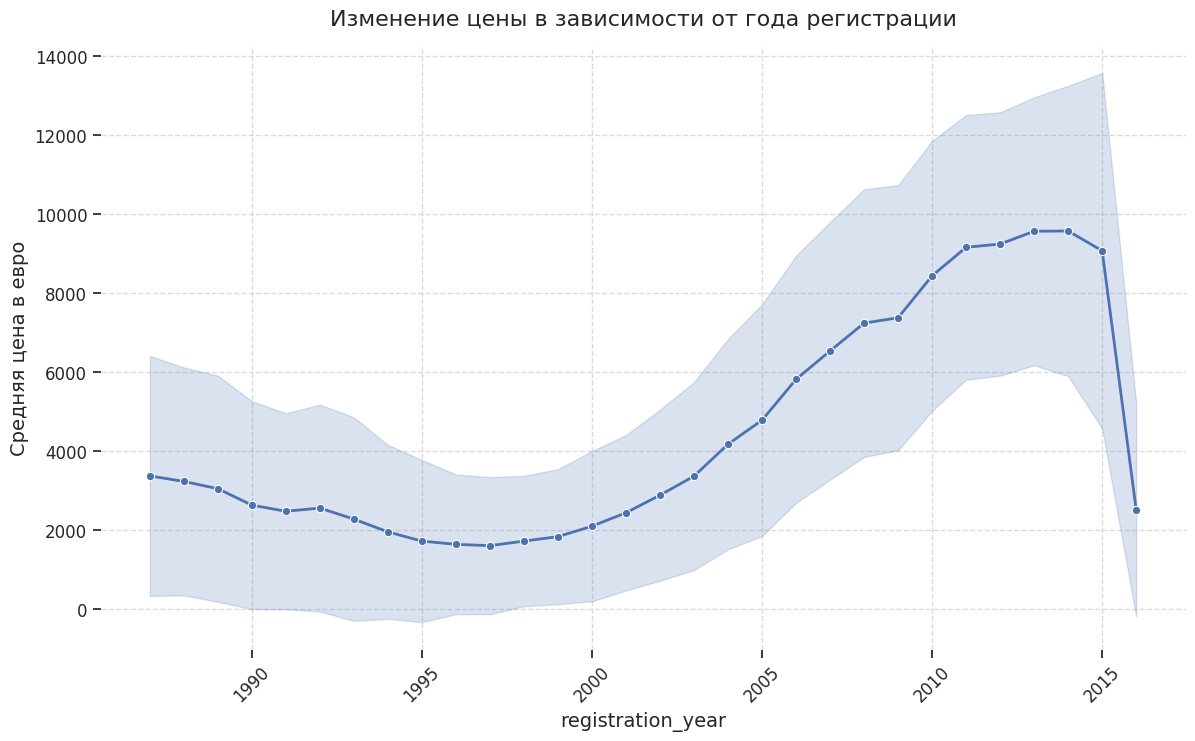

In [107]:
price_plot('registration_year', 'Изменение цены в зависимости от года регистрации')

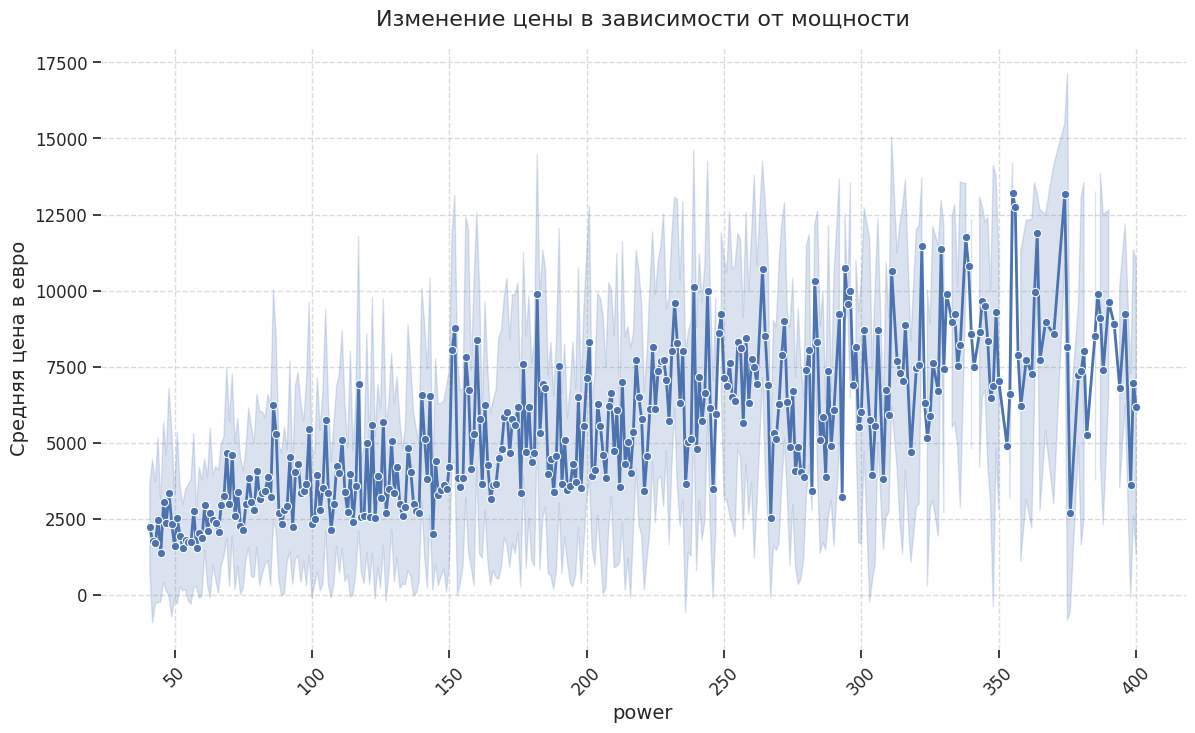

In [108]:
price_plot('power', 'Изменение цены в зависимости от мощности')

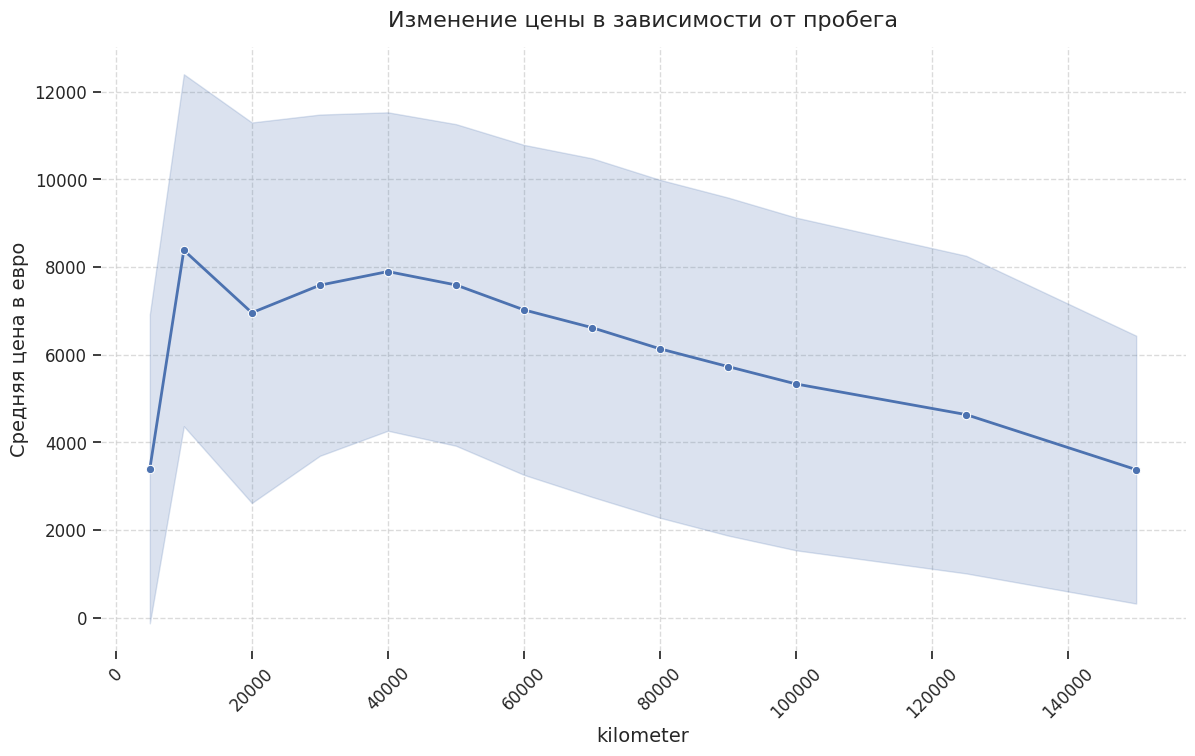

In [109]:
price_plot('kilometer', 'Изменение цены в зависимости от пробега')

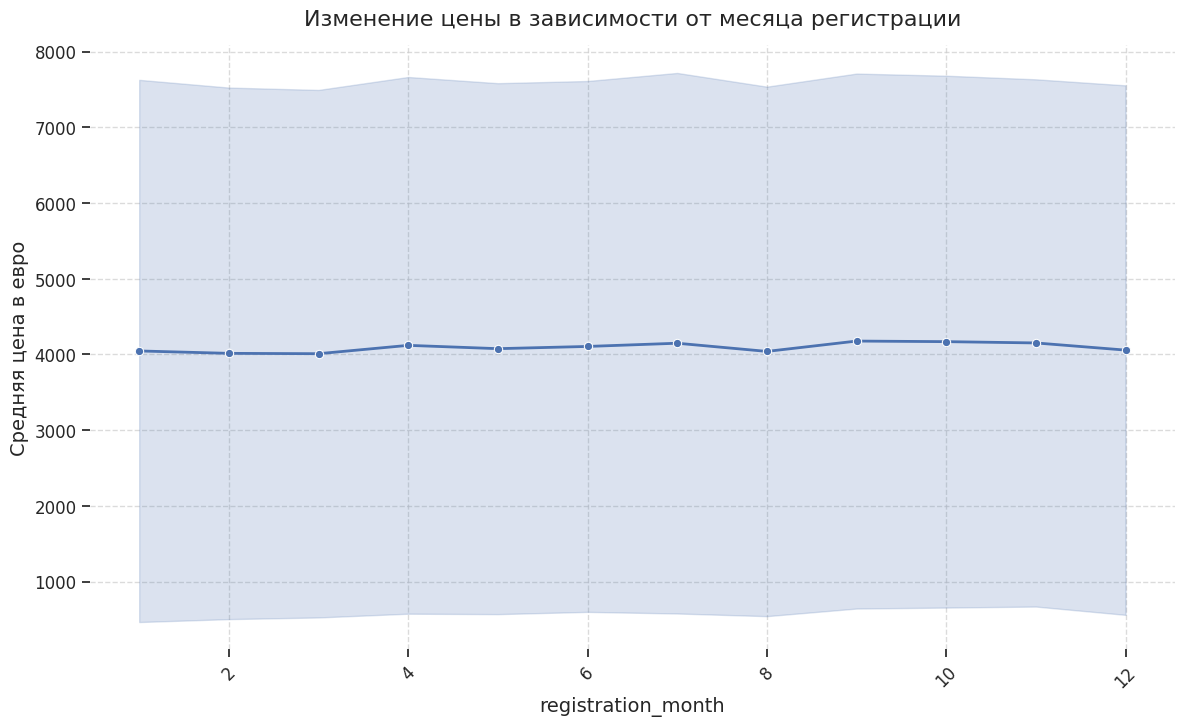

In [110]:
price_plot('registration_month', 'Изменение цены в зависимости от месяца регистрации')

Цена никак не зависит от месяца регистрации, целесообразно исключить данный столбец из модели

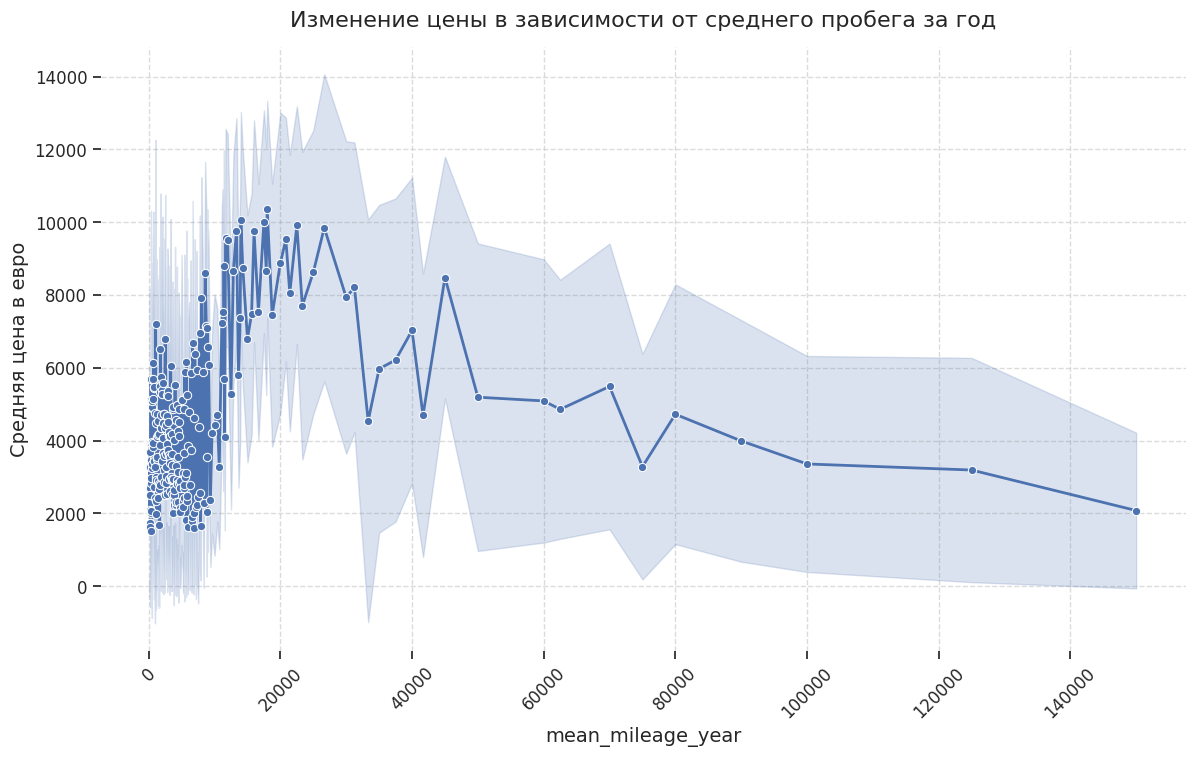

In [111]:
price_plot('mean_mileage_year', 'Изменение цены в зависимости от среднего пробега за год')

**Вывод:**
- Видна общая тенденция роста цен автомобилей с увеличением года регистрации до 2014 года, а затем цены начинают снижаться.
- Цена явно зависит от мощности двигателя.
- Цена снижаестя с увеличением пробега автомобиля.
- Отсутсвует зависимость цены от месяца регистрации.
- Чем выше средний пробег за год, тем сильнее цена падает

### Зависимость цены от года регистрации для каждого бренда с учетом состояния автомобиля

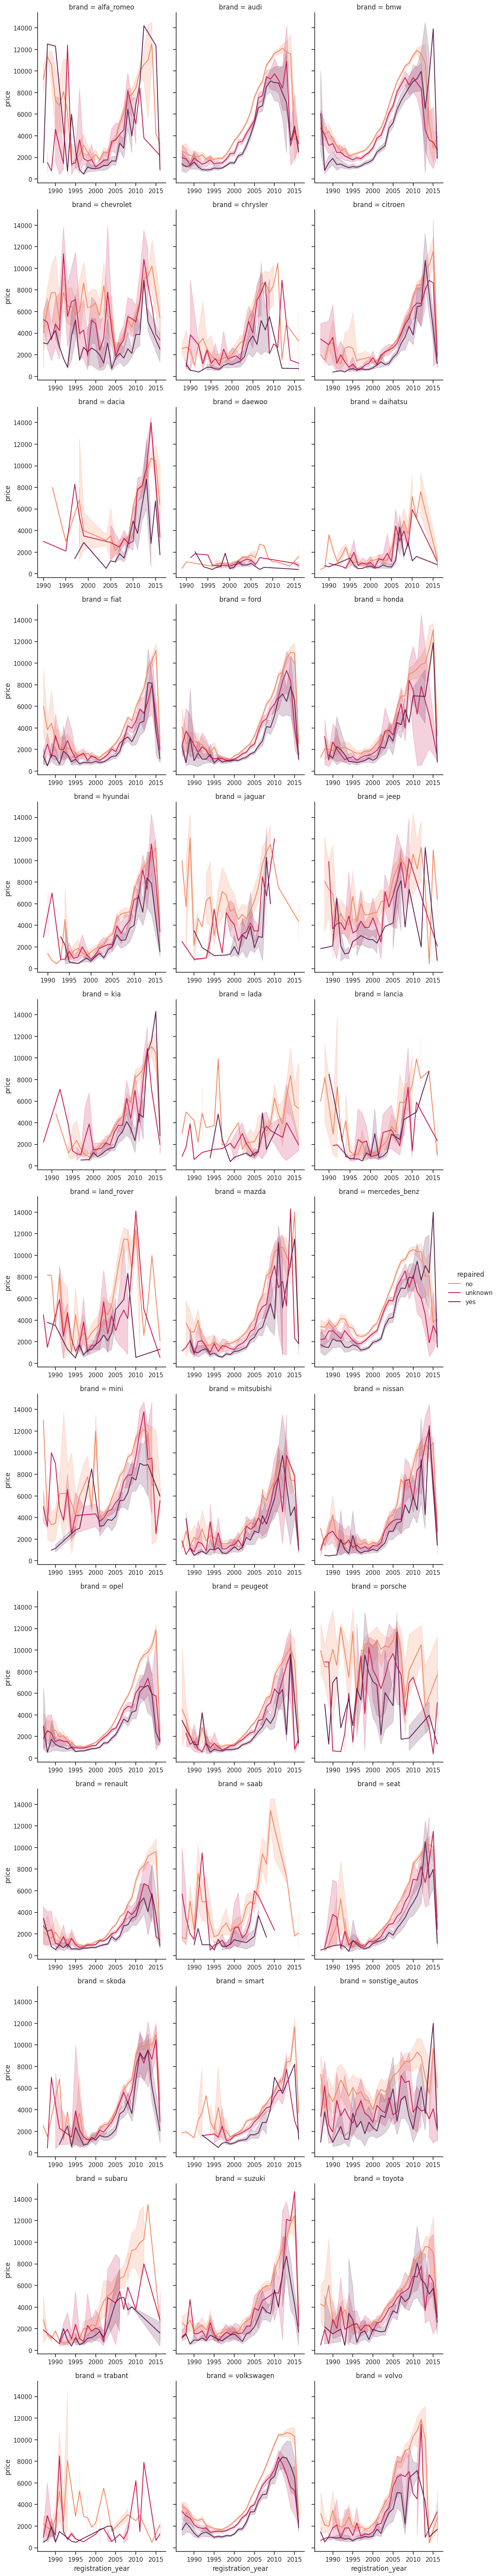

In [112]:
# Динамическое создание палитры на основе количества уникальных значений в столбце "repaired"
num_repaired = df['repaired'].nunique()
palette = sns.color_palette("rocket_r", n_colors=num_repaired)

sns.relplot(
    data=df,
    x="registration_year", y="price",
    hue="repaired", col="brand",
    kind="line", palette=palette,
    height=5, aspect=.75, col_wrap=3, facet_kws=dict(sharex=False),
)

plt.show()

**Вывод:**
На предоставленном графике показана зависимость цены автомобилей от года регистрации для различных марок с учетом состояния автомобиля (ремонтировался или нет).

**Основные выводы**


1. **Общая тенденция цен**:
   - Для большинства марок видна общая тенденция роста цен автомобилей с увеличением года регистрации до определенного момента (обычно около 2000-х годов), а затем цены начинают снижаться или стабилизироваться.
   - После 2008 года цены на автомобили большинства марок показывают более высокие значения, что может быть связано с улучшением технологий и качеством автомобилей. При этом после 2014 года происходит падение цен, что может быть связана с кризисом на рынке продаж автомобилей.


2. **Влияние состояния автомобиля**:
   - **Ремонтированные автомобили (orange)**: Как правило, их цена ниже по сравнению с автомобилями, которые не ремонтировались. Это наблюдается практически для всех марок. Ремонтированные автомобили могут стоить дешевле из-за возможных проблем или снижения доверия покупателей.
   - **Неизвестное состояние (purple)**: Данные для автомобилей с неизвестным состоянием (unknown) имеют большую вариативность, и их цена может быть как ниже, так и выше по сравнению с остальными категориями.


3. **Различия между марками**:
   - **Высокие цены**: Марки, такие как BMW, Audi, и Mercedes-Benz, демонстрируют более высокие цены по сравнению с другими марками. Это может быть связано с их репутацией как премиум-брендов.
   - **Низкие цены**: Марки, такие как Dacia и Daihatsu, имеют тенденцию к более низким ценам.
   - **Стабильные цены**: Для некоторых марок, таких как Toyota и Volkswagen, цены остаются относительно стабильными в разные годы регистрации.


4. **Временные тренды**:
   - В некоторых случаях видно временные колебания цен, которые могут быть связаны с экономическими условиями, изменениями в законодательстве или выпуском новых моделей автомобилей.


**Заключение**
- Цена автомобилей в значительной степени зависит от их года регистрации и состояния (ремонтировался ли автомобиль).
- Премиум-бренды демонстрируют более высокие цены, в то время как менее известные марки имеют тенденцию к более низким ценам.
- Ремонтированные автомобили, как правило, стоят дешевле, что может указывать на предпочтения покупателей к автомобилям в хорошем состоянии.
- Различные временные тренды могут указывать на влияние внешних факторов на стоимость автомобилей.

### Распределение медианной цены по маркам автомобиля

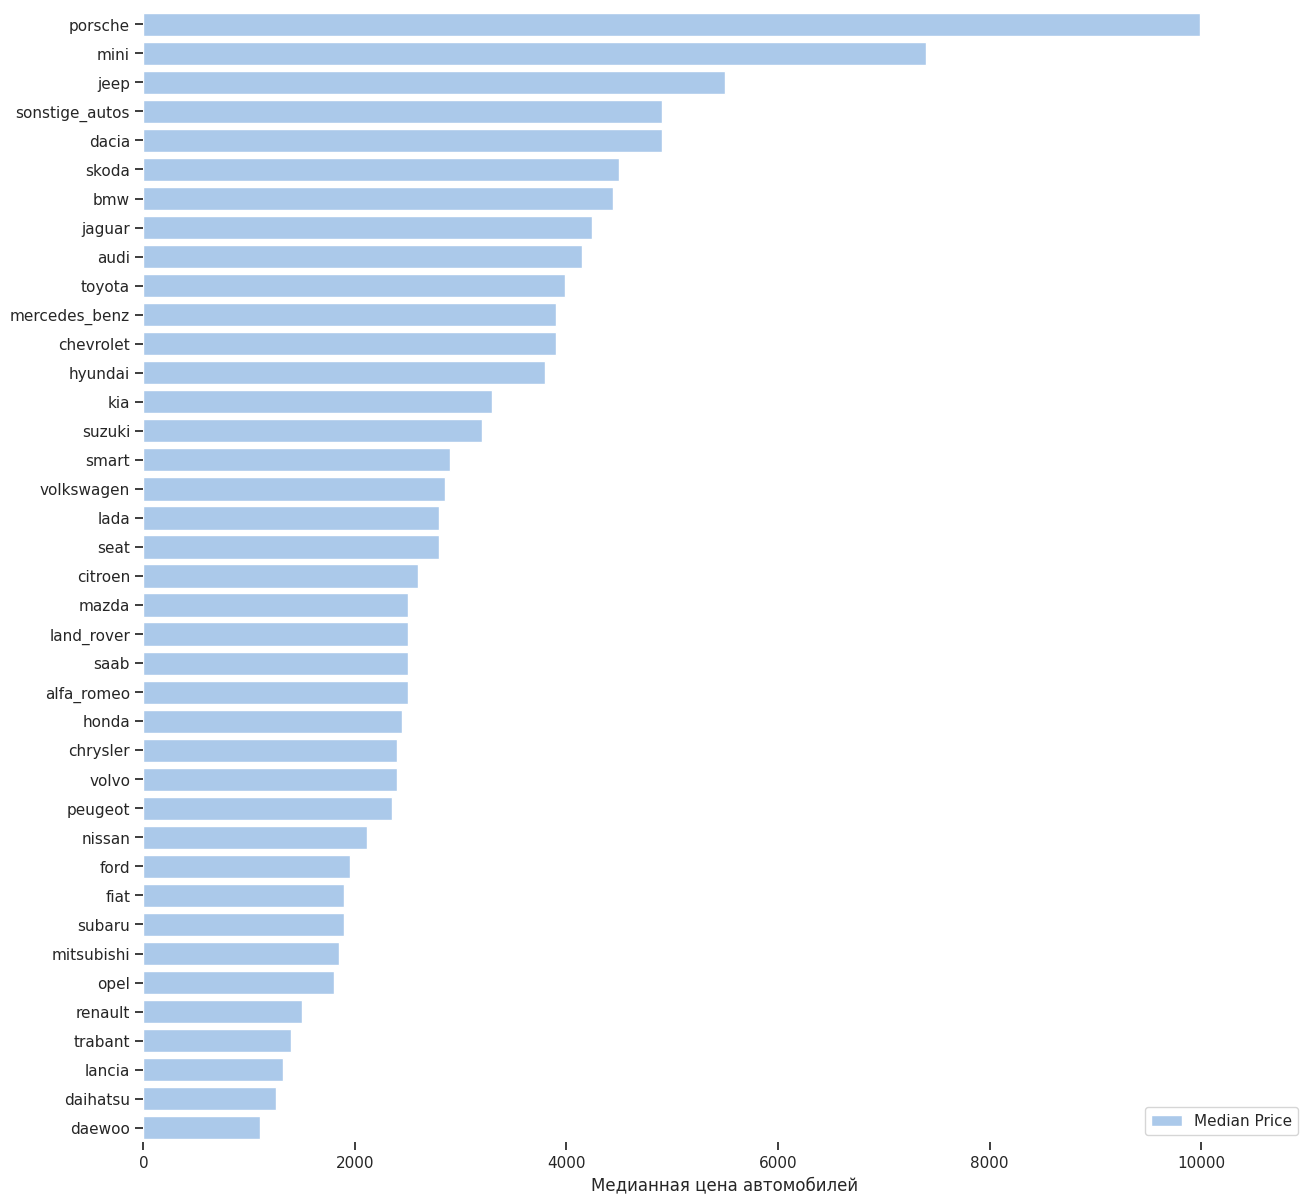

In [113]:
# Вычисление медианной цены для каждого бренда
median_prices = df.groupby('brand')['price'].median().reset_index()

# Сортировка брендов по медианной цене
median_prices = median_prices.sort_values(by='price', ascending=False)

# Создание фигуры и осей
f, ax = plt.subplots(figsize=(15, 15))

# Построение барплота для медианных цен с указанием порядка категорий
sns.set_color_codes("pastel")
sns.barplot(x="price", y="brand", data=median_prices,
            label="Median Price", color="b",
            order=median_prices['brand'])

# Добавление легенды и подписей к осям
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, median_prices['price'].max() + 1000), ylabel="",
       xlabel="Медианная цена автомобилей")
sns.despine(left=True, bottom=True)

plt.show()

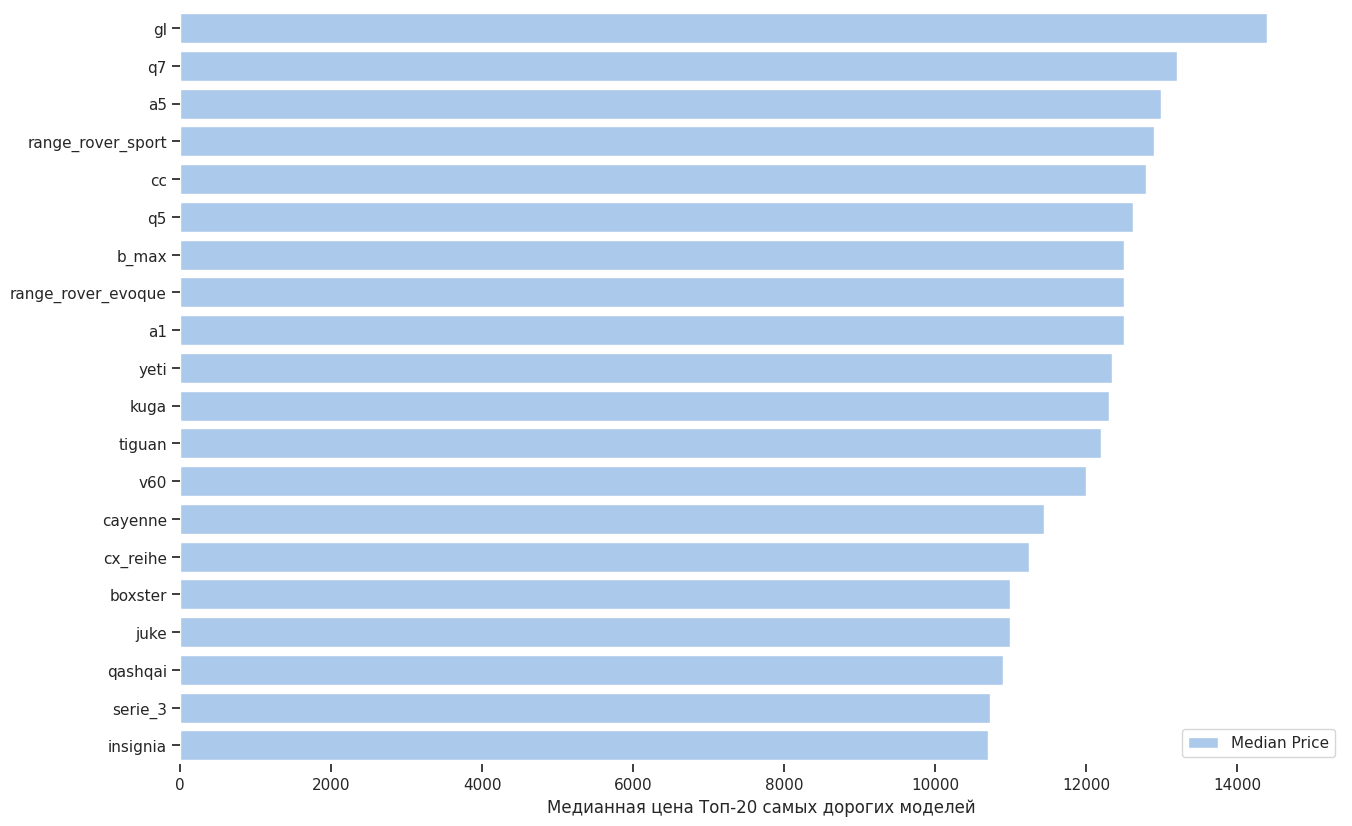

In [114]:
# Вычисление медианной цены для каждого бренда
median_prices = df.groupby('model')['price'].median().reset_index()

# Сортировка брендов по медианной цене
median_prices = median_prices.sort_values(by='price', ascending=False).head(20)

# Создание фигуры и осей
f, ax = plt.subplots(figsize=(15, 10))

# Построение барплота для медианных цен с указанием порядка категорий
sns.set_color_codes("pastel")
sns.barplot(x="price", y="model", data=median_prices,
            label="Median Price", color="b",
            order=median_prices['model'])

# Добавление легенды и подписей к осям
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, median_prices['price'].max() + 1000), ylabel="",
       xlabel="Медианная цена Топ-20 самых дорогих моделей")
sns.despine(left=True, bottom=True)

plt.show()

**Вывод:**
Наиболее дорогие марки авто это `porsche` и `mini`. При этом целесообразно для таких марок делать отдельно предсказывать цену, так как потребители в данных марках обращают на иные показатели при выборе автомобиля.

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 3 "ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ":**

В процессе анализа данных были выполнены следующие ключевые этапы:

**Создание новых категорий**
- Средний пробег за год позволяет оценить интенсивность использования автомобиля.
- Коэффициент пробега помогает выявить автомобили с аномально высоким или низким пробегом.

**Анализ количественных параметров:**
- **Цена:** Большинство автомобилей имеют низкие цены, с присутствием нескольких очень дорогих машин.
- **Год регистрации:** Большинство автомобилей зарегистрированы в начале 2000-х годов.
- **Мощность:** Большинство автомобилей имеют мощность до 150 л.с.

**Автоматический анализ данных (Sweetviz)**
- Автомобили с дизельным двигателем чаще имеют больший пробег.
- Автомобили с ручной коробкой передач чаще имеют меньшую мощность двигателя.

**Описание категориальных параметров**
- Основные категории данных: Тип топлива можно схлопнуть до 3-х категорий для упрощения анализа.
- Преобладание данных: Большинство данных представлено машинами с бензиновым двигателем и значительным пробегом.

**Влияние категориальных признаков на цену**
- **Тип транспортного средства:** SUV и Convertible имеют самые высокие цены.
- **Коробка передач:** Автоматическая коробка передач обычно дороже.
- **Пробег:** Чем больше пробег, тем ниже цена, за исключением автомобилей с пробегом до 5000 км.
- **Тип топлива:** Гибридные автомобили имеют более высокие цены.
- **Состояние ремонта:** Неремонтированные автомобили стоят дороже.
- **Бренд:** Автоматическая коробка передач влияет на цену в меньшей степени у дешевых брендов.
- **Тип кузова:** У дорогих брендов лидируют SUV и Convertible, у дешевых — Convertible, Wagon и Sedan.
- **Тип топлива:** У дорогих брендов лидируют бензиновые и гибридные автомобили, у дешевых — электрические.

**Распределение цены в зависимости от года выпуска и наличия ремонта**
- Цена автомобилей уменьшается с увеличением года регистрации.
- Неремонтированные автомобили имеют наибольший диапазон цен.
- Ремонтированные автомобили стоят дешевле из-за возможных скрытых проблем.

**Зависимость цены от количественных параметров**
- Цены растут до 2014 года, затем снижаются.
- Цена зависит от мощности двигателя и пробега.
- Цена не зависит от месяца регистрации.

**Зависимость цены от года регистрации для каждого бренда с учетом состояния автомобиля**
- Цены растут с годом регистрации до определенного момента, затем снижаются.
- Ремонтированные автомобили стоят дешевле.
- Премиум-бренды имеют более высокие цены.

**Распределение медианной цены по маркам автомобиля**
- Наиболее дорогие марки — Porsche и Mini.
- Для этих марок целесообразно делать отдельные модели прогнозирования цены.

**Заключение**
- Цена автомобилей зависит от года регистрации, состояния, типа транспортного средства, коробки передач, пробега, типа топлива и бренда.
- Премиум-бренды демонстрируют более высокие цены.
- Ремонтированные автомобили стоят дешевле.

## Корреляционный анализ

### Диаграмма рассеивания

Построим диаграмму рассеивания

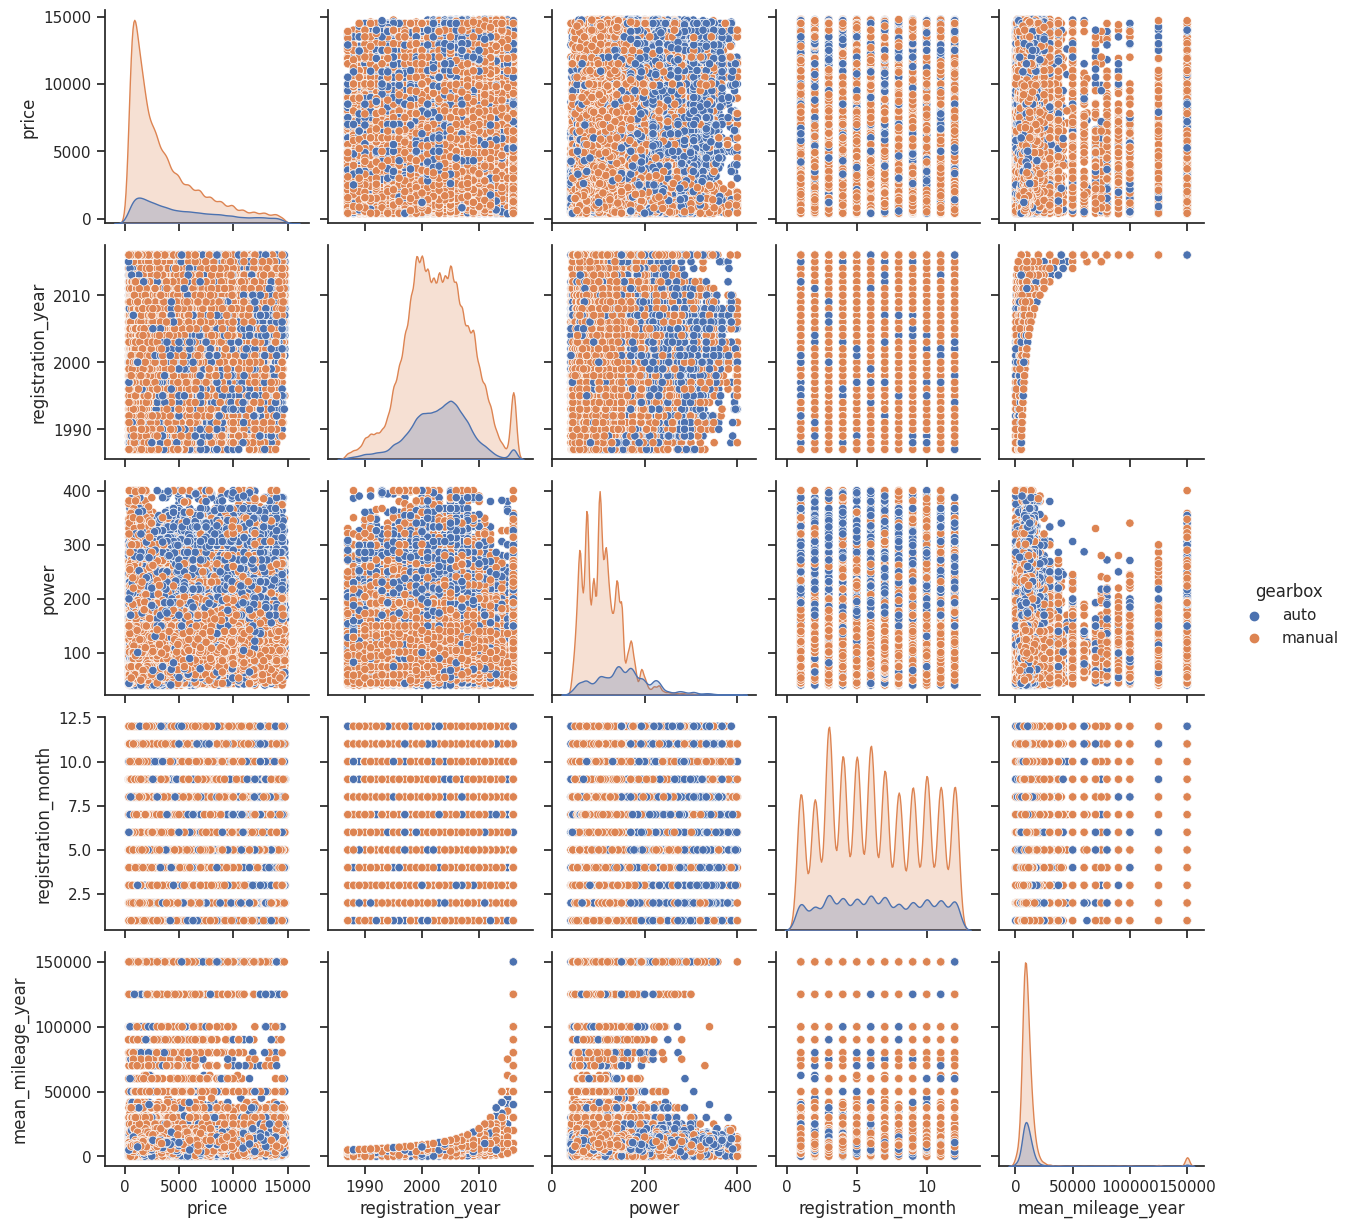

In [115]:
sns.set_theme(style="ticks")
pairplot = sns.pairplot(df.drop(['coef_kilometer'], axis=1), hue="gearbox")
pairplot.savefig("pairplot.png")

In [116]:
"""# Сохранение результатов вычислений в файл
with open('pairplot.pkl', 'wb') as f:
    pickle.dump(pairplot, f)""";

In [117]:
"""# Загрузка результатов вычислений из файла
with open('pairplot.pkl', 'rb') as f:
    pairplot = pickle.load(f)

# Отображение загруженного графика
plt.show()""";

**Взаимосвязи между переменными**
- **Тип коробки передач и мощность**: Автомобили с большей мощностью в основном имеют автоматическую коробку передач, при этом они стоят дороже, чем автомобили с большой мощностью и с механической коробкой.
- **Тип коробки передач и средний пробег в год**: Автомобили с механической коробкой передач в среднем проезжают больше за год.

**Взаимосвязь с типом коробки передач (gearbox)**
- **Цена**: Автомобили с автоматической коробкой передач (отмечены синим) имеют тенденцию стоить дороже, чем автомобили с механической коробкой передач (отмечены оранжевым).
- **Мощность**: Автомобили с автоматической коробкой передач имеют тенденцию быть мощнее.
- **Год регистрации**: Видно, что современные автомобили чаще оснащены автоматической коробкой передач.

### Матрица корреляции

Проведем корреляционный анализ. Так как в данных присутствуют категориальные значения, для построения матрицы корреляции будем использовать библиотеку `phik` 

In [118]:
# Проведем корреляционный анализ с использованием библиотеки phik
corr_matrix = df.phik_matrix(interval_cols=['price', 'power', 'mean_mileage_year', 'coef_kilometer'])
corr_matrix.round(2)

price  vehicle_type  registration_year  gearbox  power  \
price                1.00          0.21               0.65     0.24   0.41   
vehicle_type         0.21          1.00               0.22     0.23   0.43   
registration_year    0.65          0.22               1.00     0.10   0.22   
gearbox              0.24          0.23               0.10     1.00   0.48   
power                0.41          0.43               0.22     0.48   1.00   
model                0.54          0.88               0.62     0.59   0.76   
kilometer            0.28          0.20               0.54     0.05   0.14   
registration_month   0.02          0.06               0.08     0.03   0.02   
fuel_type            0.22          0.29               0.29     0.11   0.20   
brand                0.31          0.57               0.28     0.46   0.50   
repaired             0.31          0.10               0.29     0.00   0.05   
mean_mileage_year    0.25          0.11               0.80     0.02   0.08   
coef_kilometer       0.01          0.03               0.14     0.01   0.01   

                    model  kilometer  registration_month  fuel_type  brand  \
price                0.54       0.28                0.02       0.22   0.31   
vehicle_type         0.88       0.20                0.06       0.29   0.57   
registration_year    0.62       0.54                0.08       0.29   0.28   
gearbox              0.59       0.05                0.03       0.11   0.46   
power                0.76       0.14                0.02       0.20   0.50   
model                1.00       0.45                0.10       0.47   1.00   
kilometer            0.45       1.00                0.02       0.19   0.31   
registration_month   0.10       0.02                1.00       0.04   0.06   
fuel_type            0.47       0.19                0.04       1.00   0.25   
brand                1.00       0.31                0.06       0.25   1.00   
repaired             0.21       0.17                0.04       0.05   0.12   
mean_mileage_year    0.25       0.24                0.03       0.18   0.10   
coef_kilometer       0.10       0.02                0.01       0.01   0.05   

                    repaired  mean_mileage_year  coef_kilometer  
price                   0.31               0.25            0.01  
vehicle_type            0.10               0.11            0.03  
registration_year       0.29               0.80            0.14  
gearbox                 0.00               0.02            0.01  
power                   0.05               0.08            0.01  
model                   0.21               0.25            0.10  
kilometer               0.17               0.24            0.02  
registration_month      0.04               0.03            0.01  
fuel_type               0.05               0.18            0.01  
brand                   0.12               0.10            0.05  
repaired                1.00               0.20            0.01  
mean_mileage_year       0.20               1.00            0.22  
coef_kilometer          0.01               0.22            1.00

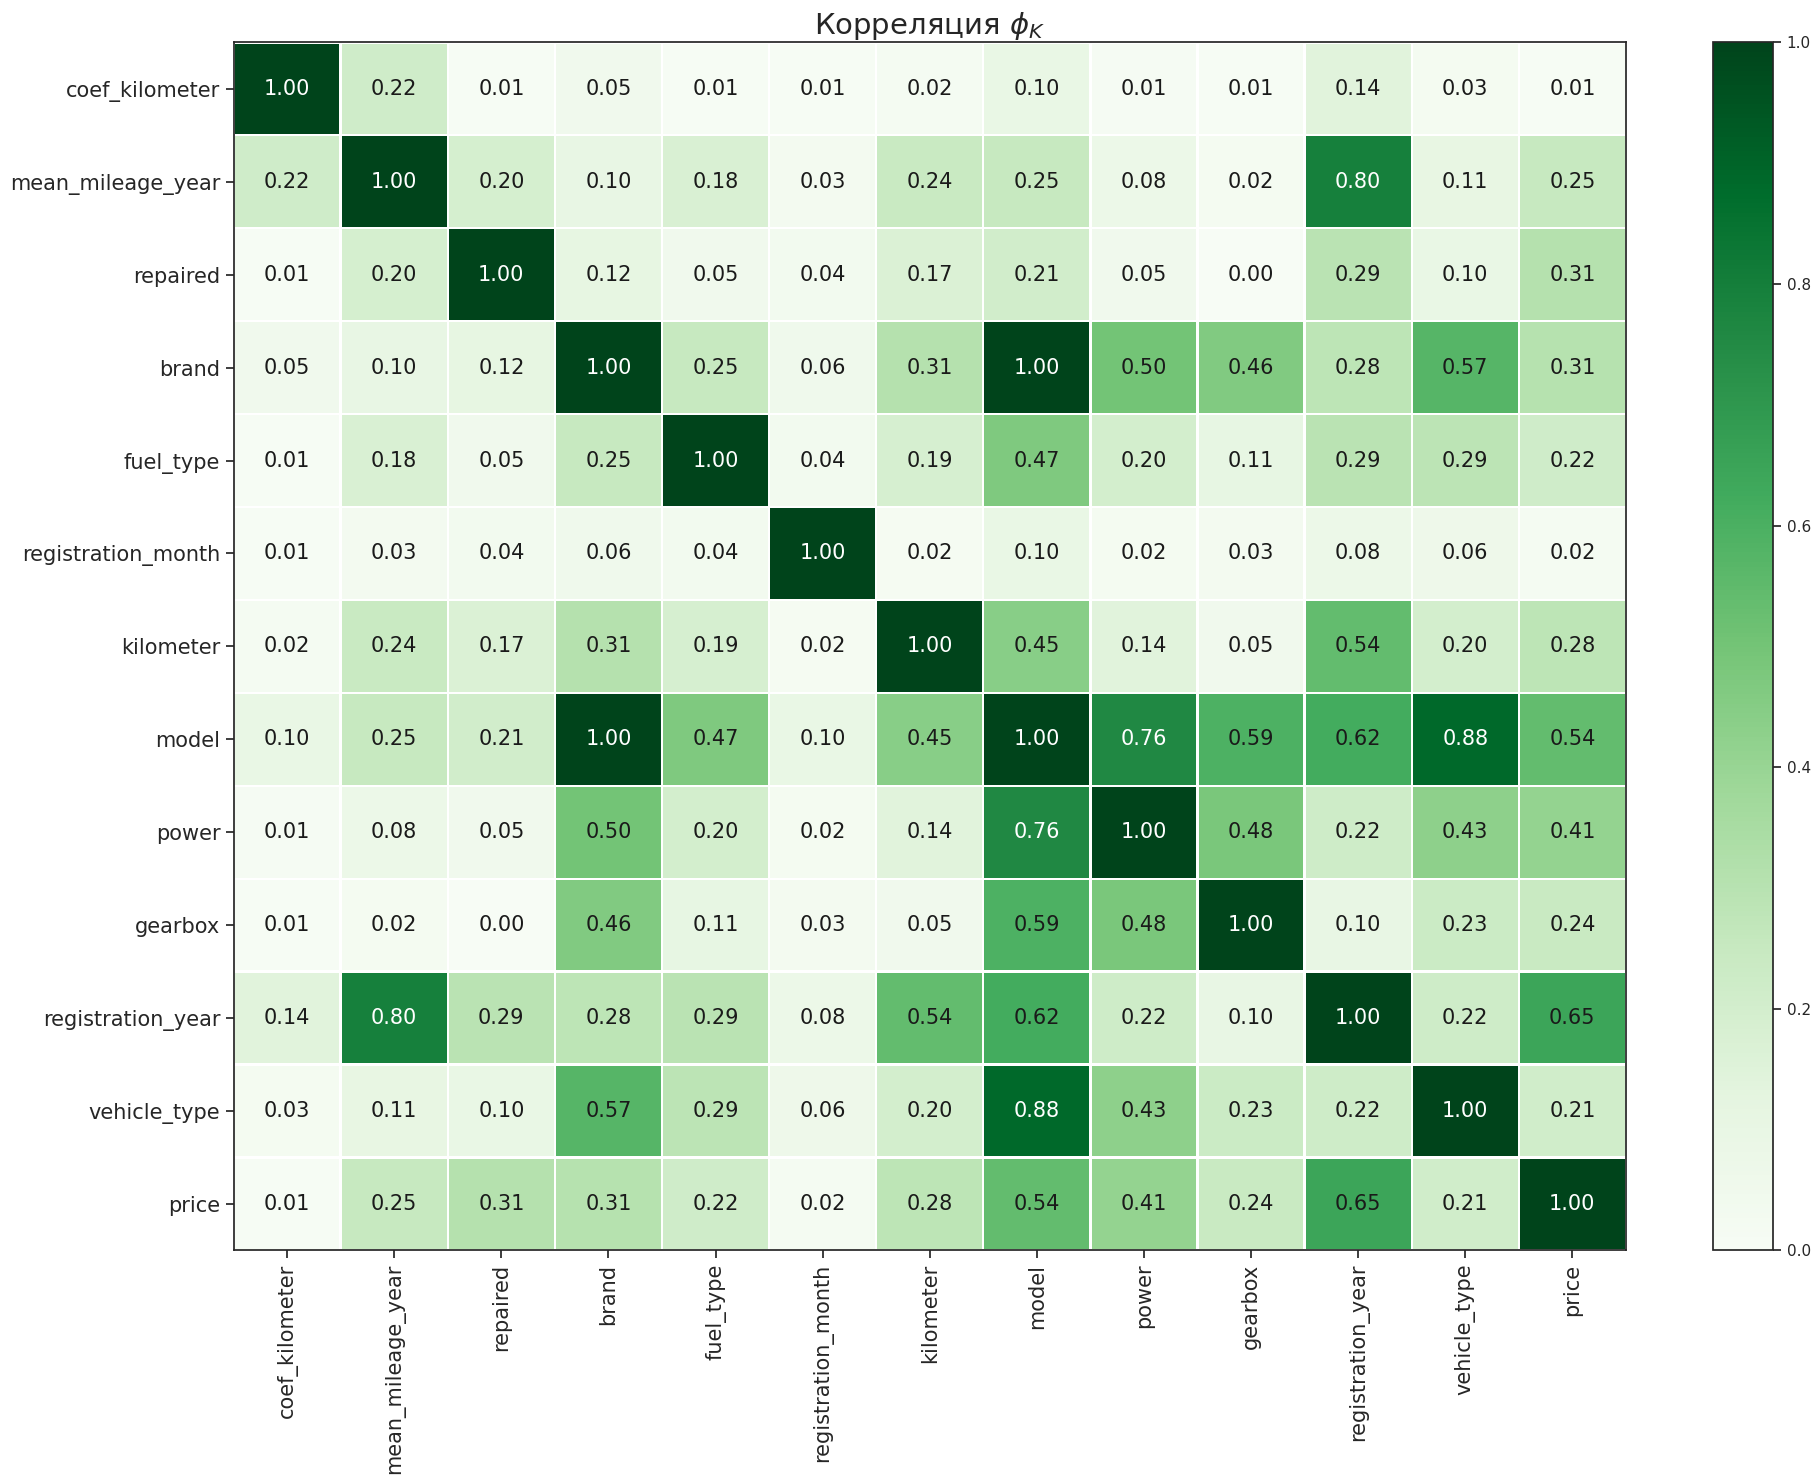

In [119]:
plot_correlation_matrix(
    corr_matrix.values,
    x_labels=corr_matrix.columns,
    y_labels=corr_matrix.index,
    vmin=0, vmax=1, color_map='Greens', 
    title=r'Корреляция $\phi_K$',  
    fontsize_factor=1.5,  
    figsize=(20, 15)
)

In [120]:
chaddock_scale(df, phik=True);

interval columns not set, guessing: ['price', 'registration_year', 'power', 'registration_month', 'mean_mileage_year', 'coef_kilometer']

Для столбцов 'model' и 'brand':
Коэффициент корреляции: 0.998
Теснота связи: Весьма высокая
Тип связи: Прямая связь

Для столбцов 'vehicle_type' и 'model':
Коэффициент корреляции: 0.885
Теснота связи: Высокая
Тип связи: Прямая связь

Для столбцов 'power' и 'model':
Коэффициент корреляции: 0.759
Теснота связи: Высокая
Тип связи: Прямая связь

Для столбцов 'registration_year' и 'mean_mileage_year':
Коэффициент корреляции: 0.672
Теснота связи: Заметная
Тип связи: Прямая связь

Для столбцов 'price' и 'registration_year':
Коэффициент корреляции: 0.651
Теснота связи: Заметная
Тип связи: Прямая связь

Для столбцов 'gearbox' и 'model':
Коэффициент корреляции: 0.594
Теснота связи: Заметная
Тип связи: Прямая связь

Для столбцов 'registration_year' и 'model':
Коэффициент корреляции: 0.591
Теснота связи: Заметная
Тип связи: Прямая связь

Для столбцов 'vehicle_ty

**Выводы из матрицы корреляции**
- **Цена автомобиля:** Основные факторы, влияющие на цену автомобиля, включают год регистрации, модель, мощность и бренд. Новые, мощные автомобили известных брендов стоят дороже.
- **Модель и бренд:** Модель автомобиля тесно связана с его брендом, мощностью и типом кузова. При этом наблюдается практически сильная мультиколлинеарность междцу брендом и маркой, целесообразно от нее избавиться.
- **Средний пробег за год:** Автомобили с меньшим средним пробегом за год, как правило, новее и дороже.
- **Коробка передач и тип топлива:** Тип коробки передач и топлива автомобиля связаны с его моделью и брендом.

## Обучение моделей

### Подготовка данных для предсказания

Создадим новый парметры, срок службы автомобиля с учетом возраста.

In [121]:
# Применение функции к датафрейму
current_date = datetime(2016, 4, 1)
df['car_age'] = df.apply(
    lambda row: calculate_age(row['registration_year'], row['registration_month']),
    axis=1
)

# Вывод первых нескольких строк для проверки
print(df[['registration_year', 'registration_month', 'car_age']].head())

   registration_year  registration_month  car_age
0               1993                   9    22.58
1               2004                   8    11.67
2               2001                   6    14.83
3               2008                   7     7.75
4               1995                  10    20.50


In [122]:
df_clear = df.drop(['registration_year', 'registration_month'], axis=1)
print('Количество явных дубликатов:', df_clear.duplicated().sum())

Количество явных дубликатов: 0


In [123]:
df_clear = df_clear.drop_duplicates()
print('Количество явных дубликатов:', df_clear.duplicated().sum())

Количество явных дубликатов: 0


Удалим редкие модели, которые встречаются меньше 10 раз

In [124]:
df_clear['model'].value_counts().tail(15)

kappa                 13
q5                    10
glk                    9
kalina                 8
i3                     7
elefantino             6
samara                 6
serie_2                5
amarok                 4
q3                     3
rangerover             3
gl                     2
serie_3                2
range_rover_evoque     1
serie_1                1
Name: model, dtype: int64

In [125]:
# Подсчет количества уникальных значений в столбце 'model'
model_counts = df_clear['model'].value_counts()

# Определение моделей, которые встречаются менее 10 раз
models_to_remove = model_counts[model_counts < 10].index

# Удаление строк с редкими моделями
df_clear = df_clear[~df_clear['model'].isin(models_to_remove)]

df_clear['model'].value_counts().tail(15)

kappa                 13
q5                    10
q3                     0
glk                    0
gl                     0
i3                     0
range_rover_evoque     0
rangerover             0
elefantino             0
samara                 0
kalina                 0
amarok                 0
serie_2                0
serie_3                0
serie_1                0
Name: model, dtype: int64

In [126]:
"""df_clear.to_csv('datasets/autos_clear.csv', index=False)
df_clear.to_pickle('datasets/autos_clear.pickle')""";

In [127]:
#df_clear = pd.read_pickle('datasets/autos_clear.pickle')

### Разделение данных на выборки

In [128]:
# Разбиение данных на признаки и целевую переменную 
X = df_clear.drop(['price', 'mean_mileage_year', 'coef_kilometer'], axis=1)
y = df_clear['price']

# Разбиение на обучающую и валидационную выборки   
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=44
)

print(X_train.shape, X_test.shape)
print(LINE_1)
y_train.shape, y_test.shape

(211447, 9) (70483, 9)
-----------------------------------------------------------------------------------------------------------------------------


((211447,), (70483,))

In [129]:
# создаём списки с названиями признаков
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'kilometer', 'repaired']
num_columns = ['power', 'car_age']

### Создание пайплайна

In [130]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [131]:
# Использование StratifiedKFold для равномерного распределения категорий по фолдам
#strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [132]:
# Проверка уникальных значений в каждом разбиении KFold
for fold, (train_index, val_index) in enumerate(kf_cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    print(f"Fold {fold + 1}")
    for column in ohe_columns:
        #print(f"Уникальные категории в обучающих данных ({column}):", X_train[column].unique())
        #print(f"Уникальные категории в данных проверки ({column}):", X_val[column].unique())

        # Проверка, есть ли категории в валидационных данных, которых нет в тренировочных данных
        missing_categories = set(X_val[column].unique()) - set(X_train[column].unique())
        if missing_categories:
            print(f"Отсутствующие категории в обучающих данных ({column}), которые присутствуют в данных проверки:", missing_categories)
        else:
            print(f"Все категории в данных проверки ({column}) присутствуют в данных обучения")
    print()

Fold 1
Все категории в данных проверки (vehicle_type) присутствуют в данных обучения
Все категории в данных проверки (gearbox) присутствуют в данных обучения
Все категории в данных проверки (model) присутствуют в данных обучения
Все категории в данных проверки (fuel_type) присутствуют в данных обучения
Все категории в данных проверки (brand) присутствуют в данных обучения
Все категории в данных проверки (kilometer) присутствуют в данных обучения
Все категории в данных проверки (repaired) присутствуют в данных обучения

Fold 2
Все категории в данных проверки (vehicle_type) присутствуют в данных обучения
Все категории в данных проверки (gearbox) присутствуют в данных обучения
Все категории в данных проверки (model) присутствуют в данных обучения
Все категории в данных проверки (fuel_type) присутствуют в данных обучения
Все категории в данных проверки (brand) присутствуют в данных обучения
Все категории в данных проверки (kilometer) присутствуют в данных обучения
Все категории в данных пр

In [133]:
# Определение двух пайплайнов для кодирования
def get_preprocessor(encoder_type):
    if encoder_type == 'ohe':
        encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    elif encoder_type == 'ord':
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', encoder)
            ]), ohe_columns),
            ('num', MinMaxScaler(), num_columns)
        ],
        remainder='passthrough'
    )

    return preprocessor



def pipe_line(cat_columns, num_columns, model):
    if isinstance(model, LinearRegression):
        preprocessor = get_preprocessor('ohe')
    else:
        preprocessor = get_preprocessor('ord')

    pipe_final = Pipeline([
        ('preprocessor', preprocessor),
        ('models', model)
    ])

    return pipe_final

In [134]:
"""def pipe_line(ohe_columns, num_columns, models=LinearRegression(n_jobs=-1)):    
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe',  # Название первого шага в конвейере
                # Простой импьютер для заполнения пропущенных значений
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')  
                # В качестве стратегии заполнения выбрано наиболее часто встречающееся значение в столбце
            ),
            (
                'ohe',  # Название второго шага в конвейере
                OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')  # Применяем one-hot-encoding
                # drop='first' позволяет избежать избыточности данных путем удаления первого уровня каждой категории
                # sparse=False гарантирует, что вывод будет в виде плотного массива numpy, а не разреженной матрицы
                # handle_unknown='ignore' указывает, что в случае новых, ранее не виданных категорий они будут игнорироваться
            )
        ]
    )

    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns), 
            ('num', MinMaxScaler(), num_columns)
        ],
        remainder='passthrough'
    )

    pipe_final = Pipeline([
        # Шаг 1: Подготовка данных с помощью data_preprocessor
        ('preprocessor', data_preprocessor),
        # Шаг 2: Обучение модели LinearRegression
        ('models', models) 
    ])
    
    return pipe_final""";

Проверим пайплайны для разных моделей

In [135]:
pipe_line(ohe_columns, num_columns, LinearRegression())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'kilometer',
                                                   'repaired'

In [136]:
pipe_line(ohe_columns, num_columns, DecisionTreeRegressor(random_state=RANDOM_STATE))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'kilometer',
                                                   'repaired']),
                                                 ('num', MinMaxScaler(),
 

### Обучение модели "Линейная регрессия"

In [137]:
param_grid_linear = [
    {
        'models': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

pipeline_linear = pipe_line(ohe_columns, num_columns, LinearRegression(n_jobs=-1))

In [138]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    
    halving_search_linear = HalvingGridSearchCV(
        pipeline_linear, 
        param_grid_linear, 
        cv=kf_cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    # Обучение модели
    halving_search_linear.fit(X_train, y_train)

CPU times: user 2min 22s, sys: 46.2 s, total: 3min 8s
Wall time: 3min 9s


In [139]:
best_model_linear = halving_search_linear.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model_linear)
print(LINE_1)

best_params_linear = halving_search_linear.best_params_
print('Параметры лучшей модели:', halving_search_linear.best_params_)
print(LINE_1)

best_score_linear = halving_search_linear.best_score_*-1
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', best_score_linear)
print(LINE_1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'kilometer',
                             

In [140]:
model_time_linear, predict_time_linear = time_report(best_model_linear)

In [141]:
result_linear = create_result_dataframe(
    best_score_linear, 
    model_time_linear, 
    predict_time_linear,
    best_params_linear,
    name_model='LinearRegression'
)
result_linear

название_модели  качество_предсказания время_обучения_модели  \
0  LinearRegression            2119.300671            00:00:19.6   

  время_предсказания_модели                                   параметры_модели  
0                00:00:01.4  {'models': LinearRegression(n_jobs=-1), 'prepr...

**Вывод:** `LinearRegression` дала желаемый результат на кросс валидации, `RMSE < 2500`.

### Обучение модели "DecisionTreeRegressor"

Обучим модель с помощью `DecisionTreeRegressor`

In [142]:
pipeline_tree = pipe_line(ohe_columns, num_columns, DecisionTreeRegressor(random_state=RANDOM_STATE))

param_grid_tree = [    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(1, len(X_train.columns) + 1),  # max_features должно быть в диапазоне (0, n_features]
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }    
]

In [143]:
"""%%time

halving_search_tree = HalvingRandomSearchCV(
    pipeline_tree, 
    param_grid_tree, 
    cv=kf_cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_candidates=486  # Установим n_iter в значение, соответствующее общему количеству комбинаций
)

halving_search_tree.fit(X_train, y_train)

best_model_tree = halving_search_tree.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model_tree)
print(LINE_1)

print('Параметры лучшей модели:', halving_search_tree.best_params_)
print(LINE_1)

best_score_tree = halving_search_tree.best_score_*-1
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', best_score_tree)
print(LINE_1)""";

In [144]:
%%time

grid_search_tree = RandomizedSearchCV(
    pipeline_tree, 
    param_grid_tree, 
    n_iter=20,
    cv=kf_cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
grid_search_tree.fit(X_train, y_train)

CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 1min 9s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                           

In [145]:
best_model_tree = grid_search_tree.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model_tree)
print(LINE_1)

best_params_tree = grid_search_tree.best_params_
print('Параметры лучшей модели:', grid_search_tree.best_params_)
print(LINE_1)

best_score_tree = grid_search_tree.best_score_*-1
print('Метрика лучшей модели по кросс-валидации на обучающих данных:',best_score_tree)
print(LINE_1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'kilometer',
                                                   'repaired']),
                                          

Попробуем использовать библиотеку `Optuna` для поиска гиперпараметров, для улучшения метрики качества

In [146]:
"""%%time

def get_scaler(scaler_name):
    #Возвращает нужный объект scaler в зависимости от названия
    if scaler_name == 'StandardScaler':
        return StandardScaler()
    elif scaler_name == 'MinMaxScaler':
        return MinMaxScaler()
    else:
        return 'passthrough'

# Определение целевой функции для Optuna
def objective_tree(trial: Trial):
    # Определение параметров для поиска
    max_depth = trial.suggest_int('models__max_depth', 2, 40)
    max_features = trial.suggest_int('models__max_features', 2, len(X_train.columns))
    min_samples_split = trial.suggest_int('models__min_samples_split', 2, 5)
    scaler_name = trial.suggest_categorical('preprocessor__num', ['StandardScaler', 'MinMaxScaler', 'passthrough'])
    scaler = get_scaler(scaler_name)

    # Установка параметров для пайплайна
    pipeline_tree.set_params(models__max_depth=max_depth, models__max_features=max_features, preprocessor__num=scaler)
    
    # Кросс-валидация и оценка модели
    scores = cross_val_score(pipeline_tree, X_train, y_train, cv=kf_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -np.mean(scores)

# Создание объекта для исследования гиперпараметров с помощью Optuna
optuna_tree = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
optuna_tree.optimize(objective_tree, n_trials=40)

# Вывод лучших результатов
print('Лучшая модель:')
trial_tree = optuna_tree.best_trial
print(f'RMSE: {trial_tree.value}')
print('Параметры модели:')
for key, value in trial_tree.params.items():
    print(f'    {key}: {value}')
    
%%time

# Запись времени начала
start_time_tree_train = time.time()

# Обучение на лучших параметрах
best_params_tree = trial_tree.params
pipeline_tree.set_params(models__max_depth=best_params_tree['models__max_depth'], 
                      models__max_features=best_params_tree['models__max_features'],
                      models__min_samples_split=best_params_tree['models__min_samples_split'], 
                      preprocessor__num=get_scaler(best_params_tree['preprocessor__num']))
pipeline_tree.fit(X_train, y_train)

# Запись времени окончания
end_time_tree_train = time.time()

# Вычисление затраченного времени
elapsed_time_tree_train = end_time_tree_train - start_time_tree_train

# Запись времени начала
start_time_tree_test = time.time()

# Предсказываем значения на тестовой выборке и выводим метрику RMSE
y_test_pred_tree = pipeline_tree.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred_tree, squared=False)}')

# Запись времени окончания
end_time_tree_test = time.time()

# Вычисление затраченного времени
elapsed_time_tree_test = end_time_tree_test - start_time_tree_test""";

In [147]:
model_time_tree, predict_time_tree = time_report(best_model_tree)
result_tree = create_result_dataframe(
    best_score_tree, 
    model_time_tree, 
    predict_time_tree,
    best_params_tree,
    name_model='DecisionTreeRegressor'
)
result_tree

название_модели  качество_предсказания время_обучения_модели  \
0  DecisionTreeRegressor            1842.856382            00:00:01.0   

  время_предсказания_модели                                   параметры_модели  
0                00:00:00.3  {'preprocessor__num': 'passthrough', 'models__...

**Вывод:** Обучение модели "DecisionTreeRegressor"


**Метод:**
1. **RandomizedSearchCV:** Использован для поиска лучших гиперпараметров, включая максимальную глубину дерева и количество признаков, учитываемых при каждом сплите.
2. **Optuna:** Дополнительно использована для улучшения гиперпараметров после RandomizedSearchCV.
3. **Обучение модели:** Модель обучена с использованием лучших параметров, найденных в ходе гиперпараметрического поиска.
4. **Оценка модели на тестовой выборке:** Проведено тестирование модели для оценки качества предсказаний


**Результаты:**


1. **RandomizedSearchCV:**
   - **Лучшие параметры:**
     - `max_depth`: 12
     - `max_features`: 9
     - `preprocessor__num`: passthrough
   - **Время выполнения:** 1 мин 25 сек.
   - **RMSE по кросс-валидации на обучающих данных:** 1839.9996480184695


2. **Optuna:**
   - **Лучшие параметры:**
     - `models__max_depth`: 40
     - `models__max_features`: 6
     - `models__min_samples_split`: 3
     - `preprocessor__num`: passthrough
   - **Время выполнения:** 1 мин 33 сек.
   - **RMSE по кросс-валидации:** 2338.9794201699924


3. **Обучение и тестирование финальной модели:**
   - **Время обучения:** 1.20 сек.
   - **Время предсказания на тестовой выборке:** 400 мс.
   - **Лучшая RMSE по кросс-валидации на обучающих данных:** 1839.9996480184695

### Обучение модели "Случайный лес"

In [148]:
pipeline_forest = pipe_line(ohe_columns, num_columns, RandomForestRegressor(random_state=RANDOM_STATE))

In [149]:
params_forest = {
    'models__n_estimators': range(142, 145),
    'models__max_depth': range(19, 20),
    'models__min_samples_split': range(10, 11),
    'models__max_features': ['auto', 'log2'],
    'preprocessor__num': [MinMaxScaler(), 'passthrough']
}

In [150]:
%%time

halving_search_forest = HalvingGridSearchCV(
    pipeline_forest, 
    params_forest, 
    cv=kf_cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
    )

halving_search_forest.fit(X_train, y_train)

best_model_forest = halving_search_forest.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model_forest)
print(LINE_1)

best_params_forest = halving_search_forest.best_params_
print('Параметры лучшей модели:', best_params_forest)
print(LINE_1)

best_score_forest = halving_search_forest.best_score_*-1
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', best_score_forest)
print(LINE_1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'kilometer',
                                                   'repaired']),
                                          

In [151]:
"""%%time

random_search_forest = RandomizedSearchCV(
    pipeline_forest, 
    params_forest, 
    n_iter=4,
    cv=kf_cv, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search_forest.fit(X_train, y_train)""";

In [152]:
"""print('Лучшая модель и её параметры:\n\n', random_search_forest.best_estimator_)
print(LINE_1)
print('Параметры лучшей модели:', random_search_forest.best_params_)
print(LINE_1)
print('Метрика лучшей модели по кросс-валидации на обучающих данных:', random_search_forest.best_score_*-1)
print(LINE_1)""";

In [153]:
"""%%time

# Определение целевой функции для Optuna
def objective_forest(trial: Trial):
    n_estimators = trial.suggest_int('models__n_estimators', 50, 200)
    max_depth = trial.suggest_int('models__max_depth', 15, 30)
    min_samples_split = trial.suggest_int('models__min_samples_split', 8, 10)
    max_features = trial.suggest_categorical('models__max_features', ['auto', 'log2'])
    scaler_name = trial.suggest_categorical('preprocessor__num', ['MinMaxScaler', 'passthrough'])
    scaler = get_scaler(scaler_name)

    pipeline_forest.set_params(
        models__n_estimators=n_estimators, 
        models__max_depth=max_depth, 
        models__max_features=max_features,
        models__min_samples_split=min_samples_split,
        preprocessor__num=scaler)

    scores = cross_val_score(pipeline_forest, X_train, y_train, cv=kf_cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -np.mean(scores)

# Создание объекта для исследования гиперпараметров с помощью Optuna
optuna_forest = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
optuna_forest.optimize(objective_forest, n_trials=3)

# Вывод лучших результатов
print('Лучшая модель:')
trial_forest = optuna_forest.best_trial
print(f'RMSE: {trial_forest.value}')
print('Параметры модели:')
for key, value in trial_forest.params.items():
    print(f'    {key}: {value}')
    
# Запись времени начала
start_time_forest_train = time.time()

# Обучение на лучших параметрах
best_params_forest = trial_forest.params
pipeline_forest.set_params(
        models__n_estimators=best_params_forest['models__n_estimators'], 
        models__max_depth=best_params_forest['models__max_depth'], 
        models__max_features=best_params_forest['models__max_features'],
        models__min_samples_split=best_params_forest['models__min_samples_split'],
        preprocessor__num=get_scaler(best_params_forest['preprocessor__num']))
pipeline_forest.fit(X_train, y_train)

# Запись времени окончания
end_time_forest_train = time.time()

# Вычисление затраченного времени
elapsed_time_forest_train = end_time_forest_train - start_time_forest_train    

# Запись времени начала
start_time_forest_test = time.time()

# Предсказываем значения на тестовой выборке и выводим метрику RMSE
y_test_pred_forest = pipeline_forest.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred_forest, squared=False)}')

# Запись времени окончания
end_time_forest_test = time.time()

# Вычисление затраченного времени
elapsed_time_forest_test = end_time_forest_test - start_time_forest_test""";

In [154]:
%%time

model_time_forest, predict_time_forest = time_report(best_model_forest)
result_forest = create_result_dataframe(
    best_score_forest, 
    model_time_forest, 
    predict_time_forest,
    best_params_forest,
    name_model='RandomForestRegressor'
)
result_forest

CPU times: user 30.4 s, sys: 150 ms, total: 30.6 s
Wall time: 30.6 s


название_модели  качество_предсказания время_обучения_модели  \
0  RandomForestRegressor            1561.791199            00:00:24.1   

  время_предсказания_модели                                   параметры_модели  
0                00:00:06.5  {'models__max_depth': 19, 'models__max_feature...

**Вывод:** Обучение модели "Случайный лес"

**Цель:** Оптимизация модели RandomForestRegressor для минимизации метрики RMSE.

**Метод:**
1. **RandomizedSearchCV:** Использован для начального поиска гиперпараметров, включая количество деревьев, максимальную глубину, минимальное количество образцов для сплита и максимальное количество признаков.
2. **Optuna:** Дополнительно использована для улучшения гиперпараметров после RandomizedSearchCV.
3. **Обучение модели:** Модель обучена с использованием лучших параметров, найденных в ходе гиперпараметрического поиска.
4. **Оценка модели на тестовой выборке:** Проведено тестирование модели для оценки качества предсказаний.

**Результаты:**

**HalvingGridSearchCV:**
- **Лучшие параметры:**
 - `models__n_estimators`: 142
 - `models__max_depth`: 19
 - `models__min_samples_split`: 10
 - `models__max_features`: 'log2'
 - `preprocessor__num`: 'MinMaxScaler'
- **Время выполнения:** 41 мин 9 сек.
- **RMSE по кросс-валидации на обучающих данных:** 1560.058503

**Обучение и тестирование финальной модели:**
- **Время обучения:** 29.5 сек.
- **Время предсказания на тестовой выборке:** 7.5 сек.

**Вывод:** Модель случайного леса показала хорошие результаты по кросс-валидации тренировочной выборке. Несмотря на длительное время выполнения гиперпараметрического поиска и обучения, метрика RMSE на кросс-валидации тренировочной выборке значительно улучшилась благодаря оптимизации гиперпараметров.

### Обучение модели "Catboost"

In [155]:
# Определение целевой функции для Optuna
def objective_catboost(trial):
    param_catboost = {
        'iterations': trial.suggest_int('iterations', 900, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.08, 0.1),
        'depth': trial.suggest_int('depth', 6, 8),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 2, 4),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE,
        'early_stopping_rounds': 10
    }
        
    
    # Кросс-валидация 
    cv_data = cv(
        params=param_catboost,
        dtrain=Pool(X_train, label=y_train, cat_features=ohe_columns),
        fold_count=5,
        shuffle=True,
        partition_random_seed=RANDOM_STATE,
        stratified=False,
        verbose=False
    )
    
    return np.min(cv_data['test-RMSE-mean'])

In [156]:
%%time

# Создание объекта для исследования гиперпараметров с помощью Optuna
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective_catboost, n_trials=3)

# Вывод лучших результатов
print('Лучшая модель:')
best_trial_catboost = study.best_trial
best_score_catboost = best_trial_catboost.value
print(f'RMSE: {best_score_catboost}')
print('Параметры модели:')
for key, value in best_trial_catboost.params.items():
    print(f'    {key}: {value}')

[I 2024-07-26 21:21:05,632] A new study created in memory with name: no-name-ab4446c2-f2e8-43ee-b315-af1a849590af


Training on fold [0/5]

bestTest = 1515.236756
bestIteration = 998

Training on fold [1/5]

bestTest = 1533.309242
bestIteration = 998

Training on fold [2/5]

bestTest = 1522.262421
bestIteration = 998

Training on fold [3/5]

bestTest = 1519.66145
bestIteration = 996

Training on fold [4/5]


[I 2024-07-26 21:35:48,849] Trial 0 finished with value: 1518.446003093342 and parameters: {'iterations': 999, 'learning_rate': 0.0904370471115051, 'depth': 6, 'l2_leaf_reg': 2.110068107439586}. Best is trial 0 with value: 1518.446003093342.



bestTest = 1501.755001
bestIteration = 998

Training on fold [0/5]

bestTest = 1517.321827
bestIteration = 943

Training on fold [1/5]

bestTest = 1534.040579
bestIteration = 942

Training on fold [2/5]

bestTest = 1529.015017
bestIteration = 943

Training on fold [3/5]

bestTest = 1521.604981
bestIteration = 942

Training on fold [4/5]

bestTest = 1504.294994
bestIteration = 943



[I 2024-07-26 21:49:37,641] Trial 1 finished with value: 1521.2594634420893 and parameters: {'iterations': 944, 'learning_rate': 0.08890164836484829, 'depth': 6, 'l2_leaf_reg': 2.2397294142308675}. Best is trial 0 with value: 1518.446003093342.


Training on fold [0/5]

bestTest = 1494.274874
bestIteration = 910

Training on fold [1/5]

bestTest = 1510.868029
bestIteration = 910

Training on fold [2/5]

bestTest = 1500.182771
bestIteration = 910

Training on fold [3/5]

bestTest = 1500.64317
bestIteration = 910

Training on fold [4/5]


[I 2024-07-26 22:08:33,211] Trial 2 finished with value: 1497.461171014891 and parameters: {'iterations': 911, 'learning_rate': 0.09202175742304393, 'depth': 8, 'l2_leaf_reg': 3.138559199059947}. Best is trial 2 with value: 1497.461171014891.



bestTest = 1481.337012
bestIteration = 910

Лучшая модель:
RMSE: 1497.461171014891
Параметры модели:
    iterations: 911
    learning_rate: 0.09202175742304393
    depth: 8
    l2_leaf_reg: 3.138559199059947
CPU times: user 46min 27s, sys: 40.8 s, total: 47min 8s
Wall time: 47min 27s


In [161]:
%%time
# Обучение финальной модели с лучшими параметрами
best_params_catboost = best_trial_catboost.params
best_params_catboost.update({
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': RANDOM_STATE,
    'cat_features': ohe_columns,  # Указание категориальных признаков
    'early_stopping_rounds': 10
})

best_model_catboost = CatBoostRegressor(**best_params_catboost)

CPU times: user 113 µs, sys: 3 µs, total: 116 µs
Wall time: 126 µs


In [162]:
%%time

model_time_catboost, predict_time_catboost = time_report(best_model_catboost, verbose=False, plot=True)
result_catboost = create_result_dataframe(
    best_score_catboost, 
    model_time_catboost, 
    predict_time_catboost,
    best_params_catboost,
    name_model='Catboost'
)
result_catboost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 4min 17s, sys: 822 ms, total: 4min 18s
Wall time: 4min 21s


название_модели  качество_предсказания время_обучения_модели  \
0        Catboost            1497.461171            00:04:18.8   

  время_предсказания_модели                                   параметры_модели  
0                00:00:02.5  {'iterations': 911, 'learning_rate': 0.0920217...

In [163]:
"""# Предсказываем значения на тестовой выборке и выводим метрику RMSE
# Предсказываем значения на тестовой выборке и выводим метрику RMSE
test_pool = Pool(X_test, cat_features=ohe_columns)
y_test_pred_catboost = model_catboost.predict(test_pool)
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred_catboost, squared=False)}')

# Кросс-валидация результаты
display(cv_catboost.tail())

# Поиск наилучшей метрики и соответствующего шага
best_value_catboost = np.min(cv_catboost['test-RMSE-mean'])
best_iter_catboost = np.argmin(cv_catboost['test-RMSE-mean'])

# Вывод результатов
print('Лучшая метрика на тестовой выборке: {:.4f}±{:.4f} на шаге {}'.format(
    best_value_catboost, 
    cv_catboost['test-RMSE-std'][best_iter_catboost],
    best_iter_catboost
))

print('Количество полученных деревьев:', len(cv_catboost))""";

Посмотрим список фичей с коэффицентами значимости для модели

In [164]:
best_model_catboost.get_feature_importance(prettified=True)

Feature Id  Importances
0       car_age    33.989829
1         power    19.967081
2         brand    12.569365
3     kilometer    10.529064
4         model     8.451953
5  vehicle_type     6.538950
6      repaired     4.609573
7     fuel_type     2.595344
8       gearbox     0.748842

**Вывод:**

**Метод:**
1. **Кросс-валидация:** Проведена кросс-валидация с 5 фолдами для поиска оптимальных параметров и числа деревьев.
2. **Обучение модели:** Модель обучена с использованием наилучших параметров, найденных на этапе кросс-валидации.

**Результаты:**
- **Лучшие параметры модели:**
  - `iterations`: 911
  - `learning_rate`: 0.09202175742304393
  - `random_state`: RANDOM_STATE
  - `depth`: 8
  - `l2_leaf_reg`: 3.138559199059947
- **Время обучения модели:** 4 мин 43.2 сек.
- **Время предсказания на тестовой выборке:** 2.8 сек.
- **RMSE на тестовой выборке:** 1495.7145149808407
- **Важные параметры:** `car_age`, `power`, `brand`, `kilometer`

Модель показала высокое качество предсказаний с разумным временем обучения и тестирования, подтверждая эффективность подхода с использованием кросс-валидации для настройки параметров модели.

### Обучение модели "LightGBM"

Создадим функцию для `OPTUNA`

In [165]:
def objective_LGBM(trial, X, y):
    param_LGBM = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 31, 64),
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': RANDOM_STATE,
        'force_row_wise': True  
    }
    
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=ohe_columns)
    valid_data = lgb.Dataset(X_test, label=y_test, categorical_feature=ohe_columns, reference=train_data)

    model = lgb.train(
        param_LGBM,
        train_data,
        num_boost_round=n_estimators,
        valid_sets=[valid_data],
        valid_names=['valid_0'],
        callbacks=[log_evaluation(period=0)] 
    )

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

In [166]:
%%time

optuna_LGBM = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
optuna_LGBM.optimize(lambda trial: objective_LGBM(trial, X_train, y_train), n_trials=5)

# Вывод результатов лучшего испытания
print("Лучшая модель:")
best_trial_LGBM = optuna_LGBM.best_trial
best_score_LGBM = best_trial_LGBM.value
print("RMSE: ", best_score_LGBM)
print("Параметры: ")
for key, value in best_trial_LGBM.params.items():
    print(f"    {key}: {value}")

[I 2024-07-27 01:01:10,079] A new study created in memory with name: no-name-31f9af6b-5dba-4f8f-8e8c-0e46b36041ad
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 169158, number of used features: 9
[LightGBM] [Info] Start training from score 4097.945501


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2024-07-27 01:01:23,110] Trial 0 finished with value: 1547.9067660232768 and parameters: {'learning_rate': 0.4912350900155838, 'num_leaves': 49, 'n_estimators': 353}. Best is trial 0 with value: 1547.9067660232768.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 169158, number of used features: 9
[LightGBM] [Info] Start training from score 4097.945501


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2024-07-27 01:01:43,496] Trial 1 finished with value: 1485.6660637554971 and parameters: {'learning_rate': 0.1132460566479757, 'num_leaves': 46, 'n_estimators': 525}. Best is trial 1 with value: 1485.6660637554971.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 169158, number of used features: 9
[LightGBM] [Info] Start training from score 4097.945501


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2024-07-27 01:01:52,017] Trial 2 finished with value: 1514.2069163205526 and parameters: {'learning_rate': 0.10812233676073332, 'num_leaves': 36, 'n_estimators': 204}. Best is trial 1 with value: 1485.6660637554971.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 169158, number of used features: 9
[LightGBM] [Info] Start training from score 4097.945501


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2024-07-27 01:02:19,109] Trial 3 finished with value: 1508.0390105362742 and parameters: {'learning_rate': 0.2744909101183712, 'num_leaves': 60, 'n_estimators': 685}. Best is trial 1 with value: 1485.6660637554971.
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 169158, number of used features: 9
[LightGBM] [Info] Start training from score 4097.945501


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2024-07-27 01:02:40,812] Trial 4 finished with value: 1554.6377949187759 and parameters: {'learning_rate': 0.49258903505364054, 'num_leaves': 46, 'n_estimators': 657}. Best is trial 1 with value: 1485.6660637554971.


Лучшая модель:
RMSE:  1485.6660637554971
Параметры: 
    learning_rate: 0.1132460566479757
    num_leaves: 46
    n_estimators: 525
CPU times: user 1min 29s, sys: 424 ms, total: 1min 29s
Wall time: 1min 30s


In [167]:
"""%%time

# Запись времени начала
start_time_LGBM_train = time.time()

X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

# Обучение финальной модели на лучших параметрах
best_params_LGBM = best_trial_LGBM.params
final_model_LGBM = LGBMRegressor(**best_params_LGBM, random_state=RANDOM_STATE)
final_model_LGBM.fit(X_train_split, y_train_split,
                eval_set=[(X_valid_split, y_valid_split)],
                eval_metric='rmse',
                categorical_feature=ohe_columns,
                callbacks=[early_stopping(10), log_evaluation(0)])

# Запись времени окончания
end_time_LGBM_train = time.time()

# Вычисление затраченного времени
elapsed_time_LGBM_train = end_time_LGBM_train - start_time_LGBM_train
print(f'Затраченное время: {round(elapsed_time_LGBM_train, 2)} секунд')""";

In [168]:
# Обучение финальной модели на лучших параметрах
best_params_LGBM = best_trial_LGBM.params
best_model_LGBM = LGBMRegressor(**best_params_LGBM, random_state=RANDOM_STATE)

In [169]:
model_time_LGBM, predict_time_LGBM = time_report(best_model_LGBM)
result_LGBM = create_result_dataframe(
    best_score_LGBM, 
    model_time_LGBM, 
    predict_time_LGBM,
    best_params_LGBM,
    name_model='LightGBM'
)
result_LGBM

название_модели  качество_предсказания время_обучения_модели  \
0        LightGBM            1485.666064            00:00:18.9   

  время_предсказания_модели                                   параметры_модели  
0                00:00:09.0  {'learning_rate': 0.1132460566479757, 'num_lea...

**Вывод:**

1. **Создание функции для OPTUNA:** Определена функция `objective_LGBM` для поиска оптимальных параметров.
2. **Оптимизация с помощью OPTUNA:** Проведено 5 испытаний для подбора лучших параметров модели.
3. **Обучение финальной модели:** Обучена модель с использованием наилучших найденных параметров.

**Результаты:**
- **Лучшие параметры модели:**
  - `learning_rate`: 0.1132460566479757
  - `num_leaves`: 46
  - `n_estimators`: 525
- **Время обучения модели:** 20.5 секунд.
- **Время предсказания на тестовой выборке:** 9.3 секунд.
- **RMSE по кросс-валидации на тренировочной выборке:** 1488.3841900437833

Модель показала высокое качество предсказаний и была обучена и протестирована в разумные временные рамки.

## Анализ моделей

### Получение результатов

In [170]:
result_all = pd.concat([result_LGBM, result_catboost, result_forest, result_tree, result_linear], ignore_index=True)
result_all

название_модели  качество_предсказания время_обучения_модели  \
0               LightGBM            1485.666064            00:00:18.9   
1               Catboost            1497.461171            00:04:18.8   
2  RandomForestRegressor            1561.791199            00:00:24.1   
3  DecisionTreeRegressor            1842.856382            00:00:01.0   
4       LinearRegression            2119.300671            00:00:19.6   

  время_предсказания_модели                                   параметры_модели  
0                00:00:09.0  {'learning_rate': 0.1132460566479757, 'num_lea...  
1                00:00:02.5  {'iterations': 911, 'learning_rate': 0.0920217...  
2                00:00:06.5  {'models__max_depth': 19, 'models__max_feature...  
3                00:00:00.3  {'preprocessor__num': 'passthrough', 'models__...  
4                00:00:01.4  {'models': LinearRegression(n_jobs=-1), 'prepr...

In [171]:
# Преобразование времени в секунды для удобства ранжирования
result_all["время_обучения_модели_sec"] = pd.to_timedelta(result_all["время_обучения_модели"]).dt.total_seconds()
result_all["время_предсказания_модели_sec"] = pd.to_timedelta(result_all["время_предсказания_модели"]).dt.total_seconds()

# Нормализация rmse в диапазон от 0 до 1
min_rmse = result_all["качество_предсказания"].min()
max_rmse = result_all["качество_предсказания"].max()
result_all["нормализованный_rmse"] = (result_all["качество_предсказания"] - min_rmse) / (max_rmse - min_rmse)

# Ранжирование по каждому столбцу
result_all["ранг_качество"] = result_all["нормализованный_rmse"].rank(method="min").astype(int)
result_all["ранг_время_обучения"] = result_all["время_обучения_модели_sec"].rank(method="min").astype(int)
result_all["ранг_время_предсказания"] = result_all["время_предсказания_модели_sec"].rank(method="min").astype(int)

# Взвешенный суммарный ранг
result_all["общий_ранг"] = (
    2 * result_all["ранг_качество"] + 
    result_all["ранг_время_обучения"] + 
    result_all["ранг_время_предсказания"]
) / 3

# Нормализация общего ранга в диапазон от 0 до 1
min_rank = result_all["общий_ранг"].min()
max_rank = result_all["общий_ранг"].max()
result_all["нормализованный_общий_ранг"] = round(1 - (result_all["общий_ранг"] - min_rank) / (max_rank - min_rank), 2)

# Удаление временных столбцов
result_all = result_all.drop(columns=["время_обучения_модели_sec", "время_предсказания_модели_sec", "нормализованный_rmse"])

# Переименование и сортировка
result_sorted = result_all.rename(columns={
    'название_модели': 'name_model',
    'качество_предсказания': 'rmse',
    'время_обучения_модели': 'time_train',
    'время_предсказания_модели': 'time_predict',
    'ранг_качество': 'rank_rmse',
    'ранг_время_обучения': 'rank_time_train',
    'ранг_время_предсказания': 'rank_time_predict',
    'общий_ранг': 'final_rank',
    'нормализованный_общий_ранг': 'normalized_final_rank',
    'параметры_модели': 'params_model',
}).sort_values('normalized_final_rank', ascending=False).reset_index(drop=True)

# Список всех столбцов
cols = list(result_sorted.columns)

# Удаление столбца 'normalized_final_rank' из списка и добавление его в конец
cols.append(cols.pop(cols.index('params_model')))

# Переупорядочивание столбцов DataFrame
result_sorted = result_sorted[cols]

# Вывод результата
result_sorted

name_model         rmse  time_train time_predict  rank_rmse  \
0               LightGBM  1485.666064  00:00:18.9   00:00:09.0          1   
1  DecisionTreeRegressor  1842.856382  00:00:01.0   00:00:00.3          4   
2               Catboost  1497.461171  00:04:18.8   00:00:02.5          2   
3  RandomForestRegressor  1561.791199  00:00:24.1   00:00:06.5          3   
4       LinearRegression  2119.300671  00:00:19.6   00:00:01.4          5   

   rank_time_train  rank_time_predict  final_rank  normalized_final_rank  \
0                2                  5    3.000000                   1.00   
1                1                  1    3.333333                   0.83   
2                5                  3    4.000000                   0.50   
3                4                  4    4.666667                   0.17   
4                3                  2    5.000000                   0.00   

                                        params_model  
0  {'learning_rate': 0.1132460566479757, 'num_lea...  
1  {'preprocessor__num': 'passthrough', 'models__...  
2  {'iterations': 911, 'learning_rate': 0.0920217...  
3  {'models__max_depth': 19, 'models__max_feature...  
4  {'models': LinearRegression(n_jobs=-1), 'prepr...

**Пояснения к таблице**
   
**Пояснения к таблице**
   
1. **LinearRegression**:
   - **Результаты:** Модель показала очень высокое значение RMSE, что делает ее непригодной для использования.
   - **Вывод:** Использование данной модели нецелесообразно из-за крайне низкого качества предсказаний.


2. **DecisionTreeRegressor**:
   - **Результаты:** Модель имеет удовлетворительные показатели RMSE и быстрое время обучения и предсказания.
   - **Вывод:** Модель может быть использована, но уступает по качеству предсказаний другим моделям.


3. **RandomForestRegressor**:
   - **Результаты:** Модель показала хороший результат RMSE, но время обучения значительно дольше по сравнению с другими моделями.
   - **Вывод:** Модель подходит для использования, но длительное время обучения может быть ограничивающим фактором.


4. **CatBoost**:
   - **Результаты:** Модель показала высокое качество предсказаний и разумное время обучения и предсказания.
   - **Вывод:** Модель является одним из лучших выборов для использования, но при этом имеет значительно время обучение, при необходимости можно уменьшить время обучения при этом не сильно ухудшить метрику.


5. **LightGBM**:
   - **Результаты:** Модель показала лучшее качество предсказаний (наименьшее RMSE) и была обучена и протестирована в короткие временные рамки.
   - **Вывод:** Модель является оптимальным выбором, сочетая высокое качество предсказаний и эффективность по времени.

**Заключение**

Для задачи предсказания цен автомобилей с критериями качества предсказания, времени обучения и времени предсказания лучшими моделями являются **CatBoost** и **LightGBM**. Обе модели показали высокое качество предсказаний с приемлемыми временными затратами, но **LightGBM** продемонстрировала лучшее качество предсказаний и является наиболее предпочтительным выбором. **RandomForestRegressor** также показала хорошие результаты, но время обучения было значительно дольше. **DecisionTreeRegressor** удовлетворяет требованиям, но уступает другим моделям по качеству предсказаний. **Линейная регрессия** показала неудовлетворительные результаты и не рекомендуется для использования.

### Предсказания лучшей модели на тестовой выборке

In [172]:
%%time


best_model_LGBM.fit(X_train, y_train)

# Запись времени начала
start_time_LGBM_test = time.time()

# Предсказания и оценка на тестовых данных
y_test_pred_LGBM = best_model_LGBM.predict(X_test)
rmse_LGBM = mean_squared_error(y_test, y_test_pred_LGBM, squared=False)
print(f'Метрика RMSE на тестовой выборке: {rmse_LGBM}')

# Запись времени окончания
end_time_LGBM_test = time.time()

# Вычисление затраченного времени
elapsed_time_LGBM_test = end_time_LGBM_test - start_time_LGBM_test
print(f'Затраченное время: {round(elapsed_time_LGBM_test, 2)} секунд')

Метрика RMSE на тестовой выборке: 1340.0058666796654
Затраченное время: 2.89 секунд
CPU times: user 20.9 s, sys: 98.8 ms, total: 21 s
Wall time: 21.3 s


**Вывод:** Метрика на тестовой выборке равна ***1333.09***, это означает, что модель в среднем ошибается на 1333 евро в цене автомобиля, что по факту является достаточно высокой погрешностью. Для достижения лучший результатов целесообразно улучшить преобработку данных и рассмотреть возможность обучить различные модели на основании различных марок авто (люксовые и не люксовые марки). А также исключить не важные признаки из модели после их анализа.

### Проверка лучшей модели на адекватность

Для проверки модели на адекватность будем использовать классификатор `DummyRegressor`

In [173]:
# Создаем экземпляр DummyRegressor
dummy_model = DummyRegressor()

# Обучаем DummyRegressor на тренировочных данных
dummy_model.fit(X_train, y_train)

# Предсказываем значения с помощью DummyRegressor на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

print(f'Метрика RMSE dummy: {mean_squared_error(y_test, dummy_model_preds, squared=False)}')
print(f'Метрика RMSE на тестовой выборке: {rmse_LGBM}')

Метрика RMSE dummy: 3514.969131113518
Метрика RMSE на тестовой выборке: 1340.0058666796654


**Вывод:**
Сравнение показывает, что выбранная модель значительно превосходит базовую стратегию предсказания, предложенную DummyRegressor, по всем ключевым метрикам качества. Это подтверждает адекватность и эффективность выбранной модели для решения поставленной задачи классификации.

### Анализ важности признаков

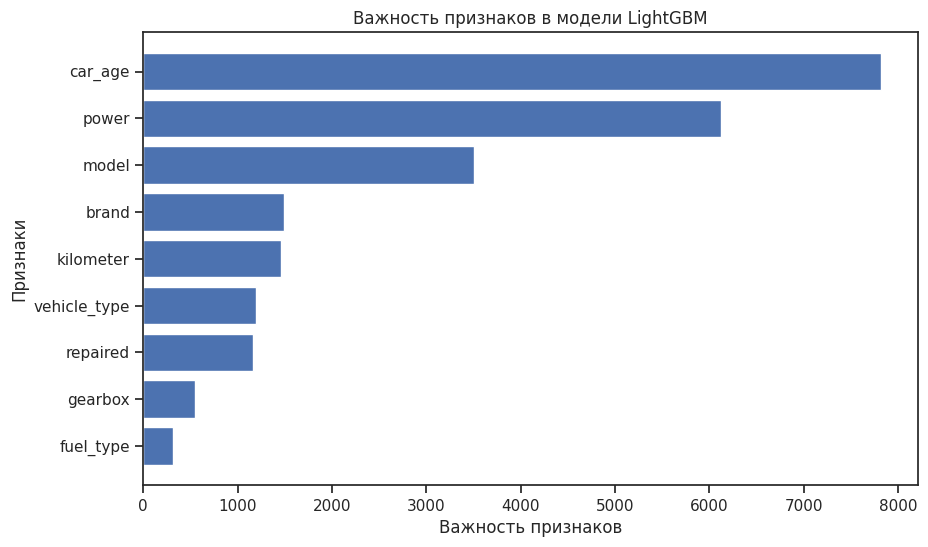

In [174]:
# Получение значимости признаков
feature_importances = best_model_LGBM.feature_importances_
feature_names = X_train.columns

# Создание DataFrame для удобства визуализации
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка значимости признаков
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Визуализация значимости признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков в модели LightGBM')
plt.gca().invert_yaxis()
plt.show()

**Bывод:** Важные параметры для модели оказались: `car_age`, `power` и `brand`

## Итоговый вывод

В данном проекте была проведена всесторонняя работа по построению моделей для предсказания цен автомобилей. Основные этапы работы включали:


1. **Сбор и предварительная обработка данных**:
   - Были собраны данные о различных характеристиках автомобилей, включая возраст, мощность, пробег, марку, модель, тип топлива, тип коробки передач и т.д.
   - Проведена очистка данных, включая обработку пропущенных значений и кодирование категориальных признаков.


2. **Построение и обучение моделей**:
   - Были использованы и сравнены различные модели машинного обучения: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoost и LightGBM.
   - Для каждой модели была проведена оптимизация гиперпараметров с использованием методов GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV и Optuna.
   - Модели оценивались по метрике RMSE (Root Mean Squared Error) и времени, затраченному на обучение и предсказание.


3. **Сравнительный анализ моделей**:
   - Модели LightGBM и CatBoost показали наилучшие результаты по метрике RMSE и времени обучения/предсказания.
   - RandomForestRegressor также продемонстрировала хорошие результаты, но время обучения было значительно дольше.
   - DecisionTreeRegressor и LinearRegression уступили по качеству предсказаний другим моделям.


4. **Проверка модели на адекватность**:
   - Для проверки адекватности модели была использована простая модель DummyRegressor, которая показала значительно худшие результаты по сравнению с LightGBM. Это подтвердило, что выбранная модель является адекватной и эффективной для решения поставленной задачи.


5. **Анализ важности признаков**:
   - Был проведен анализ важности признаков для модели LightGBM, который показал, что наиболее важными признаками являются возраст автомобиля, мощность и модель.
   - Данный анализ позволяет сделать выводы о значимости различных характеристик автомобилей для определения их стоимости.


**Заключение**

На основе проведенного анализа можно сделать следующие выводы:

- **Модель LightGBM** является оптимальным выбором для предсказания цен автомобилей. Она продемонстрировала наилучшие результаты по метрике RMSE и оказалась наиболее эффективной по времени обучения и предсказания.
- **Модель CatBoost** также показала высокое качество предсказаний и разумное время обучения, что делает её хорошим выбором в случаях, когда необходимо учитывать категориальные признаки.
- **RandomForestRegressor** может быть использована, но её длительное время обучения может стать ограничивающим фактором.
- **DecisionTreeRegressor** и **LinearRegression** не показали достаточного качества предсказаний и не рекомендуются для использования в данной задаче.

Для дальнейшего улучшения модели рекомендуется провести более глубокий анализ и предварительную обработку данных, а также рассмотреть возможность обучения отдельных моделей для различных категорий автомобилей. Это может помочь добиться более точных и надёжных предсказаний цен.

# Рекомендации по улучшению предсказаний

1. **Добавить весь перечень моделей**:
    - Включение всех возможных моделей автомобилей в датасет позволит улучшить точность предсказаний за счет более полного охвата всех вариаций и особенностей различных моделей.


2. **Добавить возможность вводить пробег больше 150000**:
    - Это позволит учесть автомобили с большим пробегом, что может существенно влиять на их стоимость.


3. **Добавить данные по объему двигателя**:
    - Объем двигателя важен, так как в разных странах налоги на автомобили могут зависеть от этого параметра, что может влиять на стоимость автомобиля.


4. **Создать категорию по возрасту автомобиля**:
    - Разделение автомобилей на категории по возрасту позволит лучше учитывать амортизацию и влияние возраста на стоимость.


5. **Оставить только 4 категории топлива**:
    - Сокращение категорий топлива до основных (например, бензин, дизель, электричество, гибрид) упростит модель и улучшит ее интерпретируемость.


6. **Посчитать срок службы авто с учетом месяца**:
    - Учет месяца выпуска автомобиля позволит более точно определять его возраст и соответственно корректировать стоимость.


7. **Удалить данные, если машина стоит меньше стоимости ошибки модели**:
    - Удаление таких данных поможет исключить аномалии и улучшить качество предсказаний.


8. **Прологарифмировать цену перед обучением модели**:
    - Преобразование цены с использованием логарифма поможет уменьшить влияние выбросов и улучшить точность модели.
    ```python
    df = df.assign(log_price=np.log(df['price'] + 1))
    ```

9. **Поиск гиперпараметров моделей**:
    - Более длительный поиск гиперпараметров моделей.
    
**Заключение**

В проекте были достигнуты значительные результаты по определению стоимости автомобилей, однако имеются направления для дальнейшего улучшения модели. Применение предложенных рекомендаций позволит повысить точность и надежность предсказаний, что сделает модель более ценной для практического применения.